# Plots for the Teachable Robot Project

# Useful Functions

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [15, 5]

In [125]:
data_dirs = [
    pathlib.Path('meta-mb-internal/data'),
    pathlib.Path('meta-mb-internal/eval_runs'),
    pathlib.Path('meta-mb-internal/old_data'),
    pathlib.Path('meta-mb-internal'),
]

def get_filenames(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    return name_paths

def plot_curriculum(data_names, x_type, use_min_len=True, y='Curriculum Percent', smooth=1,
                   level_start=0, level_end=float('inf'), title=None):
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names))))
    legend = []
    legend_colors = []
    plots = []
    df_y_key = y
    df_level_key = 'Curriculum Step'
    if x_type == 'samples':
        x_label = 'Samples'
        df_x_key = 'Itr'
        title = 'Sample Efficiency' if title is None else title
    elif x_type == 'feedback':
        x_label = 'Num Feedback'
        df_x_key = 'Train/NumFeedbackTotal'
        title = 'Feedback Efficiency' if title is None else title
        
    for run_names, legend_name in data_names:
        try:
            data = [d for run_name in run_names for d in load_data(run_name)]

            cols = [df[df_y_key].ewm(span=smooth).mean().to_numpy() for df in data]
            c = next(color)
            for i, run in enumerate(cols):
                x_val = data[i][df_x_key].to_numpy()
                non_null_indices = ~np.isnan(x_val)
                levels = data[i][df_level_key].to_numpy()
                above_min_level = levels >= level_start
                below_max_level = levels <= level_end
                in_range = np.logical_and(above_min_level, below_max_level)
                good_indices = np.logical_and(in_range, non_null_indices)
                good_indices = np.argwhere(good_indices)[:, 0]
                
                print("Length", len(good_indices))
#                 print(run[good_indices])
                plt.plot(x_val[good_indices], run[good_indices], c=c)
            legend_line = mlines.Line2D([], [], color=c, label=legend_name)
            plots.append(legend_line)
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)

    plt.title(title)
    plt.ylabel('Curriculum %')
    plt.ylim(0, 1.001)
    plt.xlabel(x_label)
    plt.legend(handles=plots)
    plt.show()


def load_data(name, file_name='progress.csv'):
    if type(name) is pathlib.PosixPath:
        name_paths = [name]
    else:
        name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
        assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        try:
            csv_name = path.joinpath(file_name)
            data = pd.read_csv(csv_name)
#             print("READ CSV!")
#             print(data.columns)
        except Exception as e:
            print(e)
            csv_name = path.joinpath('new_progress.csv')
            data = pd.read_csv(csv_name)
            
        # There used to be a bug where reward wasn't computed correctly
        if name in ['0729_PA', '0730']:
            gave_reward_indices = np.argwhere(~np.isnan(data['Train/num_feedback_reward'].to_numpy()))[:, 0]
            # Assume for each null run, we're collecting as much as in the last valid run
            num_advice = data['Train/num_feedback_advice'].fillna(method='ffill').to_numpy()
            total_advice = np.cumsum(num_advice)
            # Assume for each run where num_feedback_reward is not None we got one reward per sample
            num_reward = np.zeros_like(data['Train/num_feedback_reward'])
            num_reward[gave_reward_indices] = 800
            total_reward = np.cumsum(num_reward)
            data['Train/num_feedback_advice'] = num_advice
            data['Train/num_feedback_reward'] = num_reward
            data['Train/NumFeedbackReward'] = total_reward
            data['Train/NumFeedbackAdvice'] = total_advice
            data['Train/NumFeedbackTotal'] = total_advice + total_reward
#         elif 'Train/num_feedback_advice' in data.columns and 'Train/num_feedback_reward' in data.columns:
#             data['Train/num_feedback_reward'] = data['Train/num_feedback_reward'] * 0 + 800
#             data['Train/NumFeedbackAdvice'] = np.cumsum(data['Train/num_feedback_advice'])
#             data['Train/NumFeedbackReward'] = np.cumsum(data['Train/num_feedback_reward'])
#             timestep_feedback = data['Train/num_feedback_advice'] + data['Train/num_feedback_reward']
#             full_feedback = np.cumsum(timestep_feedback)
#             data['Train/NumFeedbackTotal'] = full_feedback
        csv_datas.append(data)
    return csv_datas


def plot_final_generalization(runs, title, metric='success_rate'):
    legend_list = []
    env_names = None
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            if env_names is None:
                env_names = data[0][' env'].to_numpy()
                env_dict = {env_name: ([],[]) for env_name in env_names}
            success = [df[metric].to_numpy() for df in data]
            for i, (env_name, (mean_list, std_list)) in enumerate(env_dict.items()):
                mean_list.append(np.mean([s[i].item() for s in success]))
                std_list.append(np.std([s[i].item() for s in success]))
            legend_list.append(legend_name)
        except Exception as e:
            print("Error on ", run_names, e)
    print("ENV DICT", env_dict.keys())
    for env_name, (mean_list, std_list) in env_dict.items():
        plt.title(title + ' - ' + env_name + '; ' + metric, fontsize=20)
        plt.bar(legend_list, mean_list, yerr=std_list, capsize=5)
        plt.xticks(rotation=80, fontsize=20)
        plt.ylim(0, 1)
        plt.show()

def plot_curriculum_generalization(runs, title):
    for run_names, legend_name in runs:  # Currently plotting each one separately.
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            levels = sorted(np.unique(data[0]['policy']))
            print("LEVELS", levels)
            for level in levels:
                relevant_data = [df[df['policy'] == level] for df in data]
                x = relevant_data[0][' env']
                y_data = [df['success_rate'].to_numpy() for df in relevant_data]
                y_mean = y_data[0]
                y_err = np.zeros_like(y_mean)
                y_mean = [np.mean([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                y_err = [np.std([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                plt.title(title + ' - ' + level)
                plt.bar(x, y_mean, yerr=y_err, capsize=5)
                plt.xticks(rotation=90)
                plt.show()
        except Exception as e:
            print("Error on ", run_names, e)

        
def plot_leaderboard(methods):
    plot_values = []
    error_bars = []
    plot_names = []
    num_feedback_key = 'Train/NumFeedbackTotal'
    for run_names, legend_name, _ in methods:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name)
            if run_name in ['0577', '0578']:  # TODO: delete this later now that we've fixed how we count feedback
                pure_feedback_list = [df['Train/NumFeedbackAdvice'].to_numpy()[-2].item() for df in data]
                reward_list = [df['Train/NumFeedbackReward'].to_numpy()[-2].item() for df in data]
                path_length_list = [df['Train/PathLength'].to_numpy()[-2].item() for df in data]
                success_list = [df['Train/Success'].to_numpy()[-2].item() for df in data]
                num_feedback_list = [pure_feedback + reward_feedback / path_length * success_rate for reward_feedback, path_length, success_rate, pure_feedback in zip(reward_list, path_length_list, success_list, pure_feedback_list)]
            else:
                num_feedback_list = [df[num_feedback_key].to_numpy()[-2].item() for df in data]
            plot_values.append(np.mean(num_feedback_list))
            error_bars.append(np.std(num_feedback_list))
            plot_names.append(f'{run_name} - {legend_name}')
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)
    plt.bar(plot_names, plot_values, yerr=error_bars, capsize=5)
    plt.xticks(rotation=45)
    plt.show()

# NOTE: this is just here temporarily to make the csvs parsable b/c of a bug.
# The bug is fixed now, so once the current runs become unnecessary (or have all been fixed) we can delete this
def fix_csv(filename):
    data_folder = get_filenames(filename)[0]
    correct_data = []
    csv = data_folder.joinpath('progress.csv')
    new_csv = data_folder.joinpath('new_progress.csv')
    print(csv)
    with open(csv, 'r') as f:
        for line in f.readlines():
            if 'BufferSize' in line:
                correct_data = []
            correct_data.append(line)
    with open(new_csv, 'w') as f:
        f.writelines(correct_data)
            
# for num in range(677, 679):
#     fix_csv(num)
# # fix_csv(557)


# runs = [
#     (['EVAL_539', 'EVAL_540'], 'PA'),
# #     (['0577', '0578'], 'PA - Sparse'),
#     (['0627', '0628'], 'PA - Distill'),
#     (['0706', '0707'], 'PA - Self-Distill'),
#     (['0677', '0678'], 'PA - No 10 Rule'),
#     (['0655'], 'PA - BCS'),
#     (['692', '693'], 'PA - Big Batch No Distill'),
#     (['698', '699'], 'PA - Big Batch Distill'),
# ]
# plot_final_generalization(runs, 'Eval with Teacher')

def plot_finetune_generalization(runs, title, metric='success_rate'):
    env_names = None
    env_dict = {}
    for run_names, legend_name in runs:
        print("legend name", legend_name)
        try:
            data = []
            for run_name in run_names:
                print("run name", run_name)
                env_data = {}
                name_paths = get_filenames(run_name)
                assert len(name_paths) == 1, ("Didn't find exactly 1 run name", name_paths)
                name_path = name_paths[0]
                for sub_path in name_path.iterdir():
                    print("SUB PATH", sub_path)
                    if not 'checkpoint' in sub_path.name:
                        continue
                    data = load_data(sub_path, file_name='results.csv')[0]
                    env_name = data.iloc[0][' env']
                    success = data[metric].to_numpy()         
                    if not env_name in env_dict:
                        env_dict[env_name] = ([], [])
                    policy_list, data_list = env_dict[env_name]
                    policy_list.append(legend_name)
                    data_list.append(success)
        except Exception as e:
            print("Error on ", run_names, e)
    print("COLELCTED!", env_dict.keys())
    for env_name, (policy_list, data_list) in env_dict.items():
        plt.title(title + ' - ' + env_name + '; ' + metric, fontsize=20)
        for policy_data in data_list:
            plt.plot(np.arange(len(policy_data)), policy_data)
        plt.legend(policy_list)
        plt.ylim(0, 1.1)
        plt.show()

# <font color='green'>Claim 0: Feedback helps the agent learn more quickly (no distillation)</font>
## <font color='green'> [Status: working, probably good enough!] </font>


## <font color='green'>[STATUS] - Good enough, although there may be room for improvement</font>

This should be true, so long as the feedback contains any useful information.

### GOOD NEWS: All teachers outperform no teacher.

Subgoal can't get through the curriculum, but this is fine b/c we are able to ground Subgoals through bootstrapping (see claim 6).

### Next steps: It seems like self-distillation helps a LOT, so replace the current runs with self-distillation runs (and use whatever the current model-size/batch-size exps say is the best batch size). Also, don't use the 10-rule.

## <font color='green'>[MAIN] Comparing the Feedback Efficiency of Different Teachers (no bootstrapping or anything) </green>

Length 301
Length 691
Length 701
Length 2341
Length 1371
Length 4091
Length 3681
Length 5512
Length 4502
Length 5971
Length 3931
Length 11942


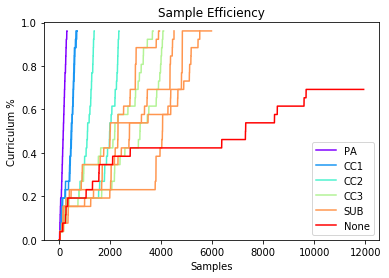

Length 301
Length 691
Length 701
Length 2341
Length 1371
Length 4091
Length 3681
Length 5512
Length 4502
Length 5971
Length 3931
Length 11942


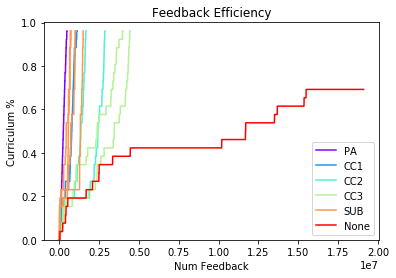

In [3]:
data_names = [
    (['0540'], 'PA'),
#     (['0577', '0578'], 'PA22'),
    (['0541', '0542'], 'CC1'),
    (['0543', '0544'], 'CC2'),
    (['0545', '0546'], 'CC3'),
    (['0722', '0723', '688'], 'SUB'),
#     (['0547', '0548'], 'SUB'),
    (['0481'], 'None'),
]

plot_curriculum(data_names, 'samples')

plot_curriculum(data_names, 'feedback')

Length 79
Length 69
Length 1798
Length 1886
Length 1529
Length 2494
Length 4180
Length 3088
Length 911
Length 893
Length 24864
Length 35610


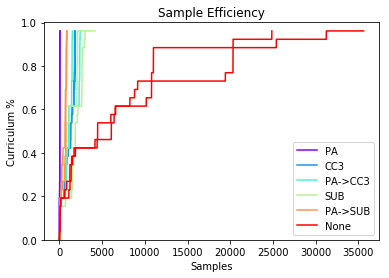

Length 79
Length 69
Length 1798
Length 1886
Length 1529
Length 2494
Length 4180
Length 3088
Length 911
Length 893
Length 24864
Length 35610


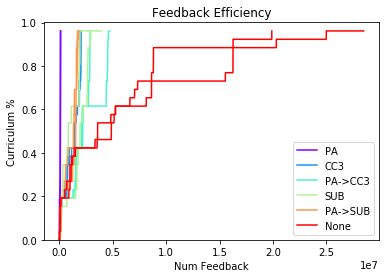

Length 79
Length 69
Length 1798
Length 1886
Length 1529
Length 2494
Length 4180
Length 3088
Length 911
Length 893


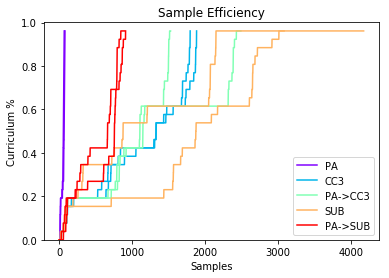

Length 79
Length 69
Length 1798
Length 1886
Length 1529
Length 2494
Length 4180
Length 3088
Length 911
Length 893


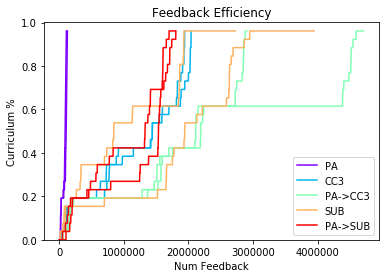

In [4]:
data_names = [ 
    (['0877', '0878'], 'PA'),
    (['0885', '0886'], 'CC3'),
    (['0895', '0896'], 'PA->CC3'),
    (['0887', '0888'], 'SUB'),
    (['0897', '0898'], 'PA->SUB'),
    (['0883', '0884'], 'None'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

# SAME, but no NONE
data_names = [ 
    (['0877', '0878'], 'PA'),
    (['0885', '0886'], 'CC3'),
    (['0895', '0896'], 'PA->CC3'),
    (['0887', '0888'], 'SUB'),
    (['0897', '0898'], 'PA->SUB'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

## <font color='green'>[HELPER] How close are we to the "best case" feedback efficiency (i.e. IL from oracle)</font>

Next steps: Once we re-run the RL runs with no 10-rule, replace them here.

If we're close, it's probably not worth trying to make the RL training process much more efficient.

(Is this the best case? I'm assuming IL > RL, but maybe not always true?)

Length 2341
Length 1371
Length 593


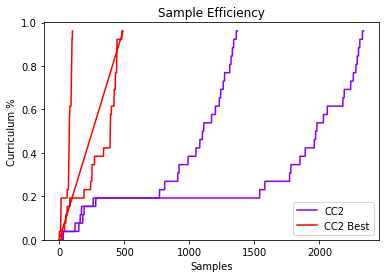

Length 4091
Length 3681
Length 1382


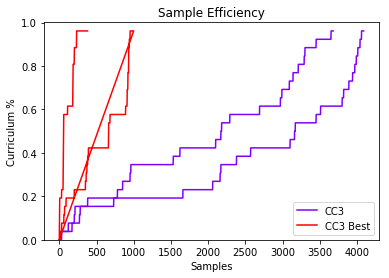

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Length 6748
Length 8364
Length 622


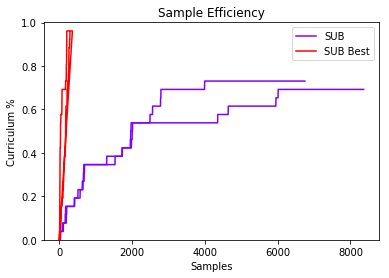

In [5]:
# NOTE: 'Best' runs didn't have the 10-rule, others did
data_names = [
    (['0543', '0544'], 'CC2'),
    (['0656'], 'CC2 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0545', '0546'], 'CC3'),
    (['658'], 'CC3 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0547', '0548'], 'SUB'),
    (['0660'], 'SUB Best'),
]
plot_curriculum(data_names, 'samples')

## <font color='green'> [HELPER] Does dropping instructions help? </font>

Understore_I means no instructions.

Conclusion: No real difference for most teachers. Possible improvmeent for SUB, but also may just be b/c we trained longer.

Length 56
Length 391
Length 301
Length 361
Length 351
Length 2341
Length 1371
Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Length 3231
Length 1781
Length 4091
Length 3681
Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Length 2831
Length 2821


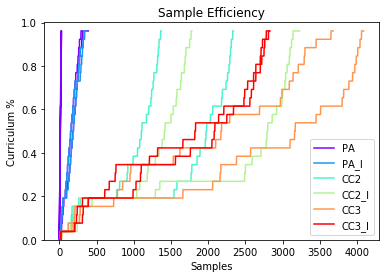

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Length 6748
Length 8364
Length 15400
Length 17249


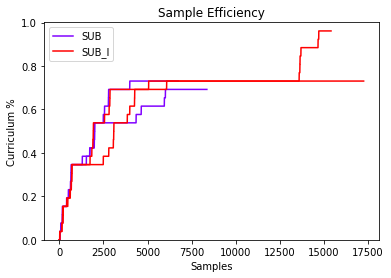

In [6]:
data_names = [
    (['0539', '0540'], 'PA'),
    (['0597', '0598'], 'PA_I'),
    (['0543', '0544'], 'CC2'),
    (['0579', '0580'], 'CC2_I'),
    (['0545', '0546'], 'CC3'),
    (['0581', '0582'], 'CC3_I'),
]

plot_curriculum(data_names, 'samples')


data_names = [
    (['0547', '0548'], 'SUB'),
    (['0599', '0600'], 'SUB_I'),
]

plot_curriculum(data_names, 'samples')

# <font color='blue'> Claim 1: Feedback helps the agent learn more quickly (distillation) </font>
## <font color='blue'> [Status: hard teachers get stuck, and no teachers outperform PA yet!] </font>



## <font color='blue'>[STATUS] - Need to work on sample-efficiency.</font>


If this isn't true for certain higher-level teachers that's fine, so long as we are able to show that the problem is grounding, but once grounded it does work better.

### GOOD NEWS: All agents trained with feedback outperform no teacher.

### BAD NEWS: Agents trained with complex teachers have a hard time completing the curriculum.

## <font color='blue'>[MAIN] Feedback Efficiency of Different Teachers </font>

Length 1809
Length 5030
Length 7763
Length 3701
Length 6138
Length 5396
Length 18531
Length 15956
Length 5306
Length 6153
Length 11942
Length 1493
Length 1481


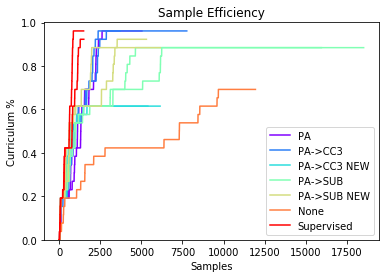

Length 1809
Length 5030
Length 7736
Length 3675
Length 6138
Length 5396
Length 18507
Length 15932
Length 5306
Length 6153
Length 11942
'Train/NumFeedbackTotal'
couldn't plot Supervised


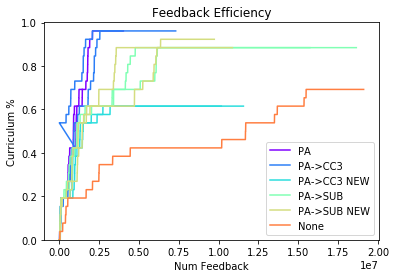

Length 1809
Length 5030
Length 7736
Length 3675
Length 6138
Length 5396
Length 18507
Length 15932
Length 5306
Length 6153


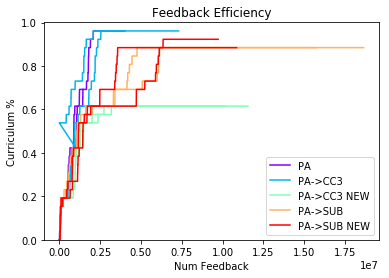

In [7]:
# OLD ENTROPY -seems to do better with .001
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
#     (['0753', '0754'], 'PA2'),
#     (['0629', '0630'], 'CC1'),
#     (['0631', '0632'], 'CC2'),
#     (['0633', '0634'], 'CC3'),
    (['0666', '0667'], 'PA->CC3'),
    (['0825', '0826'], 'PA->CC3 NEW'),
#     (['0635', '0636'], 'SUB'),
    (['0668', '0669'], 'PA->SUB'),
    (['827', '828'], 'PA->SUB NEW'),
#     (['0664'], 'SUB BIG'),
    (['0481'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

Length 1809
Length 5030
Length 2806
Length 11942
Length 1493
Length 1481


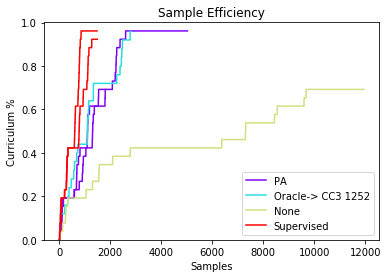

Length 1809
Length 5030
Length 2806
Length 11942
'Train/NumFeedbackTotal'
couldn't plot Supervised


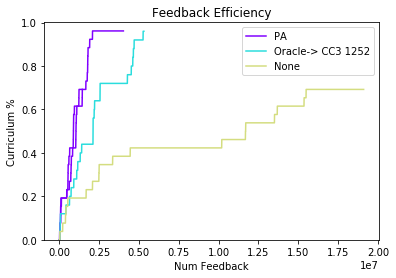

Length 1809
Length 5030
Length 2806


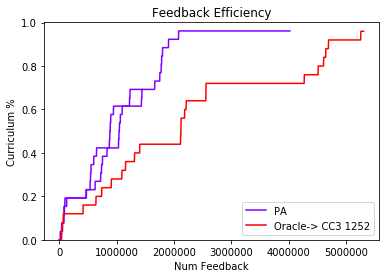

In [8]:
# OLD ENTROPY -seems to do better with .001
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
#     (['0666', '0667'], 'PA->CC3'),
#     (['0825', '0826'], 'PA->CC3 NEW'),
    (['T1252',], 'Oracle-> CC3 1252'),
#     (['T1254',], 'Oracle-> CC3 1254'),
#     (['T1255',], 'Oracle-> CC3 1255'),
#     (['T1256',], 'Oracle-> CC3 1256'),
    (['0481'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

Length 1792
Length 1878
Length 13610
Length 14665
Length 3954
Length 4051
Length 14321
Length 9466
Length 8932
Length 8532
Length 24864
Length 35610
Length 1493
Length 1481


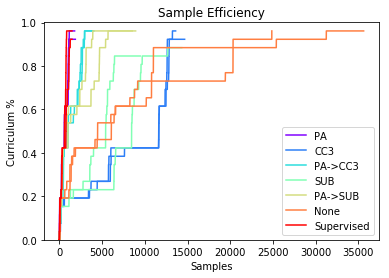

Length 1792
Length 1878
Length 13610
Length 14665
Length 3954
Length 4051
Length 14321
Length 9466
Length 8932
Length 8532
Length 24864
Length 35610
'Train/NumFeedbackTotal'
couldn't plot Supervised


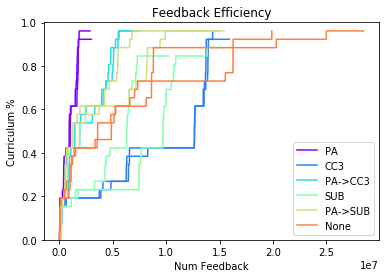

Length 1792
Length 1878
Length 13610
Length 14665
Length 3954
Length 4051
Length 14321
Length 9466
Length 8932
Length 8532


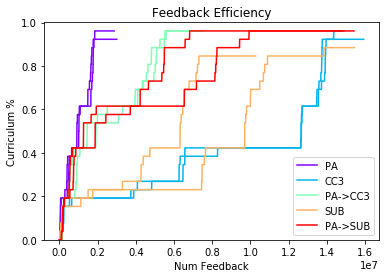

In [9]:
data_names = [  # TODO: re-run these 
    (['867', '868'], 'PA'),
    (['0889', '0890'], 'CC3'),
    (['869', '870'], 'PA->CC3'),
    (['0891', '0892'], 'SUB'),
    (['871', '872'], 'PA->SUB'),
    (['0883', '0884'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

Length 6138
Length 5396
Found multiple files with name 084_: ['084_', 'T1084_PA_to_CC3_teacherPreActionAdvice, CartesianCorrections_SD_threshS0.99_threshAR0.9_threshAD0.6_lr0.0001_ent1e-05_1']
couldn't plot PA->CC3 DAgger


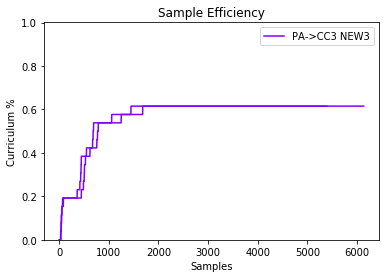

Length 5306
Length 6153
Length 5739
Length 3959


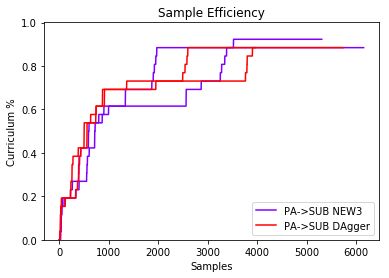

In [10]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['084_', '842'], 'PA->CC3 DAgger'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['843', '844'], 'PA->SUB DAgger'), #844
]
plot_curriculum(data_names, 'samples')


Length 946
Length 1162
Length 1809
Length 5030
Length 2450
Length 2282


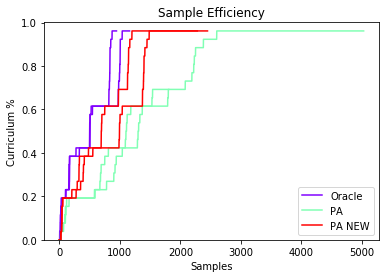

Length 946
Length 1162
Length 1809
Length 5030
Length 2450
Length 2282


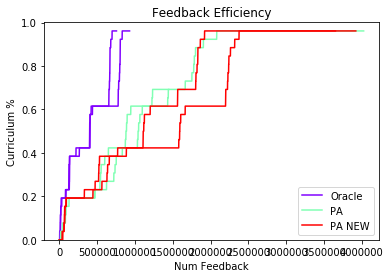

In [11]:
# HOW CLOSE IS PA DISTILL TO ORACLE DISTILL?
data_names = [  # TODO: re-run these 
    (['799', '800'], 'Oracle'),
    (['0627', '0628'], 'PA'),
    (['0753', '0754'], 'PA NEW'),
#     (['0787', '0788'], 'PA NEW2'),
#     (['0759', '0760'], 'PA PRETRAINED'),
#     (['0793', '0794'], 'PA PRETRAINED2'),
#     (['801', '802'], 'PA Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')



## <font color='blue'>[HELPER] How close are we to the "best case" feedback efficiency (i.e. distill from pretrained model)</font>

Length 74
Length 86
Length 49


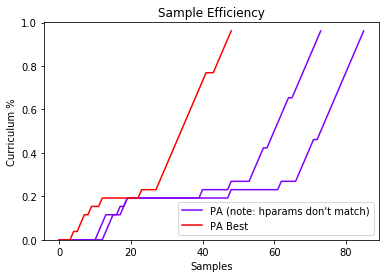

Length 2070
Length 2521
Length 656


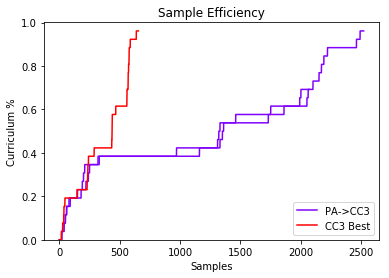

Length 9601
Length 7210
Length 199


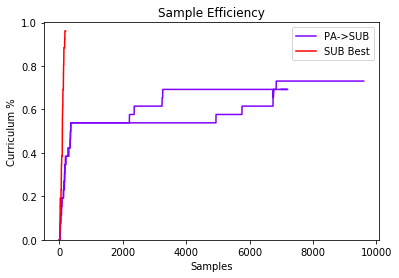

In [12]:
# NO DISTILLATION TO NO TEACHER (collect oracle, distill to teacher)
data_names = [
    (['0779', '0780'], "PA (note: hparams don't match)"),
    (['0655'], 'PA Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['639', '640'], 'PA->CC3'),
    (['659'], 'CC3 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['641', '642'], 'PA->SUB'),
    (['661'], 'SUB Best'),
]
plot_curriculum(data_names, 'samples')

Length 112
Length 112
Length 1493
Length 1481


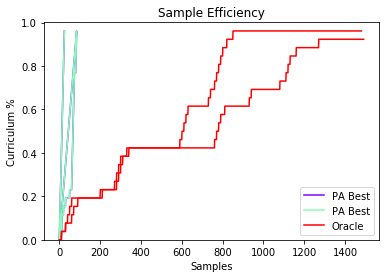

Length 4666
Length 18091
Length 593
Length 1493
Length 1481


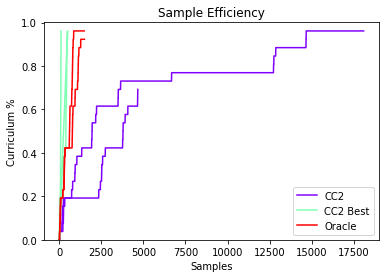

Length 7763
Length 3701
Length 1382
Length 1493
Length 1481


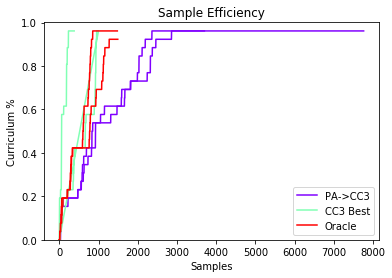

Length 18531
Length 15956
Length 622
Length 1493
Length 1481


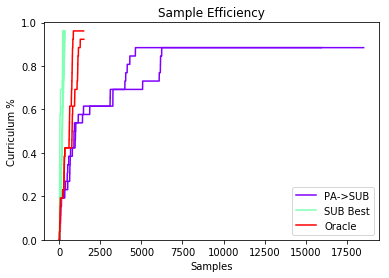

In [13]:
# YES DISTILLATION (collect with pretrained model, distill to no teacher)
# NOTE: HPARAMs are out of date
    
data_names = [
    (['0654'], 'PA Best'),
    (['0654'], 'PA Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0631', '0632'], 'CC2'),
    (['0656'], 'CC2 Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0666', '0667'], 'PA->CC3'),
    (['658'], 'CC3 Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0668', '0669'], 'PA->SUB'),
    (['0660'], 'SUB Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

# <font color='purple'> Claim 2: Policies conditioned on feedback can generalize zero-shot to performing new tasks (no distillation). </font> <font color='red'> [TODO: plot generalization results for the recent exps] </font>

## <font color='purple'> [Status: Easy teachers generalize zero-shot, but hard teachers don't.] </font>

## <font color='purple'>[STATUS] - Easy teachers generalize zero-shot, but hard teachers don't. </font>

(The new levels should not have any new feedback vocabulary.)

### GOOD NEWS: all the teachers outperform not having a teacher
### BAD NEWS: the higher-level teachers are way worse than the easy teacher... we should find a way to learn those better.


## <font color='purple'>[MAIN] Feedback Efficiency of Different Teachers </font>

CURRENT PROBLEMS

PA - Teacher itself is failing??

CC1 - Beautiful and awesome. Unclear why it doesn't run into the same problems as PA

CC2 - can't open doors??

CC3 - wanders randomly

CC4 - wanders randomly/spins in circles

SUB - spins in circles

NONE - A bit of wandering, but also doesn't want to open doors.

TODO: check existing door levels in the train set. Maybe it just forgot them and we need curriculum smoothing?



## Comparing Across Teachers

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


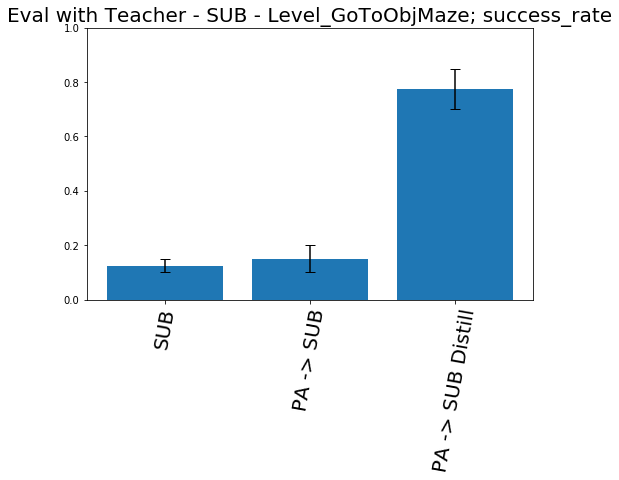

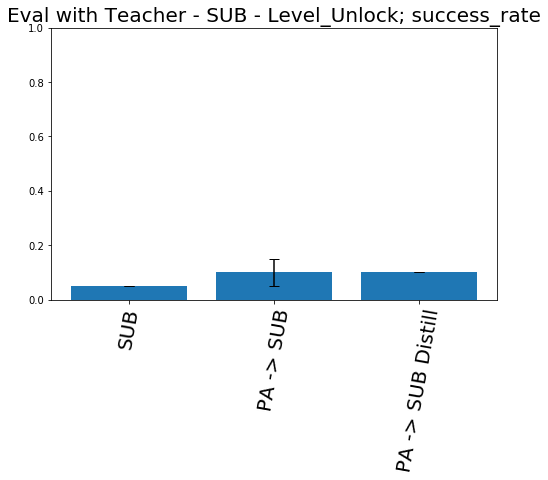

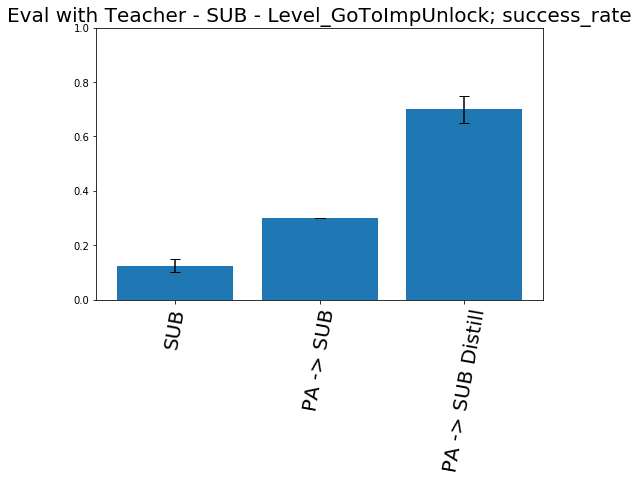

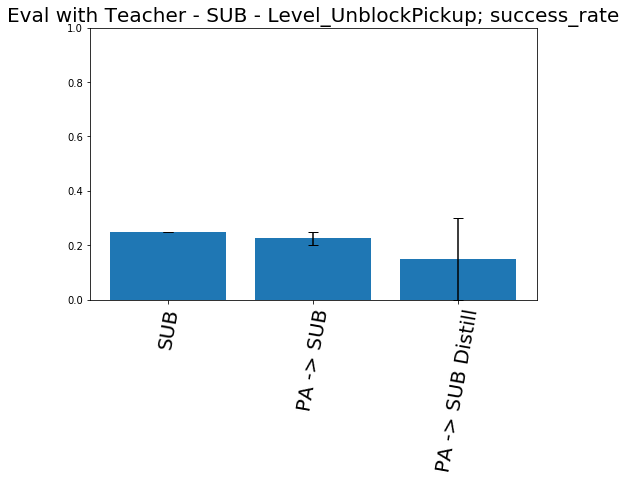

In [110]:
runs = [
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_635_NOFINETUNE', 'EVAL_636_NOFINETUNE'], 'PA -> SUB'),
    (['EVAL_668_NOFINETUNE', 'EVAL_669_NOFINETUNE'], 'PA -> SUB Distill'),
]
plot_final_generalization(runs, 'Eval with Teacher - SUB') # kangaroo

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


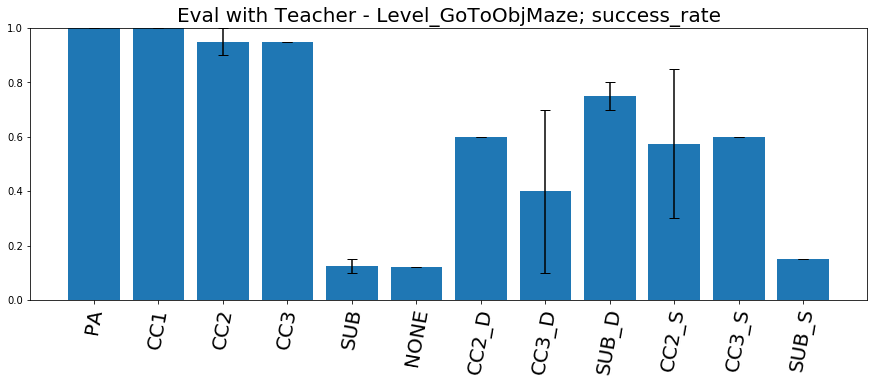

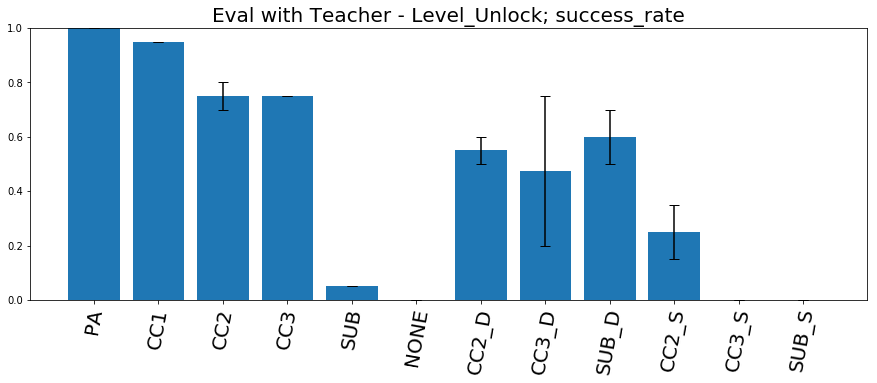

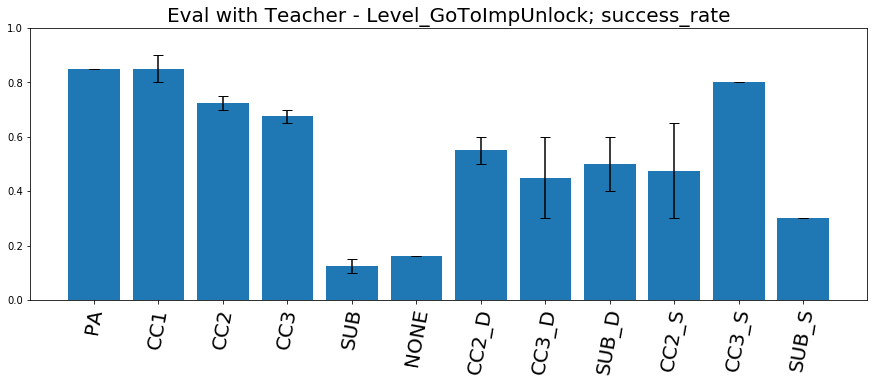

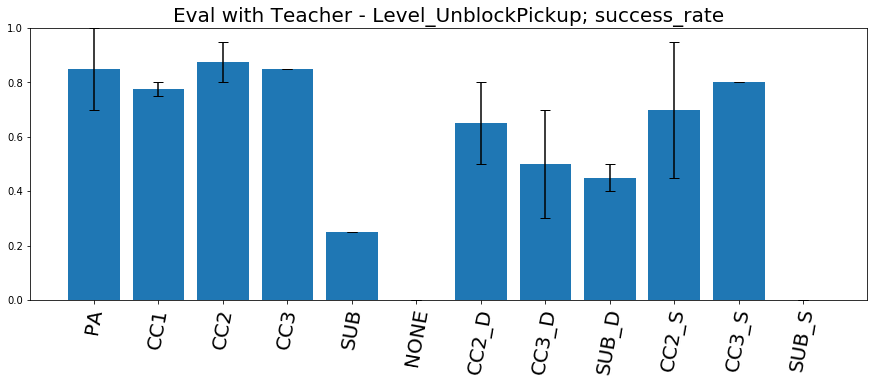

In [78]:
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_541', 'EVAL_542'], 'CC1'),
    (['EVAL_543', 'EVAL_544'], 'CC2'),
    (['EVAL_545', 'EVAL_546'], 'CC3'),
#     (['0722', '0723', '688'], 'SUB'),
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_NONE_LOWD'], 'NONE'),
    (['EVAL_557', 'EVAL_558'], 'CC2_D'),
    (['EVAL_559', 'EVAL_560'], 'CC3_D'),
    (['EVAL_561', 'EVAL_562'], 'SUB_D'),
    (['EVAL_563', 'EVAL_564'], 'CC2_S'),
    (['EVAL_565'], 'CC3_S'),
    (['EVAL_568'], 'SUB_S'),
]

plot_final_generalization(runs, 'Eval with Teacher')

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


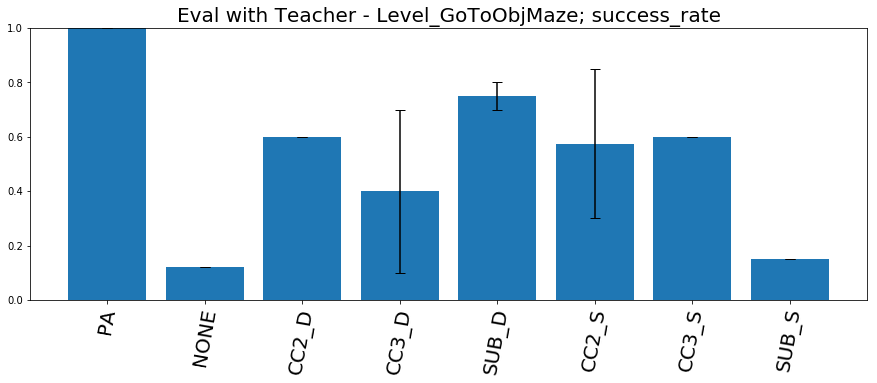

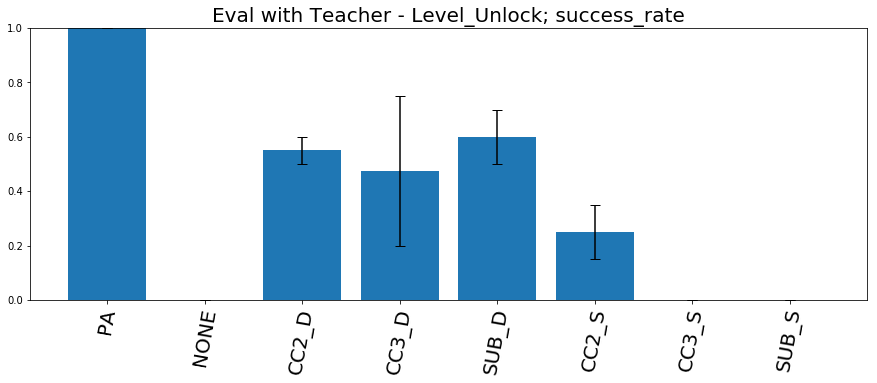

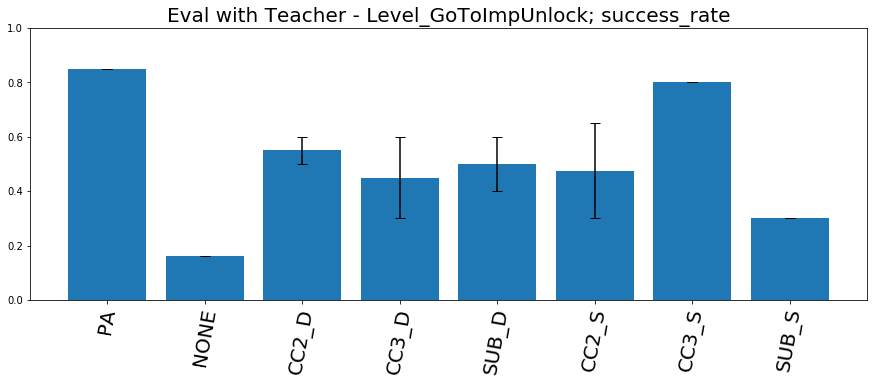

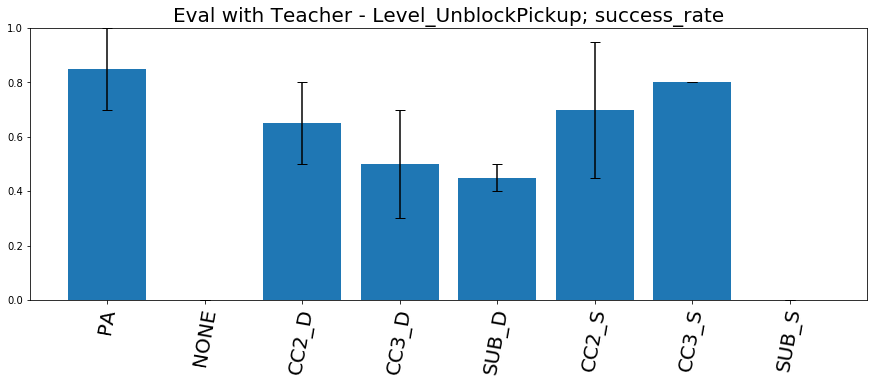

In [79]:
# WITH DISTILLATION
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
#     (['EVAL_541', 'EVAL_542'], 'CC1'),
#     (['EVAL_543', 'EVAL_544'], 'CC2'),
#     (['EVAL_545', 'EVAL_546'], 'CC3'),
#     (['0722', '0723', '688'], 'SUB'),
#     (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_NONE_LOWD'], 'NONE'),
    (['EVAL_557', 'EVAL_558'], 'CC2_D'),
    (['EVAL_559', 'EVAL_560'], 'CC3_D'),
    (['EVAL_561', 'EVAL_562'], 'SUB_D'),
    (['EVAL_563', 'EVAL_564'], 'CC2_S'),
    (['EVAL_565'], 'CC3_S'),
    (['EVAL_568'], 'SUB_S'),
]

plot_final_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_627_NOFINETUNE'] Found multiple files with name EVAL_627_NOFINETUNE: ['EVAL_627_NOFINETUNE_LONG', 'EVAL_627_NOFINETUNE_INSTRS', 'EVAL_627_NOFINETUNE']
ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


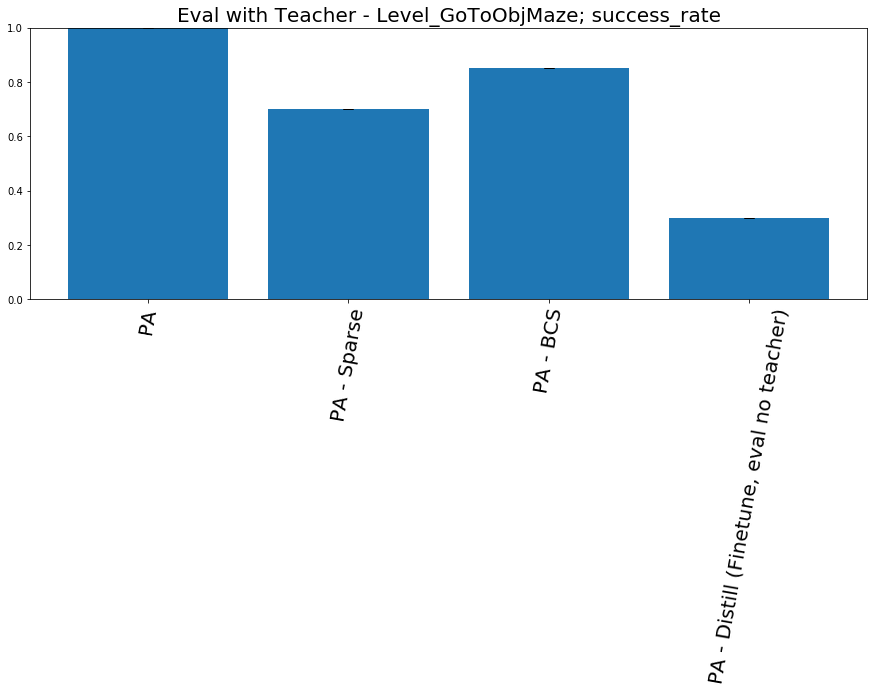

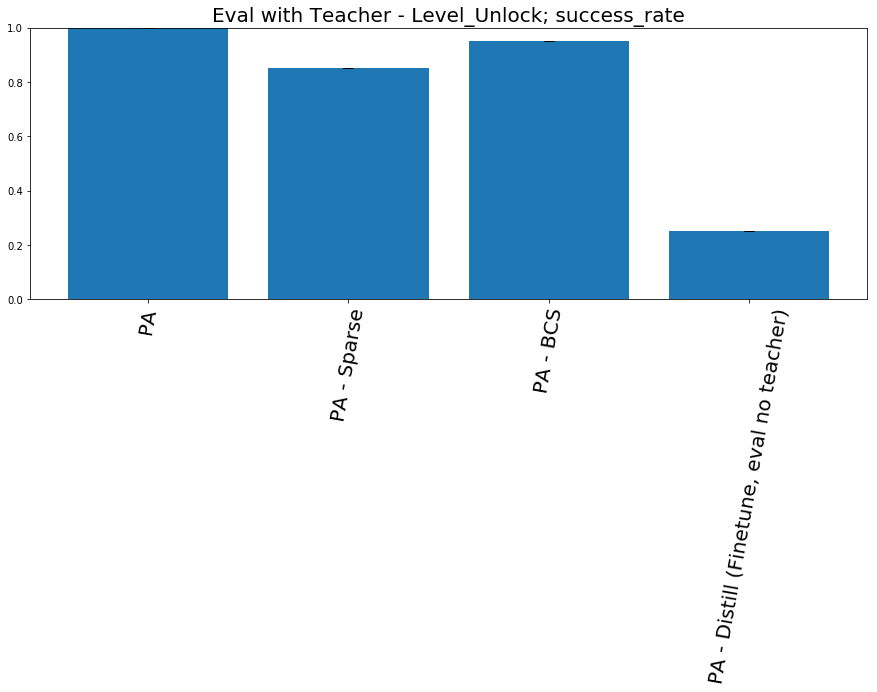

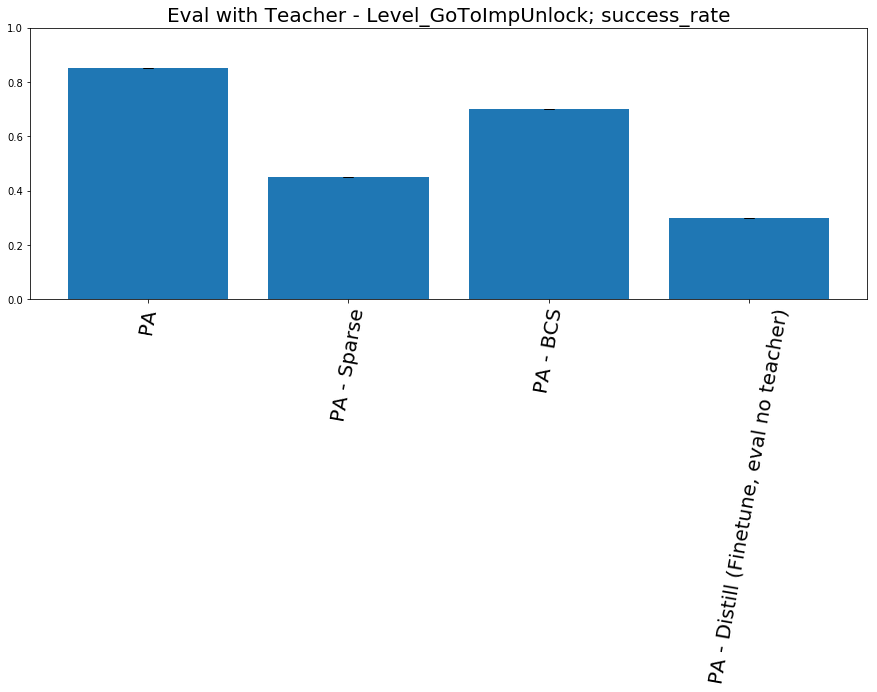

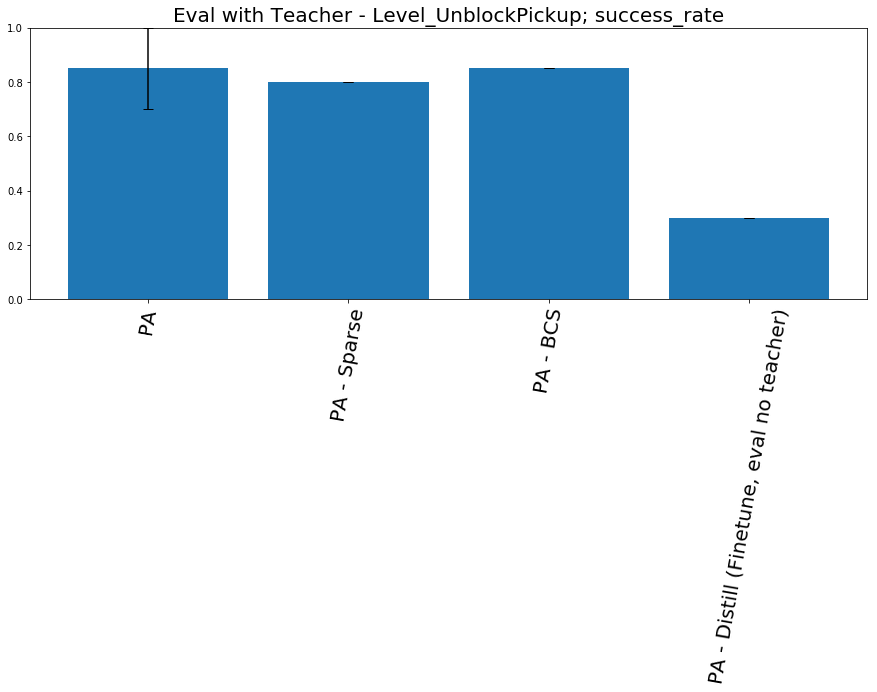

In [80]:
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_577'], 'PA - Sparse'),
    (['EVAL_627_NOFINETUNE'], 'PA - Distill'),
#     (['0706'], 'PA - Self-Distill'),
#     (['0677', '0678'], 'PA - No 10 Rule'),
    (['EVAL_655'], 'PA - BCS'),
    (['EVAL_627_FINETUNE'], 'PA - Distill (Finetune, eval no teacher)'),
#     (['692', '693'], 'PA - Big Batch No Distill'),
#     (['698', '699'], 'PA - Big Batch Distill'),
]
plot_final_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_1252_NOFINETUNE'] Found multiple files with name EVAL_1252_NOFINETUNE: ['EVAL_1252_NOFINETUNE', 'EVAL_1252_NOFINETUNE_LONG', 'EVAL_1252_NOFINETUNE_NOTEACHERS', 'EVAL_1252_NOFINETUNE_NOINSTR']
ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


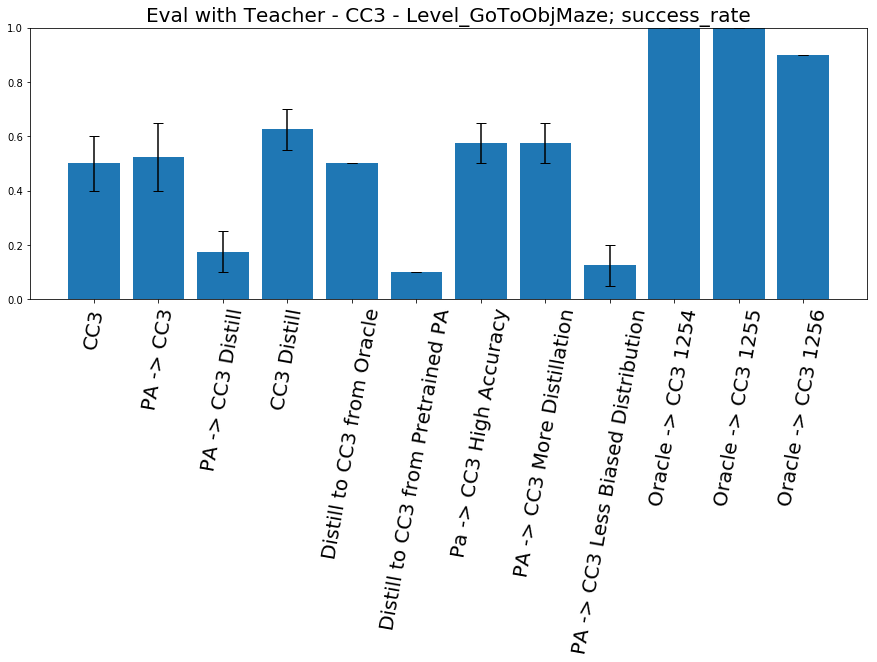

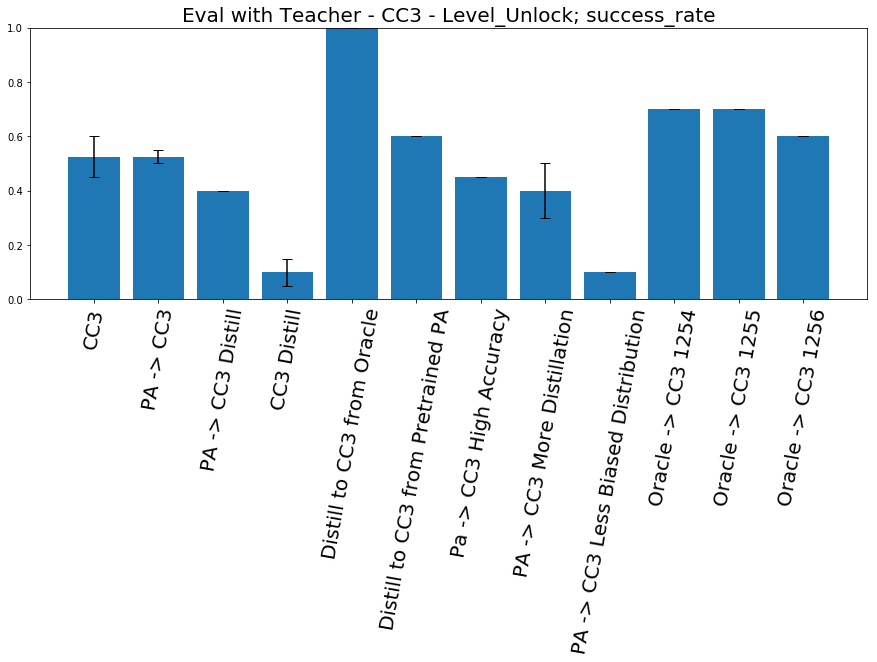

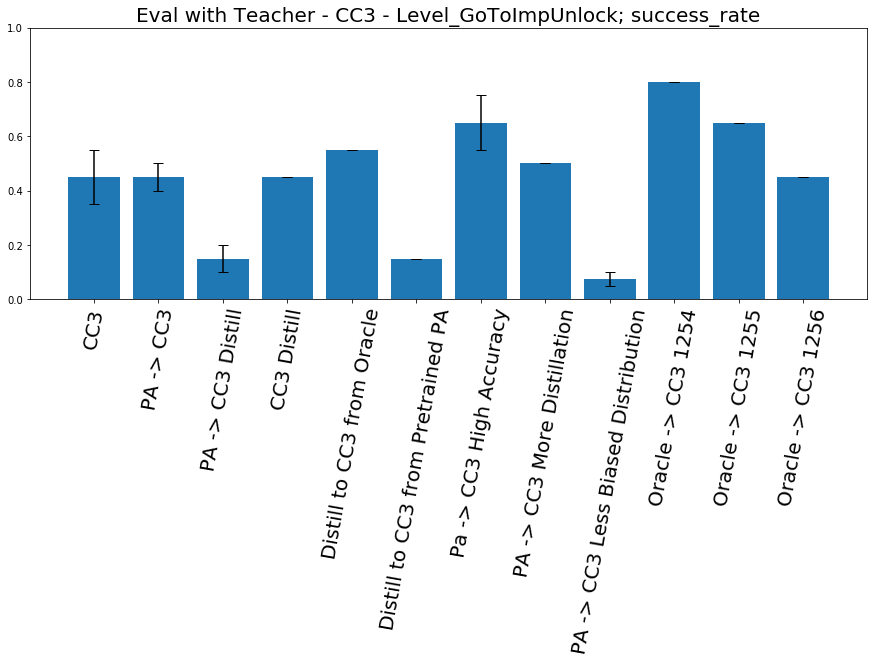

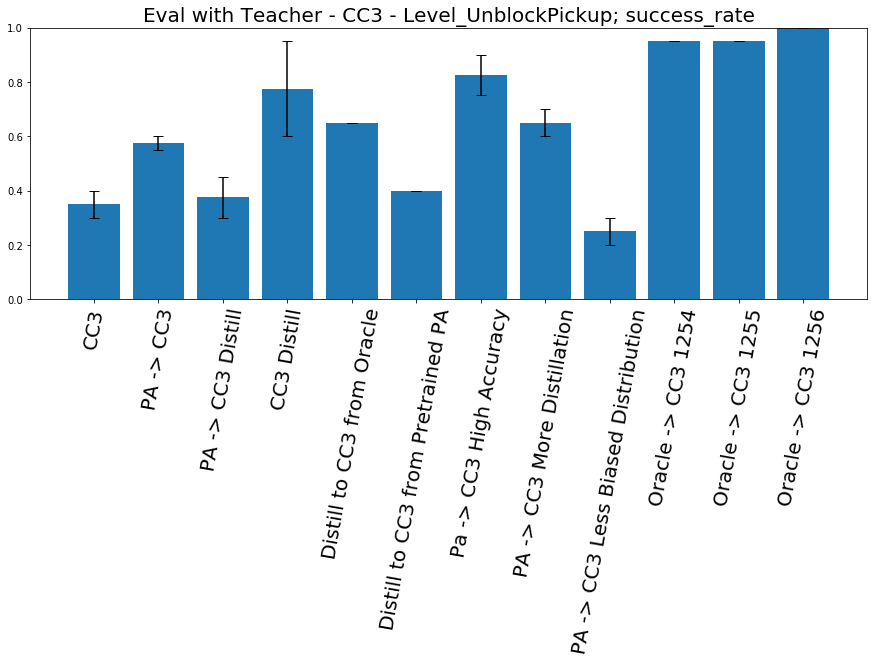

In [81]:
plt.rcParams['figure.figsize'] = [15, 5]
runs = [
    (['EVAL_885_NOFINETUNE', 'EVAL_886_NOFINETUNE'], 'CC3'),
    (['EVAL_895_NOFINETUNE', 'EVAL_896_NOFINETUNE'], 'PA -> CC3'),
    (['EVAL_821_NOFINETUNE', 'EVAL_822_NOFINETUNE'], 'PA -> CC3 Distill'),
    (['EVAL_889_NOFINETUNE', 'EVAL_890_NOFINETUNE'], 'CC3 Distill'),
    (['EVAL_659_NOFINETUNE'], 'Distill to CC3 from Oracle'),
    (['EVAL_851_NOFINETUNE'], 'Distill to CC3 from Pretrained PA'),
    (['EVAL_873_NOFINETUNE', 'EVAL_874_NOFINETUNE'], 'Pa -> CC3 High Accuracy'),
    (['EVAL_869_NOFINETUNE', 'EVAL_870_NOFINETUNE'], 'PA -> CC3 More Distillation'),
    (['EVAL_863_NOFINETUNE', 'EVAL_864_NOFINETUNE'], 'PA -> CC3 Less Biased Distribution'),
    
    
    
    (['EVAL_1252_NOFINETUNE'], 'Oracle -> CC3 1252'),
    (['EVAL_1254_NOFINETUNE'], 'Oracle -> CC3 1254'),
    (['EVAL_1255_NOFINETUNE'], 'Oracle -> CC3 1255'),
    (['EVAL_1256_NOFINETUNE'], 'Oracle -> CC3 1256'),
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')

## Grounding CC3 Well

### Does distilling to no teacher matter? [no difference]

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


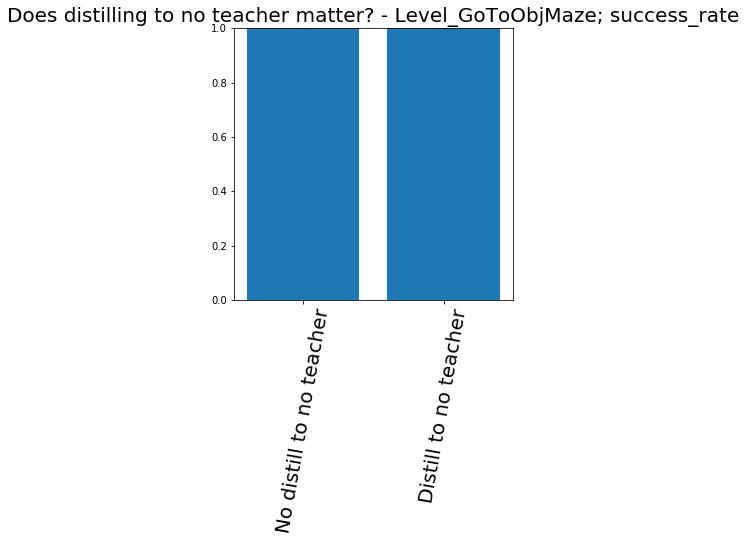

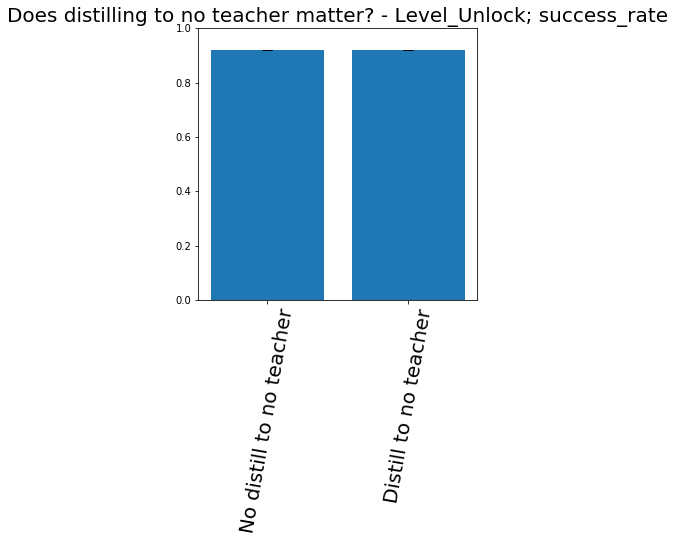

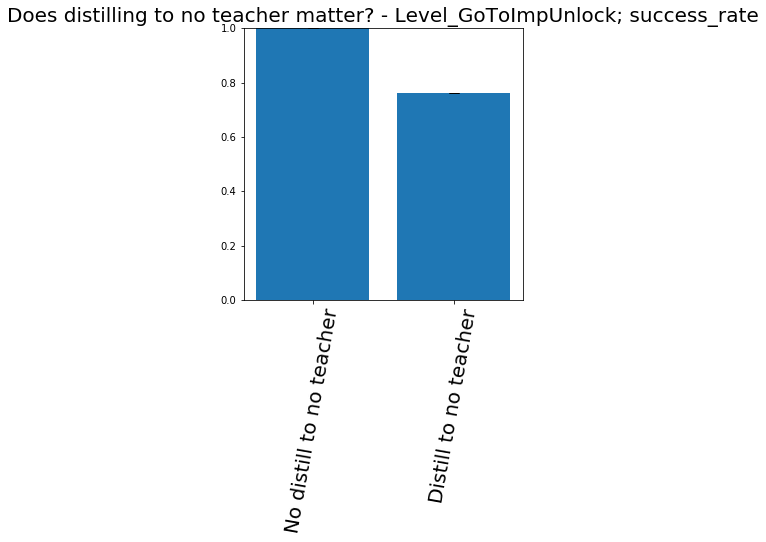

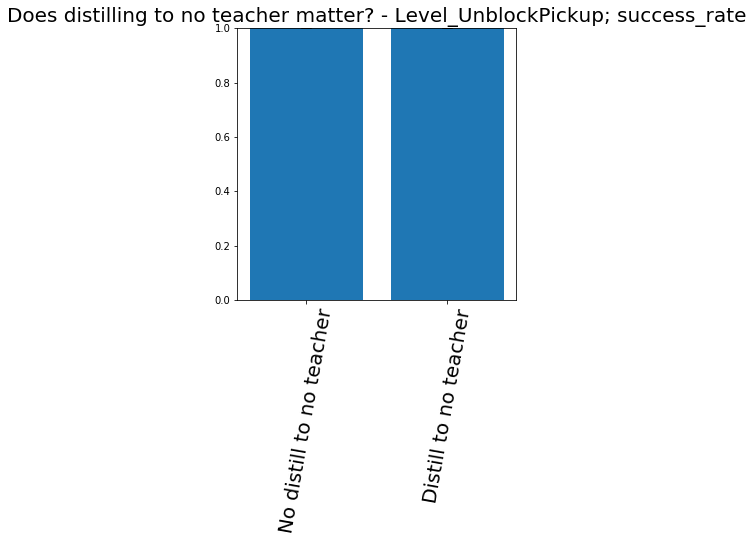

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


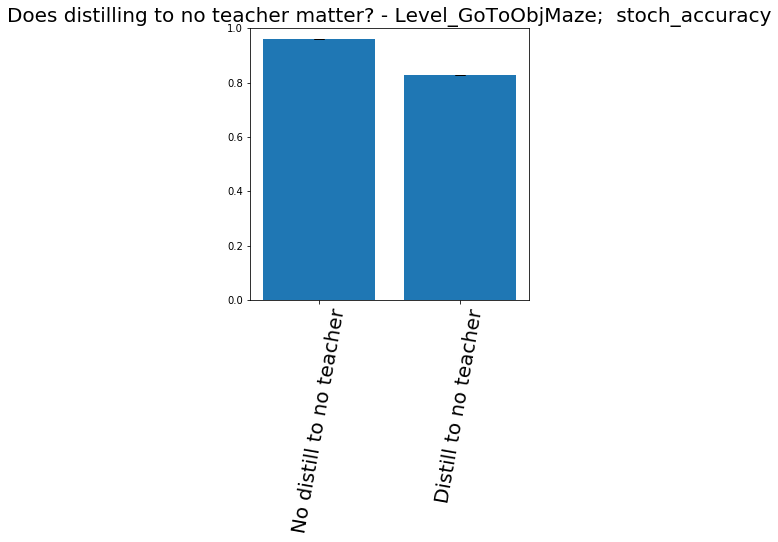

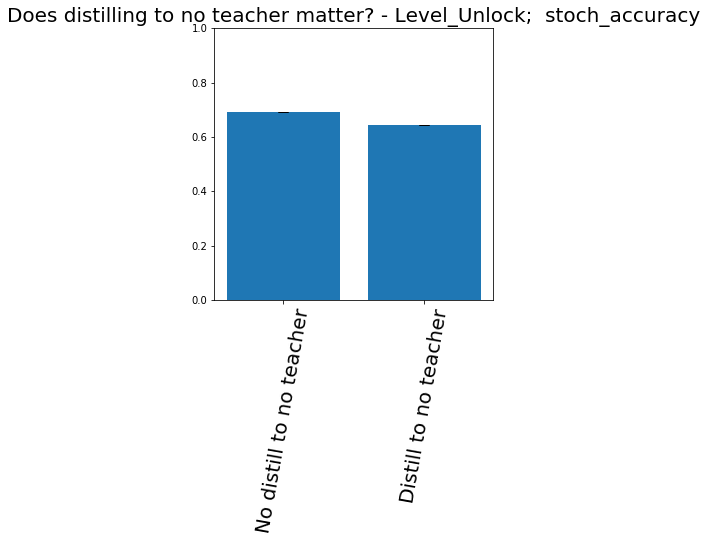

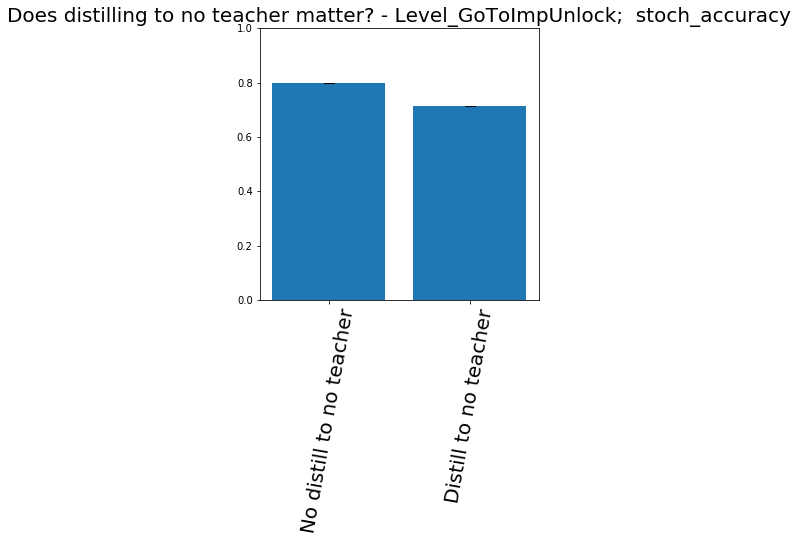

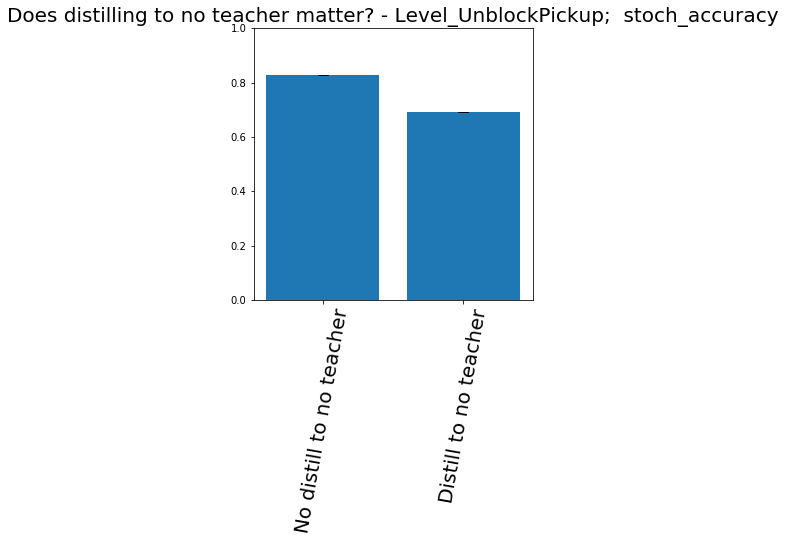

In [104]:

plt.rcParams['figure.figsize'] = [5, 5]
runs = [
#     (['EVAL_1333_NOFINETUNE_INSTRS'], 'No distill to None Instr'),
    (['EVAL_1333_NOFINETUNE_NOINSTR'], 'No distill to no teacher'),
#     (['EVAL_1330_NOFINETUNE_INSTR'], 'Distill to None Instr'),
    (['EVAL_1330_NOFINETUNE_NOINSTR'], 'Distill to no teacher'),
    
]
plot_final_generalization(runs, 'Does distilling to no teacher matter?')
print("=" * 100)
plot_final_generalization(runs, 'Does distilling to no teacher matter?', ' stoch_accuracy')

### Does providing the teacher at eval time matter? [helps significantly]

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


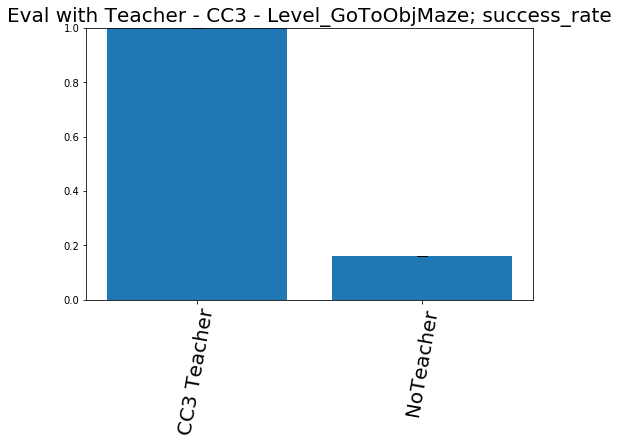

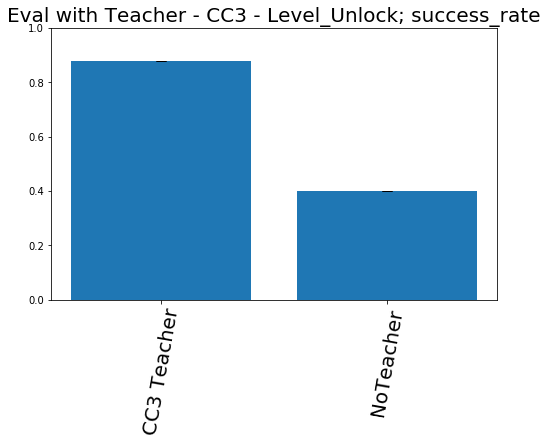

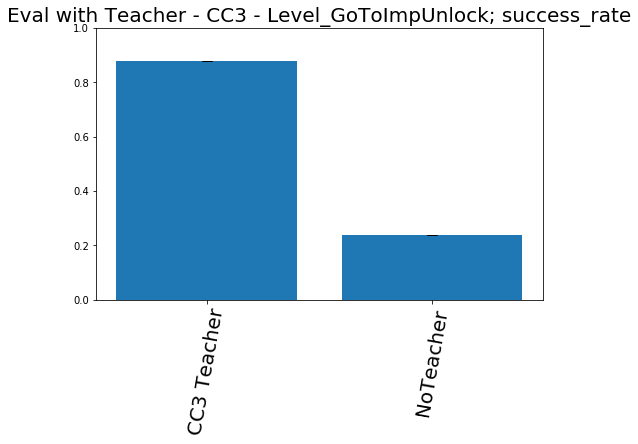

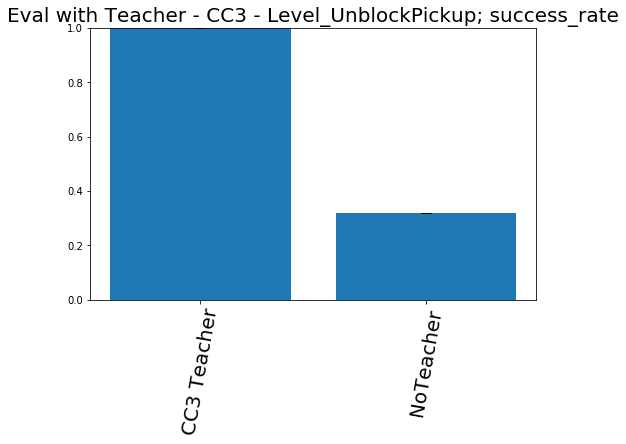

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


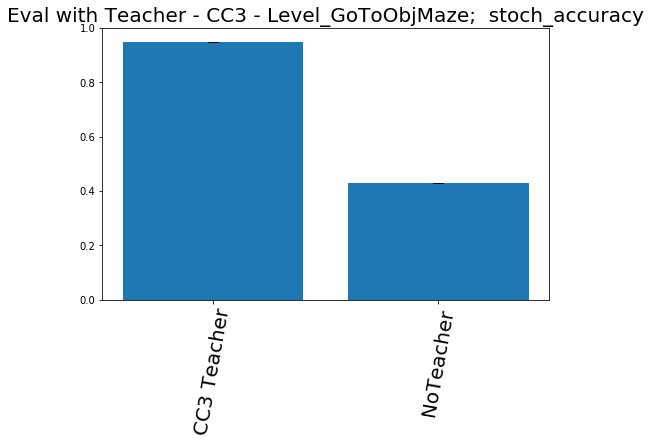

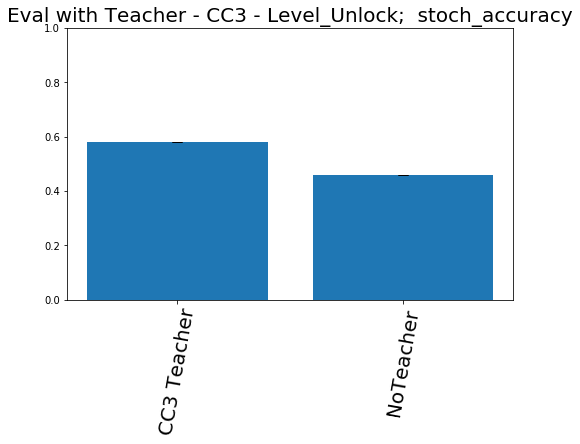

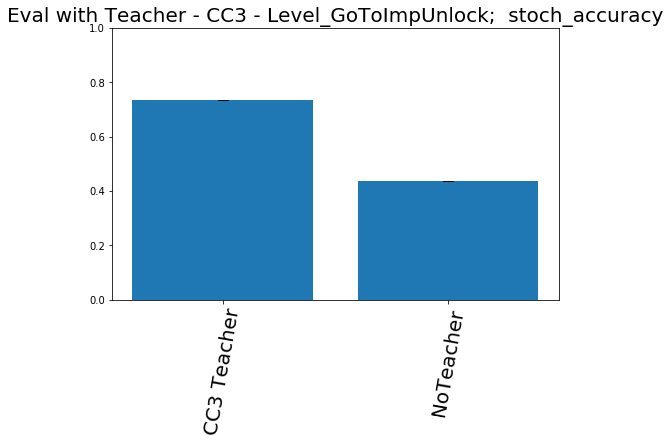

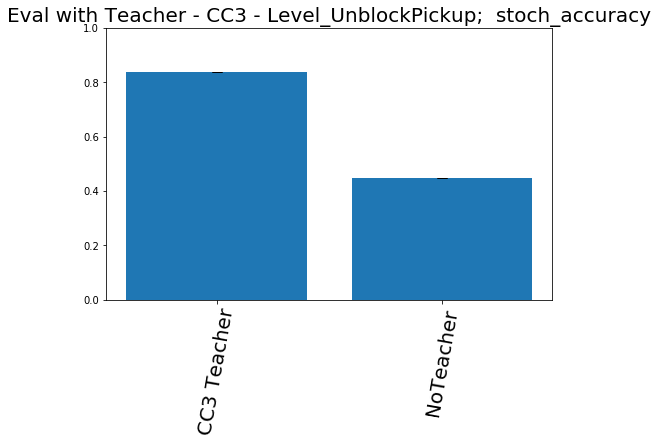

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


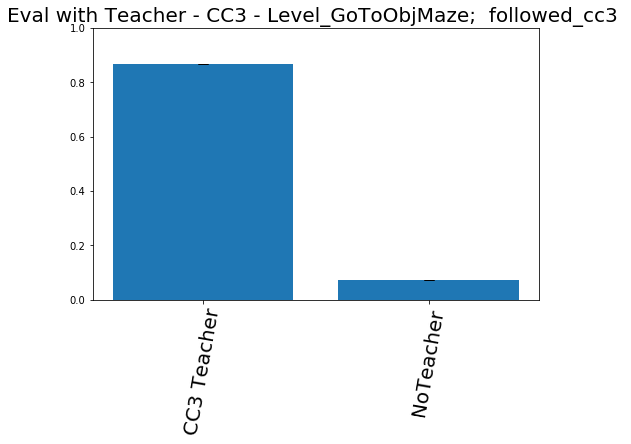

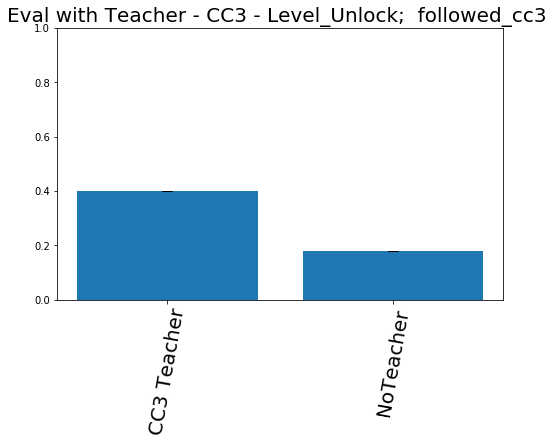

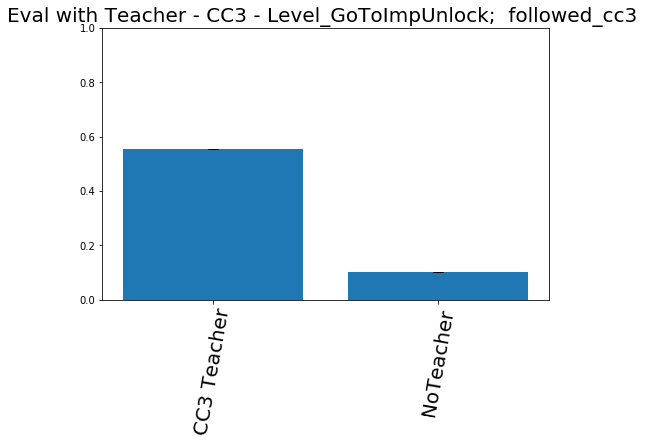

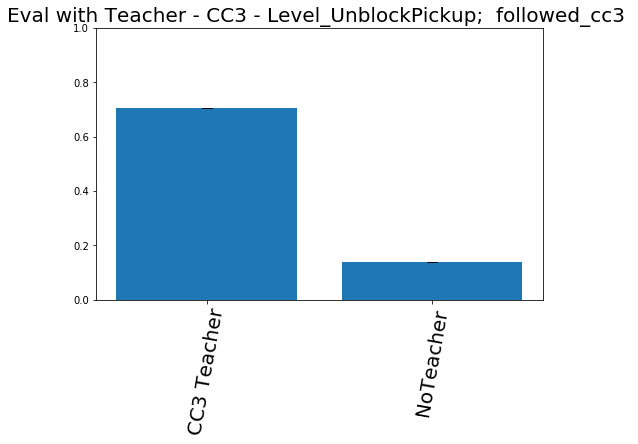

In [105]:

plt.rcParams['figure.figsize'] = [8, 5]
runs = [
    (['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'], 'CC3 Teacher'),
    (['EVAL_1361_NOFINETUNE_NOTEACHER'], 'NoTeacher'),
    
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' followed_cc3 ')

### Does rolling out with stochastic or argmax sampling matter? [stoch is marginally better]

ENV DICT dict_keys(['Level_Open', 'Level_Pickup'])


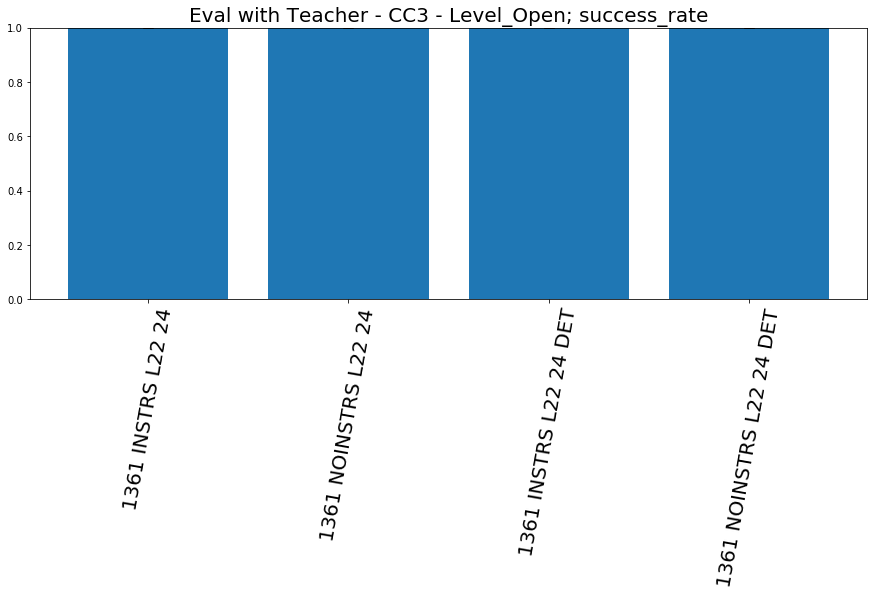

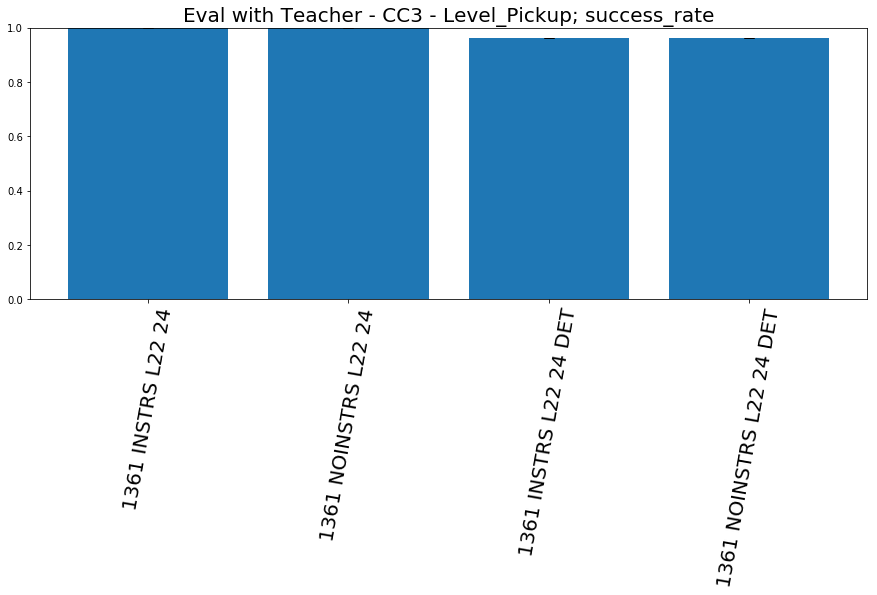

ENV DICT dict_keys(['Level_Open', 'Level_Pickup'])


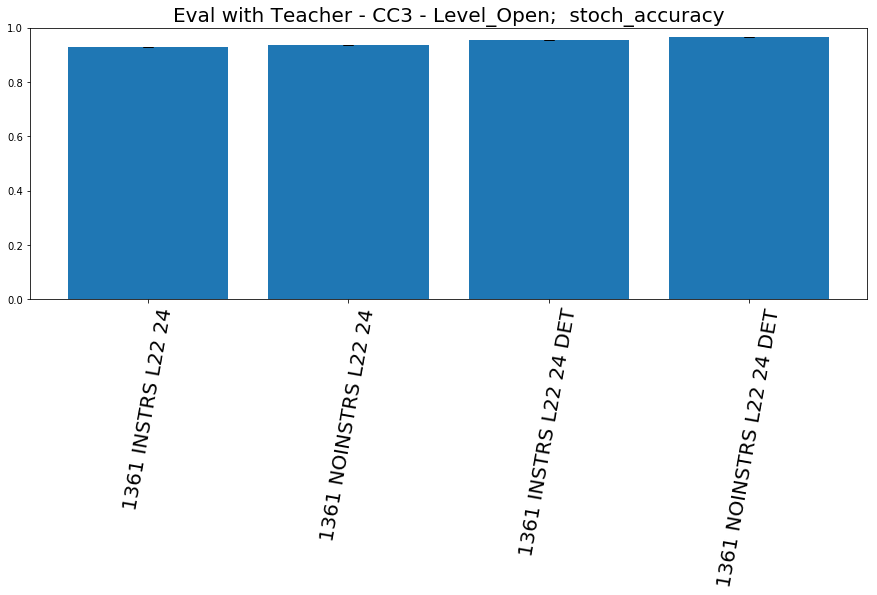

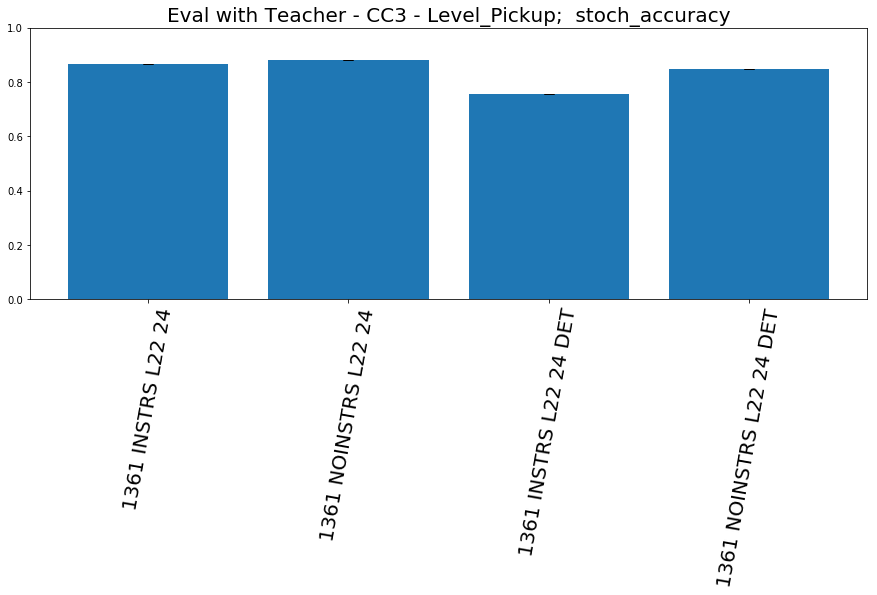

In [85]:
runs = [
    (['EVAL_1361_NOFINETUNE_INSTRS_L22_24_STOCH'], '1361 INSTRS L22 24'),
    (['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_STOCH'], '1361 NOINSTRS L22 24'),
    (['EVAL_1361_NOFINETUNE_INSTRS_L22_24_DET'], '1361 INSTRS L22 24 DET'),
    (['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_DET'], '1361 NOINSTRS L22 24 DET'),
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')

### Does providing the instructions at eval time matter? [hiding instrs helps]

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


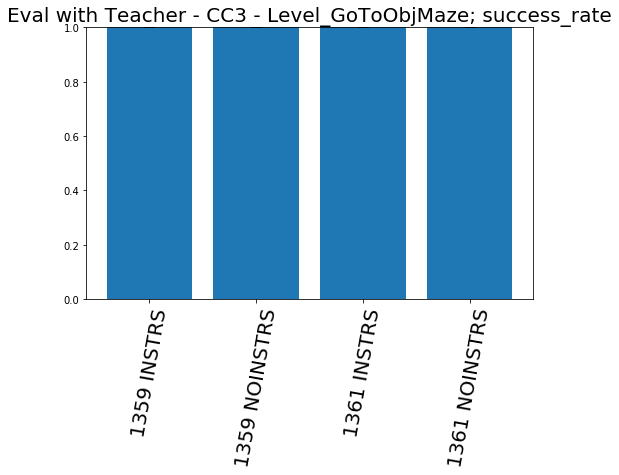

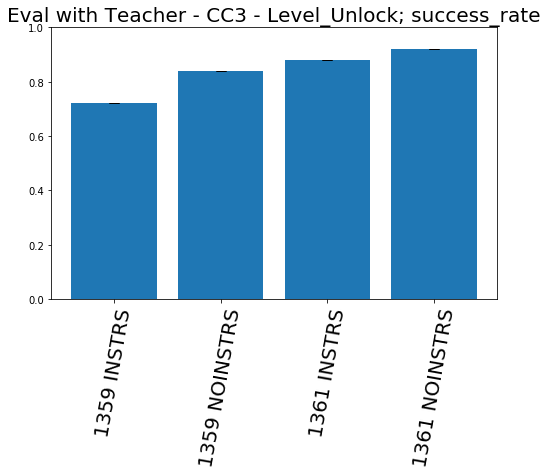

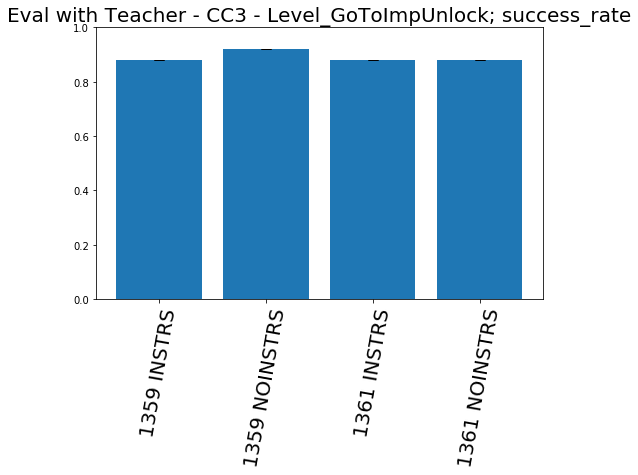

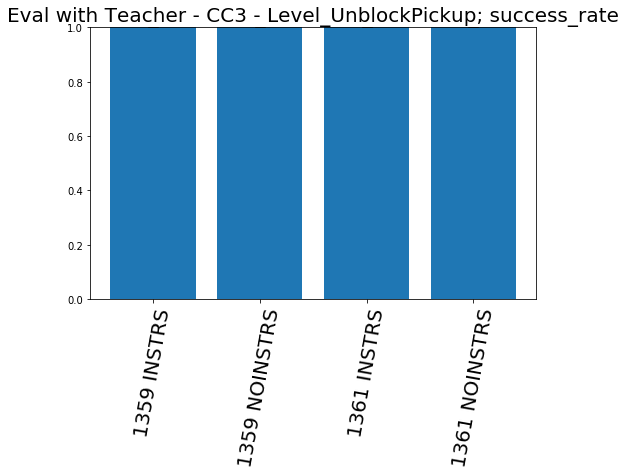

ENV DICT dict_keys(['Level_GoToObjMaze', 'Level_Unlock', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


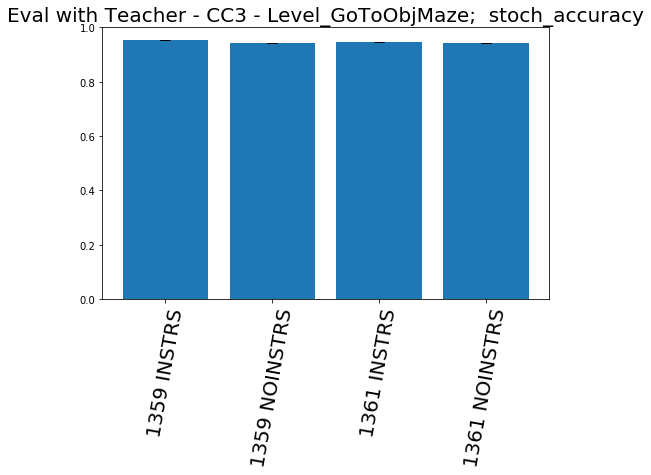

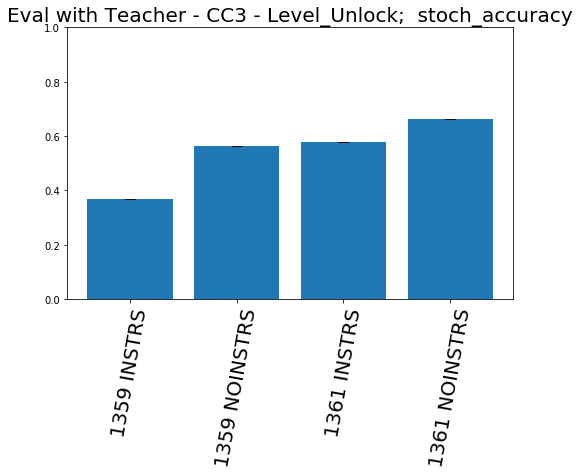

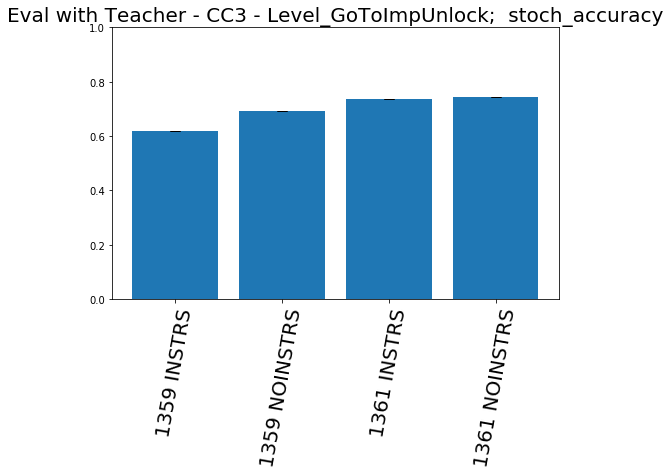

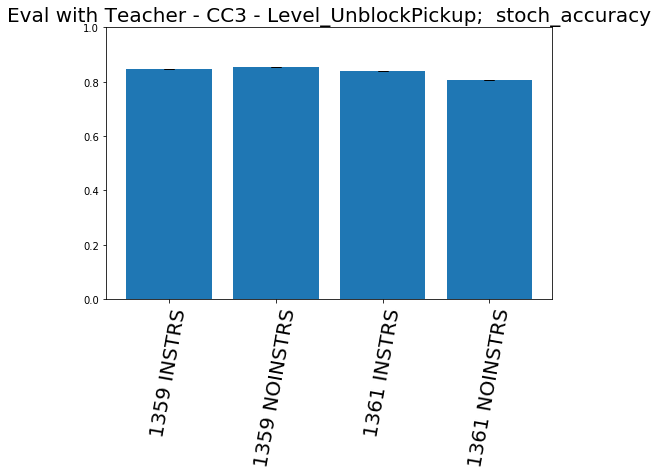

In [109]:
runs = [
    (['EVAL_1359_NOFINETUNE_INSTRS'], '1359 INSTRS'),
    (['EVAL_1359_NOFINETUNE_NOINSTRS'], '1359 NOINSTRS'),
#     (['EVAL_1359_NOFINETUNE_NOTEACHER'], '1359 NOTEACHER'),
    (['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'], '1361 INSTRS'),
    (['EVAL_1361_NOFINETUNE_NOINSTRS_SIMPLE'], '1361 NOINSTRS'),
#     (['EVAL_1361_NOFINETUNE_NOTEACHER'], '1361 NOTEACHER'),
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')

### Does finetuning help? [no???]

ENV DICT dict_keys(['Level_Unlock', 'Level_Open', 'Level_GoToObjMaze', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


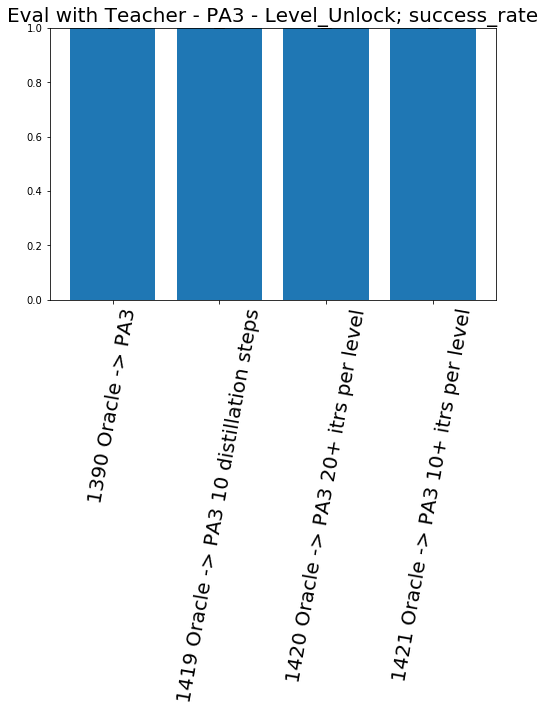

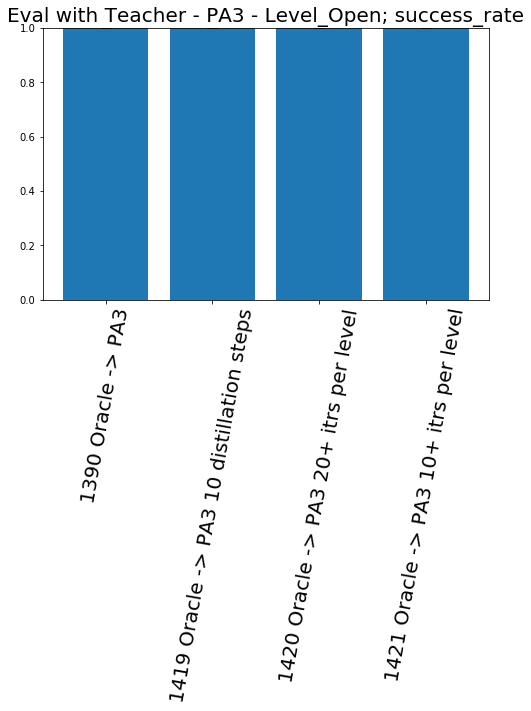

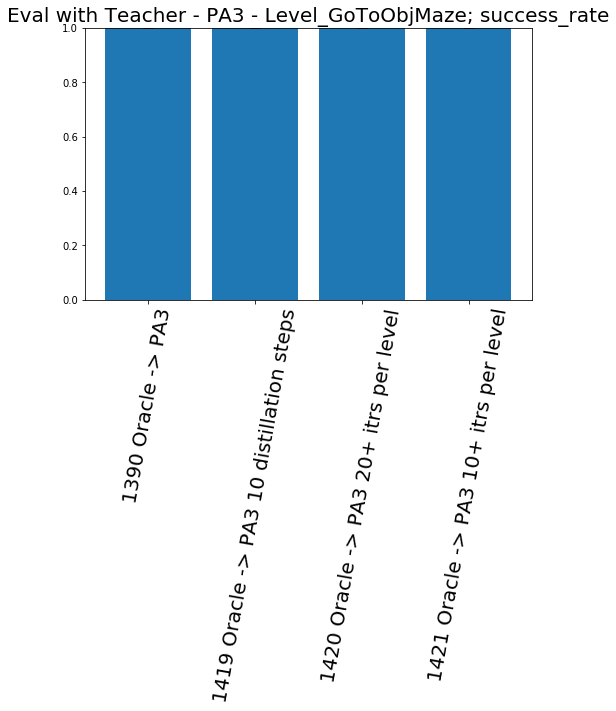

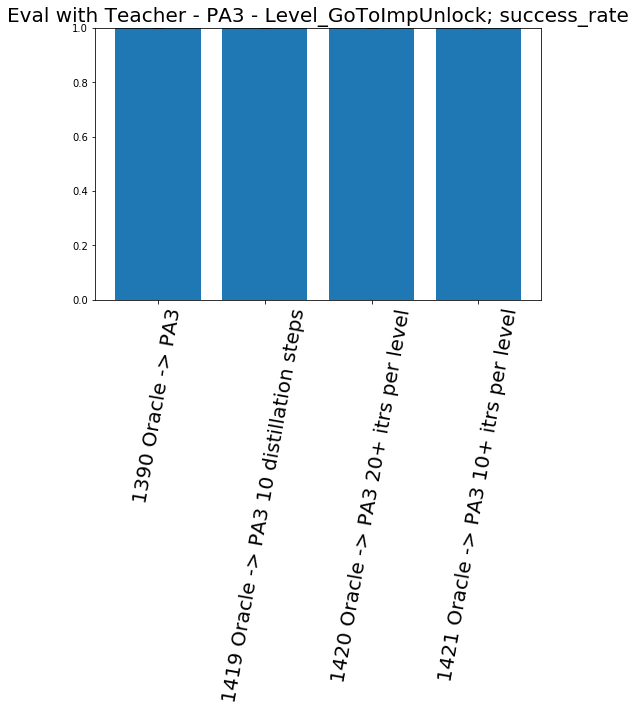

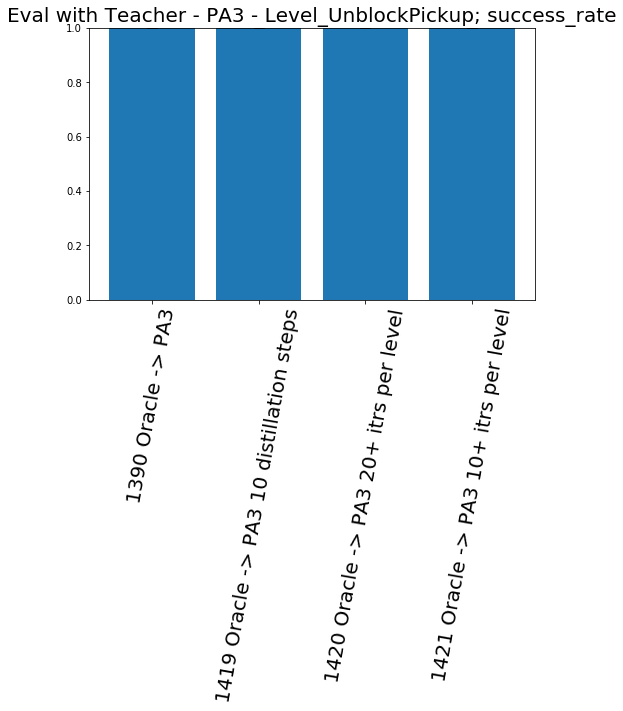

ENV DICT dict_keys(['Level_Unlock', 'Level_Open', 'Level_GoToObjMaze', 'Level_GoToImpUnlock', 'Level_UnblockPickup'])


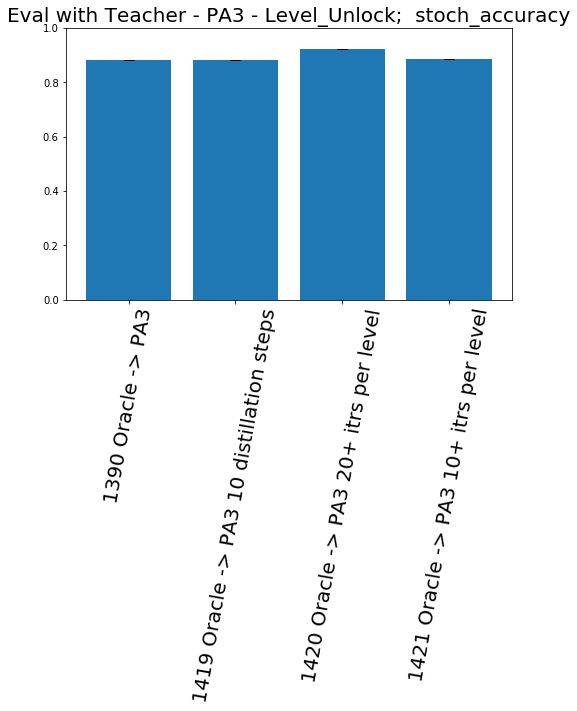

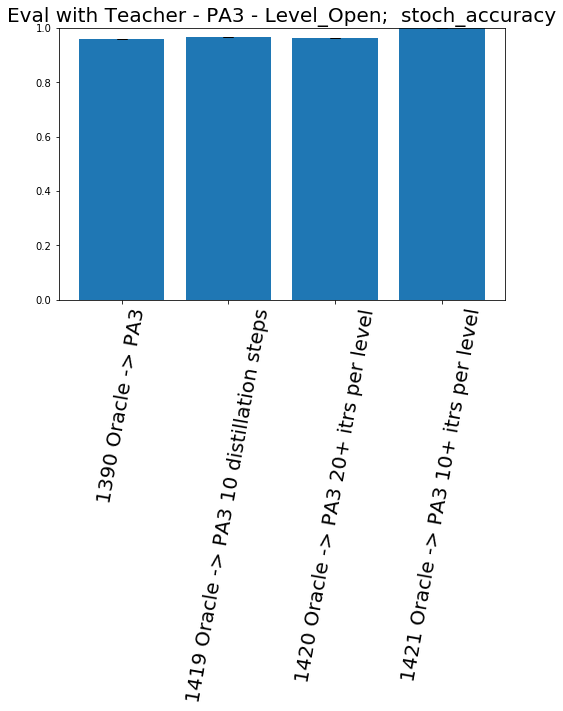

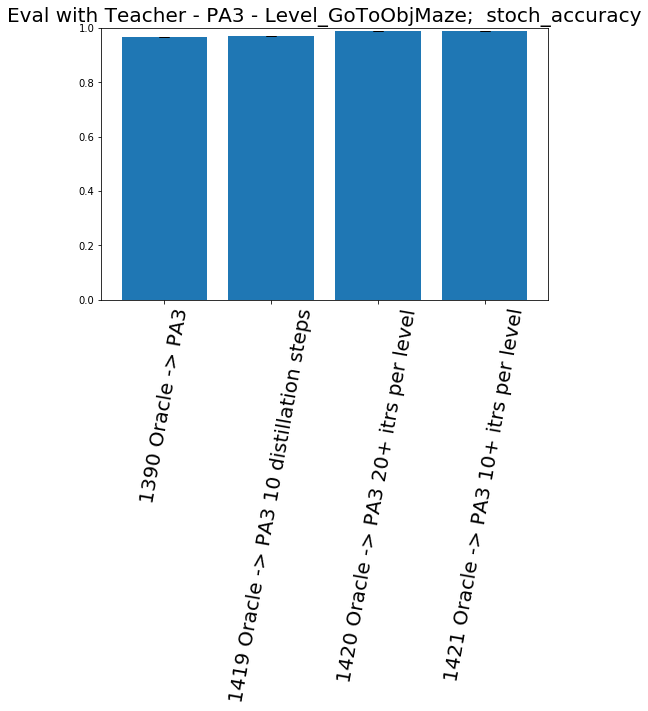

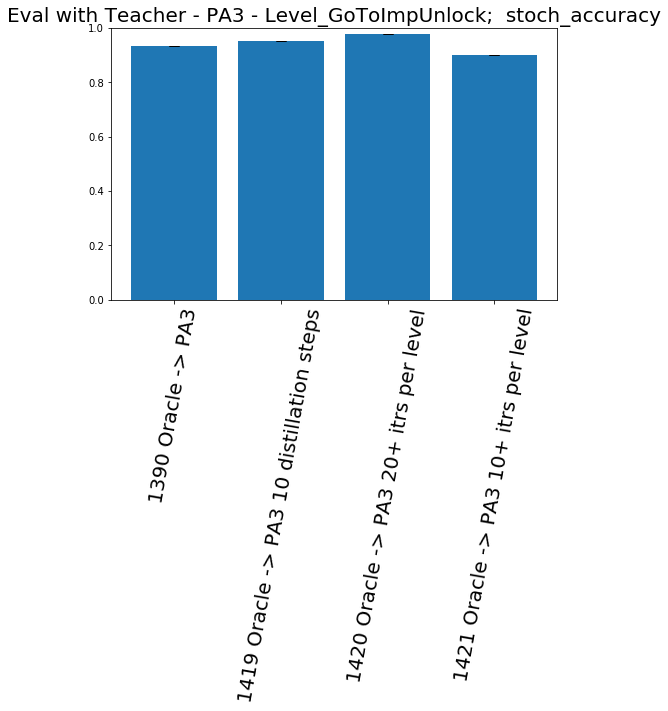

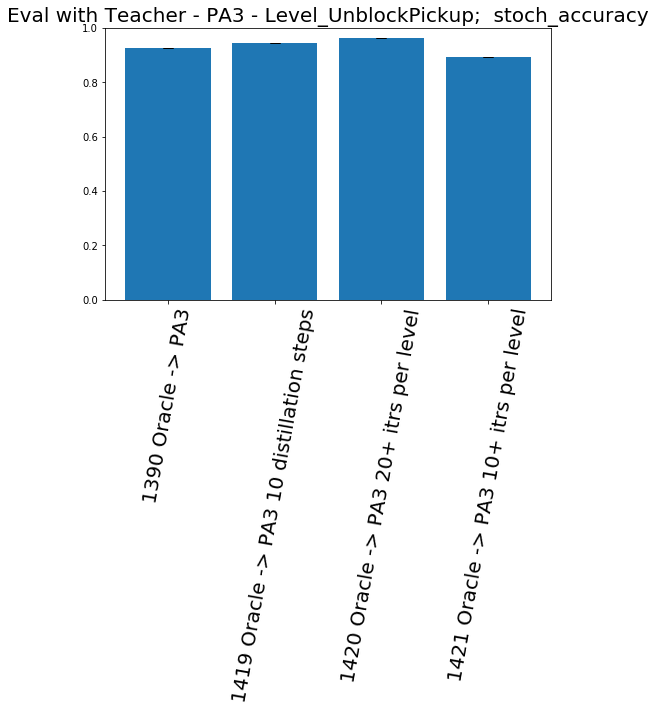

In [132]:
runs = [
#     (['T1372'], 'Unlock finetune'),
    (['T1438'], '1390 Oracle -> PA3'),
    (['T1439'], '1419 Oracle -> PA3 10 distillation steps'),
    (['T1440'], '1420 Oracle -> PA3 20+ itrs per level'),
    (['T1441'], '1421 Oracle -> PA3 10+ itrs per level'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA3')
print("=" * 1000)
plot_final_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')

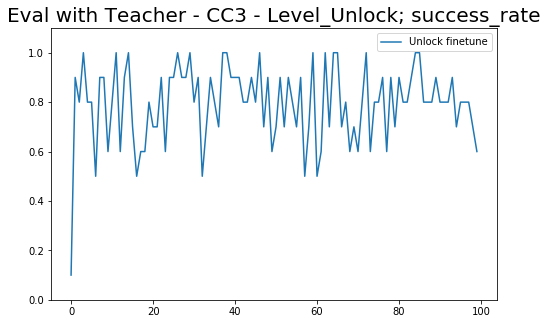

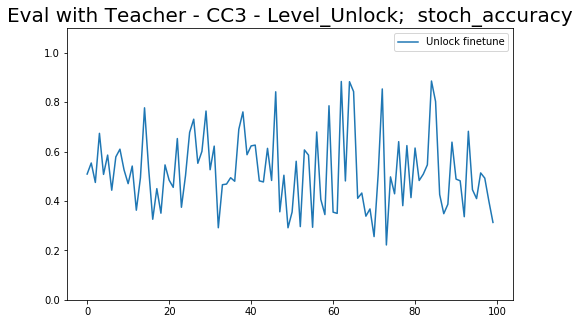

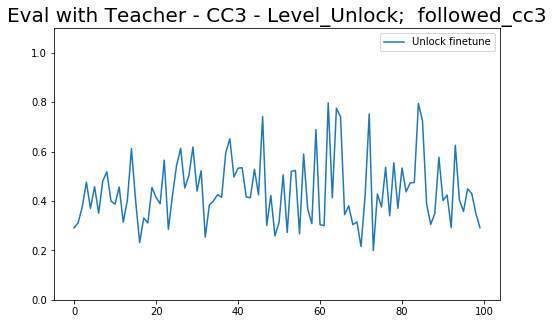

In [119]:
runs = [
#     (['EVAL_1361_FINETUNE_10ITRS_INSTRS'], '1361 INSTRS'),
#     (['EVAL_1361_FINETUNE_10ITRS_NOINSTRS_FNI'], '1361 NO INSTRS'),
#     (['EVAL_1361_FINETUNE_10ITRS_NOINSTRS_GOODLOG'], '1361 NO INSTRS GOODLOG'),
    (['T1372'], 'Unlock finetune'),
#     (['T1373'], 'Open finetune'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - CC3')
# print("=" * 1000)
plot_finetune_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')
# print("=" * 1000)
plot_finetune_generalization(runs, 'Eval with Teacher - CC3', ' followed_cc3')

## <font color='purple'> [HELPER] Does removing instructions help generalization?</font>

Conclusion: No significant difference. Even with Subgoals, where it sometimes helped, I think it's just b/c that run went longer! We could continue the existing runs to check that though.

In [26]:

runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_579', 'EVAL_580'], 'PA_I'),
    (['EVAL_543', 'EVAL_544'], 'CC2'),
    (['EVAL_581', 'EVAL_582'], 'CC2_I'),
    (['EVAL_545', 'EVAL_546'], 'CC3'),
    (['EVAL_597', 'EVAL_598'], 'CC3_I'),
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_599', 'EVAL_600'], 'SUB_I'),
]

plot_final_generalization(runs, 'Train + Eval with NO INSTRS')

Error on  ['EVAL_539', 'EVAL_540'] No files found with name EVAL_539
Error on  ['EVAL_579', 'EVAL_580'] No files found with name EVAL_579
Error on  ['EVAL_543', 'EVAL_544'] No files found with name EVAL_543
Error on  ['EVAL_581', 'EVAL_582'] No files found with name EVAL_581
Error on  ['EVAL_545', 'EVAL_546'] No files found with name EVAL_545
Error on  ['EVAL_597', 'EVAL_598'] No files found with name EVAL_597
Error on  ['EVAL_547', 'EVAL_548'] No files found with name EVAL_547
Error on  ['EVAL_599', 'EVAL_600'] No files found with name EVAL_599
ENV DICT dict_keys([])


# <font color='green'> Claim 3: Training with teacher + distilling few-shot generalizes to new levels faster. </font> <font color='red'> [TODO: code this up] </font>

## <font color='green'> [Status: Work in Progress. No results yet.] </font>

# <font color='blue'> Claim 4: Lower-level communication is more efficient to ground.</font>

## <font color='blue'> [Status: Definitely true, but no plots to show it yet.] </font>

## <font color='blue'>[STATUS] </font>

The goal is to motivate why we want to bootstrap rather than using the higher-level teachers directly.

This is true from what we've seen so far. We could probably show this in a graph by training an agent (either on the start of the curriculum or on a certain level), and checking periodically whether it can solve the held-out levels. The easy teachers should be able to do this more quickly than the harder teachers.

# <font color='purple'> Claim 5: Higher level communication is most feedback-efficient on new levels once grounded. </font>

## <font color='purple'> [Status: Hints this is true at the end of curriculm learning. We haven't yet seen it in held-out levels.] </font>


The goal is to motivate why we want higher-level teachers at all.

In theory, the generalization exps (claim 3) should show this.

# <font color='green'> Claim 6: We can ground higher-level feedback using lower-level feedback and minimal use of the reward. This is more efficient than grounding the higher-level communication directly. </font>

## <font color='green'> [Status: Self-distill > Bootstrap > Train directly] </font> <font color='red'> </font>


Goal is to show that bootstrapping is a reasonable thing to do.

May also help with grounding harder teachers better.

TODO

## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (NO distillation) </font>
### (a) Train on higher-level teacher directly
### (b) Train with easy teacher, distill to higher-level teacher
### (c) Start training on easy teacher, then distill from easy to higher-level teacher, than train with higher-level teacher

In all cases, the agent advances to the next curriculum level when it can perform well on the highest-level teacher currently provided.

Length 301
Length 2341
Length 1371
Error tokenizing data. C error: Expected 76 fields in line 3, saw 94

Length 1248
Length 2096
Length 1201
Length 1081


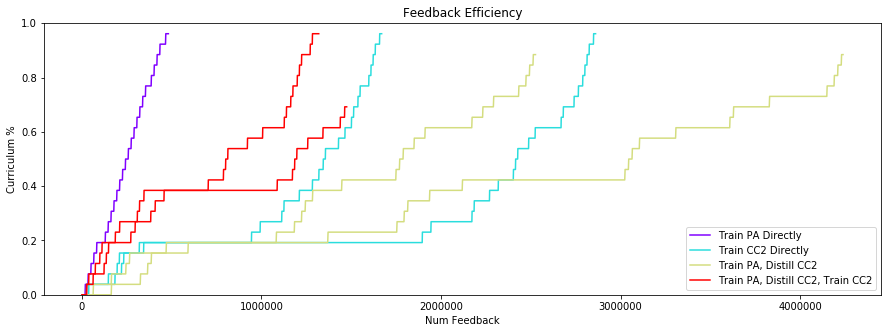

Length 301
Length 4091
Length 3681
Length 2925
Length 7735
Error tokenizing data. C error: Expected 76 fields in line 3, saw 94

Error tokenizing data. C error: Expected 76 fields in line 3, saw 94

Length 2400
Length 1884
Length 2070
Length 2521


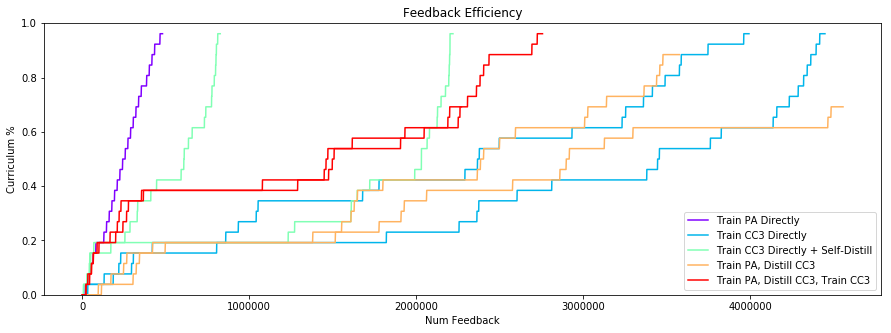

Length 301
Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Length 6748
Length 8364
Length 8258
Length 8992
[Errno 2] No such file or directory: 'meta-mb-internal/old_data/T0561_CURRICULUM1_PRE_to_SUB_ADVTEACH_teacherPreActionAdvice, SubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1/progress.csv'
Error tokenizing data. C error: Expected 76 fields in line 3, saw 94

Length 2950
Length 2932
Length 9601


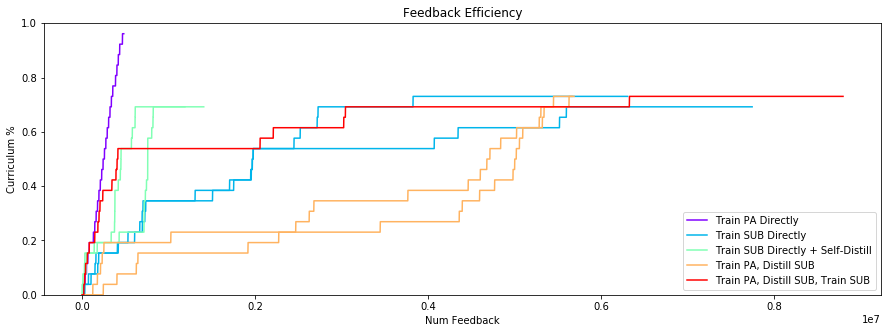

In [27]:
data_names = [
    (['0540'], 'Train PA Directly'),
#     (['0539', '0540'], 'Train PA Directly'),
    (['0543', '0544'], 'Train CC2 Directly'),
    (['0557', '0558'], 'Train PA, Distill CC2'),
    (['637', '638'], 'Train PA, Distill CC2, Train CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0545', '0546'], 'Train CC3 Directly'),
    (['682', '683'], 'Train CC3 Directly + Self-Distill'),
    (['0559', '0560'], 'Train PA, Distill CC3'),
    (['639', '640'], 'Train PA, Distill CC3, Train CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0547', '0548'], 'Train SUB Directly'),
    (['684', '685'], 'Train SUB Directly + Self-Distill'),
    (['0561', '0562'], 'Train PA, Distill SUB'),
    (['641'], 'Train PA, Distill SUB, Train SUB'),
]
plot_curriculum(data_names, 'feedback')


## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (YES distillation) </font>

Length 4666
Length 18091
Length 6553
Length 5445


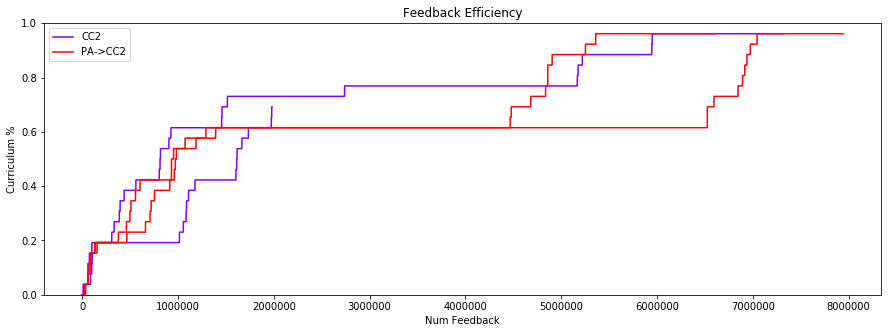

Length 1707
Length 7155
Length 7736
Length 3675


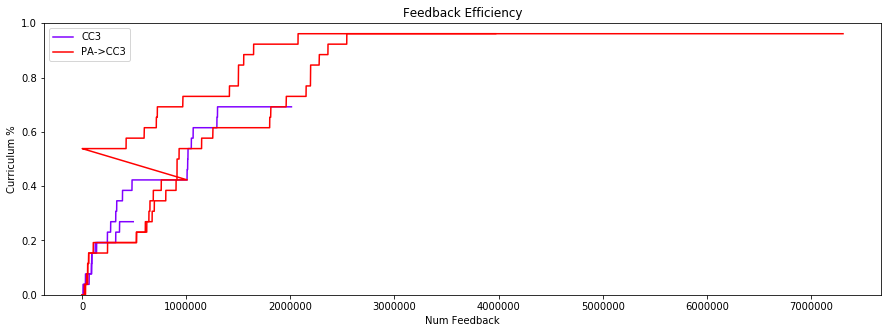

Length 2272
Length 9938
Length 18507
Length 15932


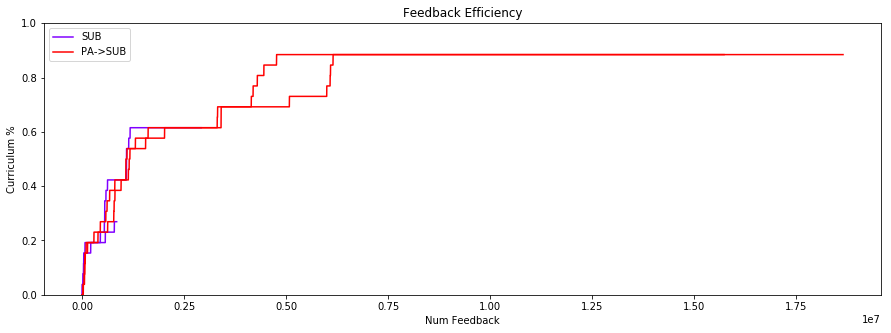

In [28]:
data_names = [
    (['0631', '0632'], 'CC2'),
    (['T0729_PRE_to_CC2', '728'], 'PA->CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['0666', '0667'], 'PA->CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['0668', '0669'], 'PA->SUB'),
]
plot_curriculum(data_names, 'feedback')

# <font color='blue'> Claim 8: we can (largely) remove the reward during training once the first teacher is grounded.  </font> 

## <font color='blue'> [Status: Early results show it helps for PA, not SUB].  </font> 

Let's test this by taking PA (the easiest teacher to learn) and seeing at what point during training it can zero-shot solve the entire curriculum.

## <font color='blue'> [Helper] See how early through the curriculum we can remove the reward. </font>

Currently suggests there's no one point where the reward can be removed; we need to keep checking it it and training if needed.

In [29]:
runs = [
    (['EVAL_ALL_LEVELS_627'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_ALL_LEVELS_627'] No files found with name EVAL_ALL_LEVELS_627


In [30]:
runs = [
    (['EVAL_PA_EARLY_FINAL_455'], 'PA'),
    (['EVAL_PA_EARLY_455_mid'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_PA_EARLY_FINAL_455'] No files found with name EVAL_PA_EARLY_FINAL_455
Error on  ['EVAL_PA_EARLY_455_mid'] No files found with name EVAL_PA_EARLY_455_mid


## <font color='blue'> [Helper] See if we can zero-shot some levels. </font>

Length 301
Length 99


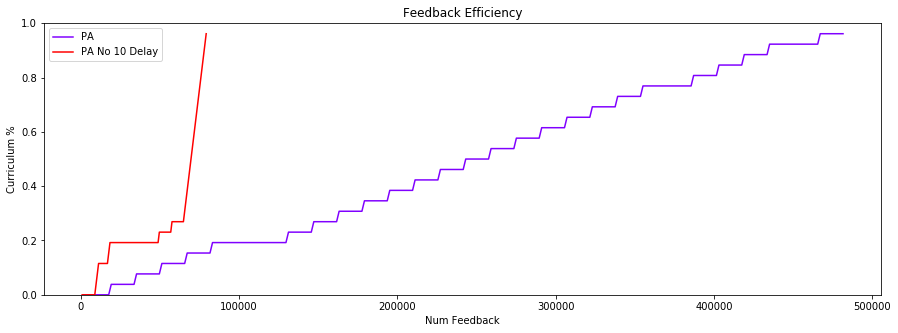

In [31]:
data_names = [
    (['0540'], 'PA'),
    (['676'], 'PA No 10 Delay'),
#     (['677', '678'], "PA Don't train each level"),  # TODO: This one doesn't actually skip training on some levels
]
plot_curriculum(data_names, 'feedback')

## <font color='blue'> [Main] Remove reward during training when possible </font>

Tries reward periodically. If the agent succeeds, we skip training for the next few itrs.

NOTE: Would probably make more sense to separate sparse vs per-timestep rewards. Only provide per-timestep rewards if the agent is failing at getting the sparse rewards.

Length 2436
Length 3335
Length 1809
Length 5030


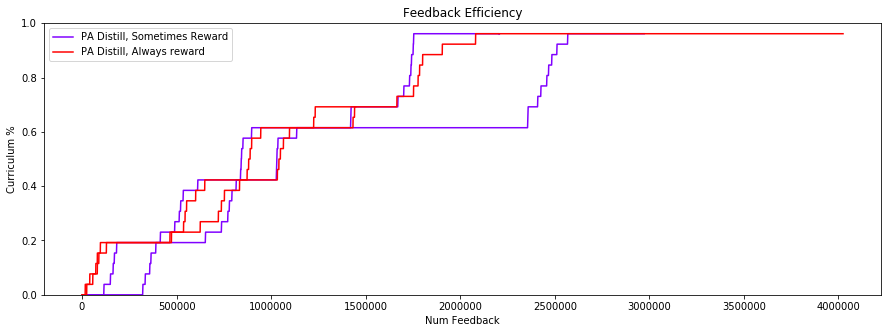

Length 2435
Length 3335
Length 1809
Length 5030


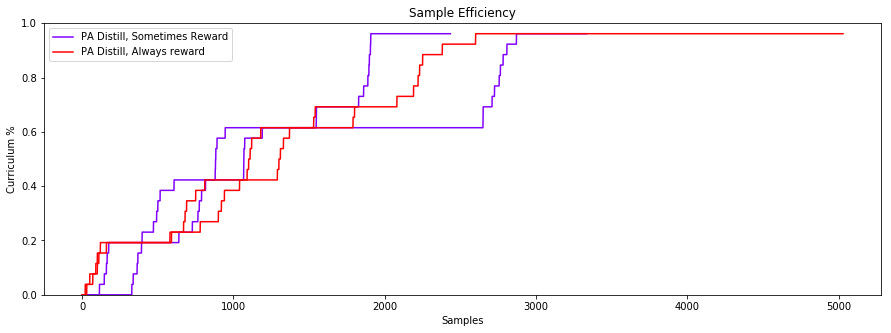

In [32]:
data_names = [
    (['0729_PA', '0730'], 'PA Distill, Sometimes Reward'),
    (['0627', '0628'], 'PA Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

Length 4698
Length 4615
Length 18507
Length 15932


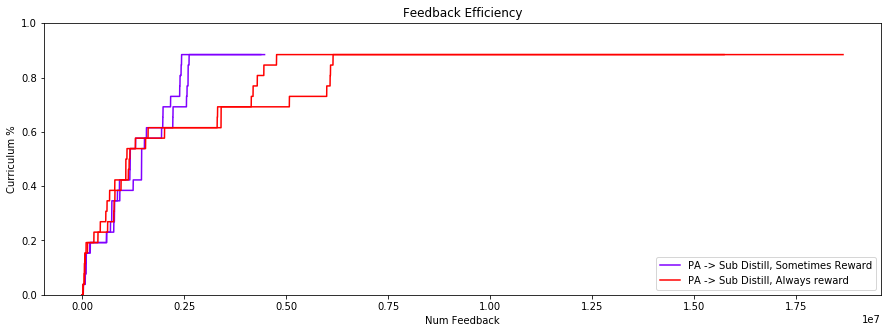

Length 7761
Length 7939
Length 18531
Length 15956


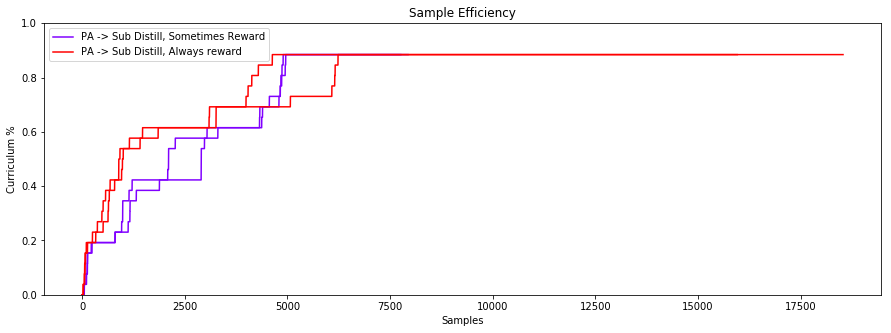

In [33]:
data_names = [
    (['735', '736'], 'PA -> Sub Distill, Sometimes Reward'),
    (['668', '669'], 'PA -> Sub Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

# <font color='purple'> Leaderboard - Curriculum Learning  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

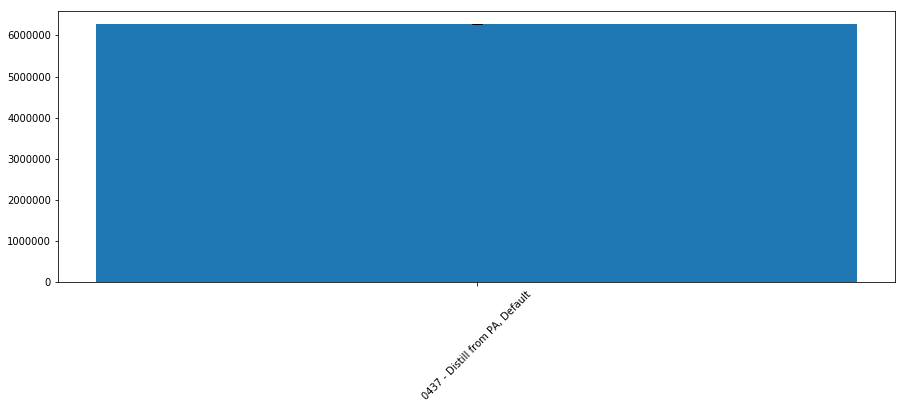

In [34]:
methods = [
    (['0437'], "Distill from PA, Default", "Standard HParams, train PA, distill to powerset"), # TODO: placeholder; hasn't actually succeeded yet
]

plot_leaderboard(methods)


# <font color='green'> Leaderboard - Curriculum Learning (no distillation)  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77



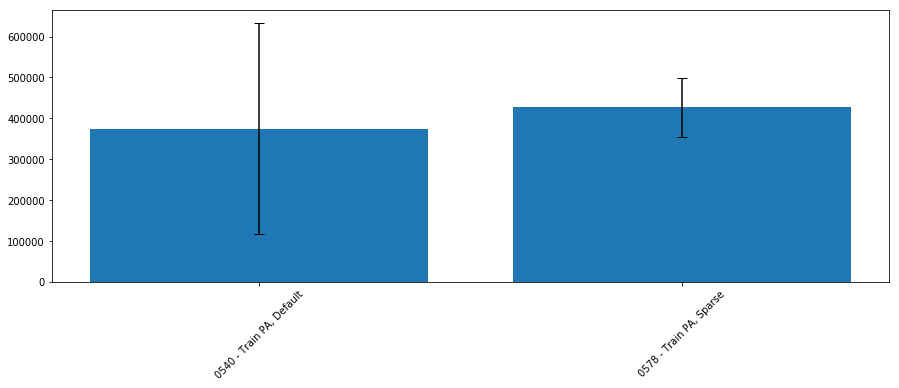

In [35]:
methods = [
    (['0539', '0540'], "Train PA, Default", "Standard HParams, train PA"),
    (['0577', '0578'], "Train PA, Sparse", "Standard HParams, train PA"),
]

plot_leaderboard(methods)


# <font color='blue'> Leaderboard - Few-Shot Generalization </font>


Keep track of the current best methods of few-shot learning heldout levels (ranked by feedback-efficiency).

TODO

# <font color='purple'> Miscellaneous Other Plots </font> <font color='red'> [TODO: plot sweeps] </font>

## <font color='purple'> Does bigger batch size help? </font>

Conclusion: It helps when subgoals not distilling, but doesn't help when distilling. We should check whether this holds for other teachers.

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Length 6748
Length 8364
Length 5512
Length 4502
Length 5971
Length 3931


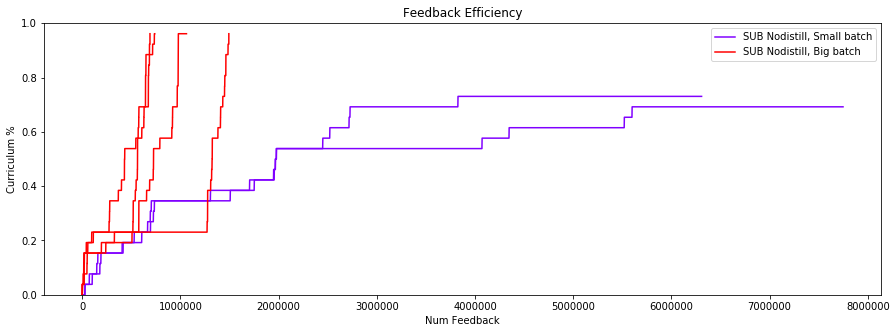

Length 31882
Length 13692
Length 9938
Length 2272
Length 23456
Length 16897


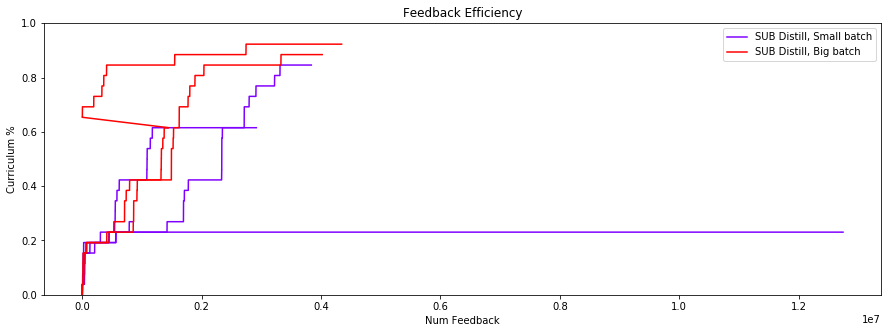

Length 8820
Length 8576
Length 18507
Length 15932
Length 8025
Length 11028
Length 12412


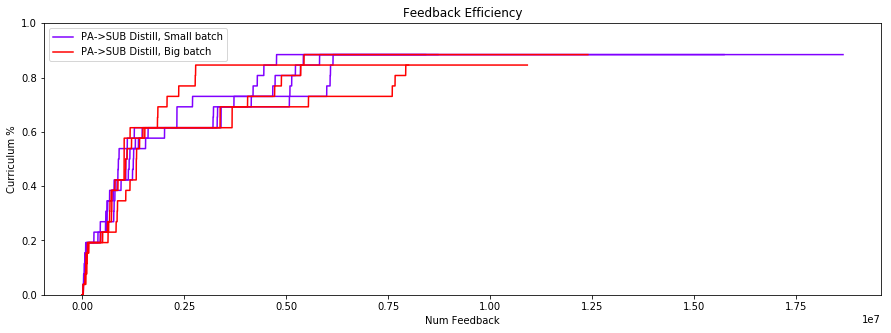

In [36]:
data_names = [
    (['0547', '0548'], 'SUB Nodistill, Small batch'),
    (['0722', '0723', '688'], 'SUB Nodistill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small batch'),
    (['690'], 'SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small batch'),
    (['726', '725', '724'], 'PA->SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')



### No distillation

Length 301
Length 139
Length 97


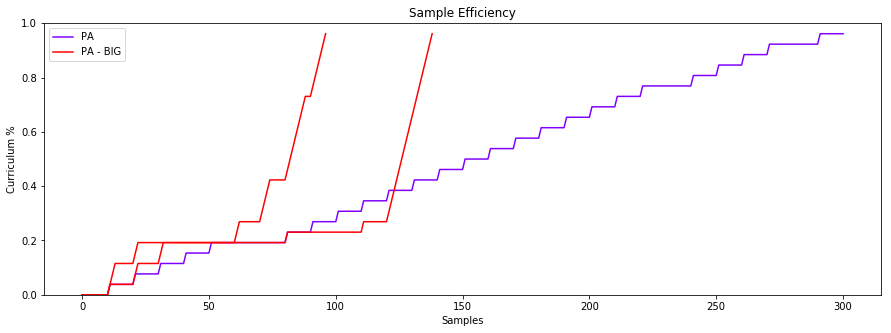

Length 2341
Length 1371
Length 3472
Length 6984


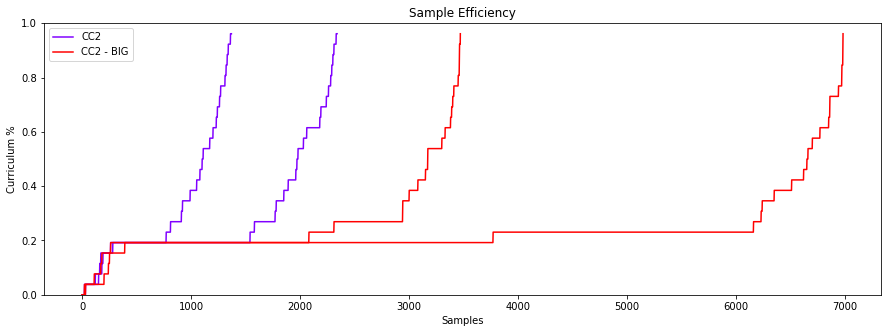

Length 4091
Length 3681
Length 2372
Length 4241


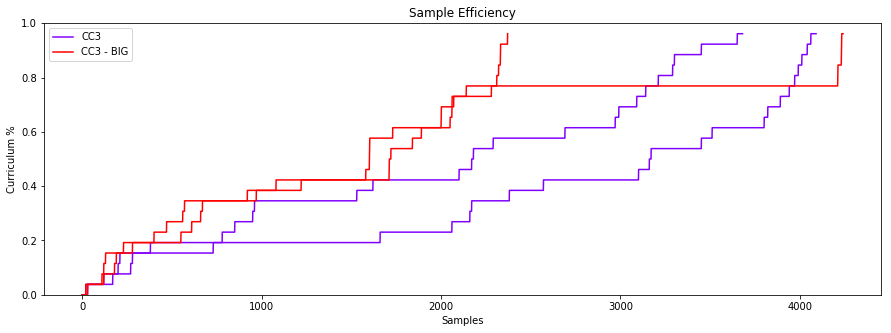

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Length 6748
Length 8364
Length 5971
Length 3931


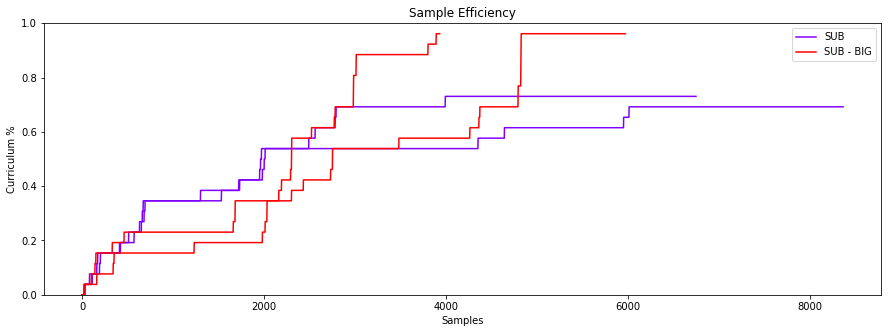

In [37]:
# NO DISTILLATION

data_names = [
    (['0540'], 'PA'),
    (['692', '693'], 'PA - BIG'),
]
plot_curriculum(data_names, 'samples')  # WORSE

data_names = [
    (['0543', '0544'], 'CC2'),
    (['694', '695'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0545', '0546'], 'CC3'),
    (['696', '697'], 'CC3 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0547', '0548'], 'SUB'),
    (['688'], 'SUB - BIG'),
]
plot_curriculum(data_names, 'samples')


### Distillation

Length 1809
Length 5030
Length 2922
Length 2950


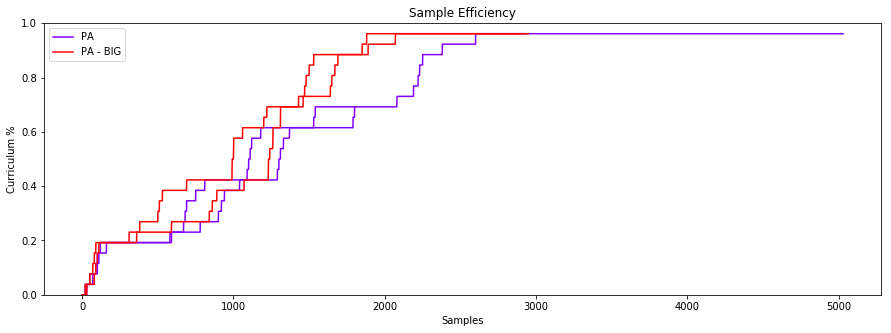

Length 4666
Length 18091
Length 3785
Length 3560


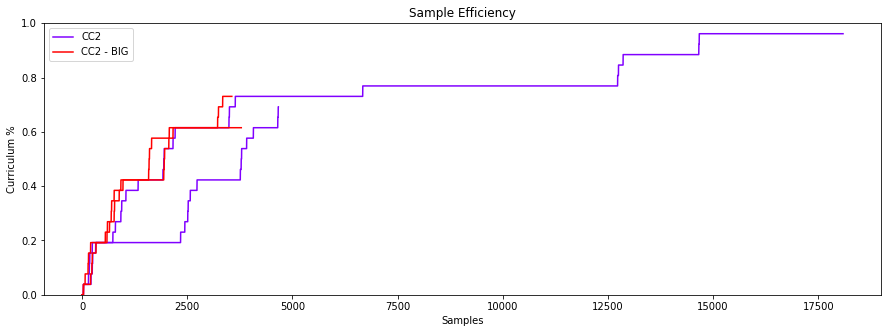

Length 1707
Length 7155
Length 15954
Length 13021


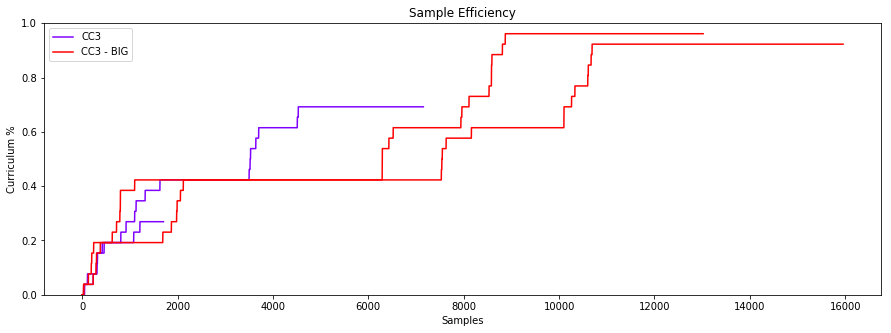

Length 2272
Length 9938
Length 23482
Length 16921


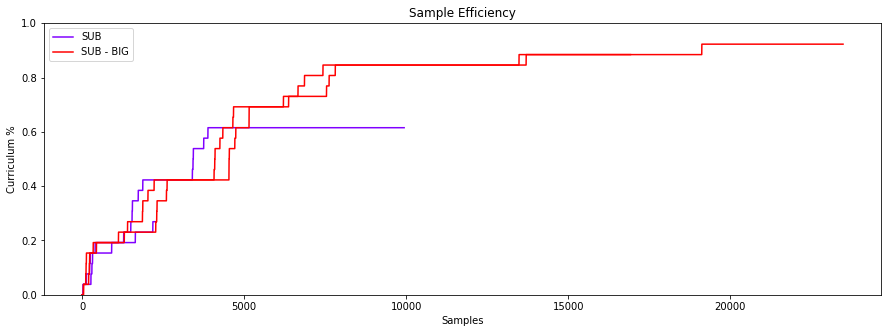

In [38]:
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
    (['698', '699'], 'PA - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0631', '0632'], 'CC2'),
    (['700', '701'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['702', '703'], 'CC3 - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['690'], 'SUB - BIG')
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does a bigger model help? </font>

Helps a little bit...

Length 31882
Length 13692
Length 9938
Length 2272
Length 11063
Length 9458
Length 25655


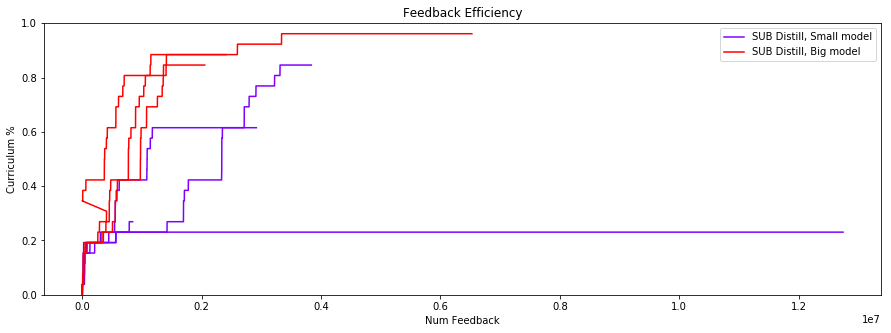

Length 8820
Length 8576
Length 18507
Length 15932
Length 8415
Length 8806


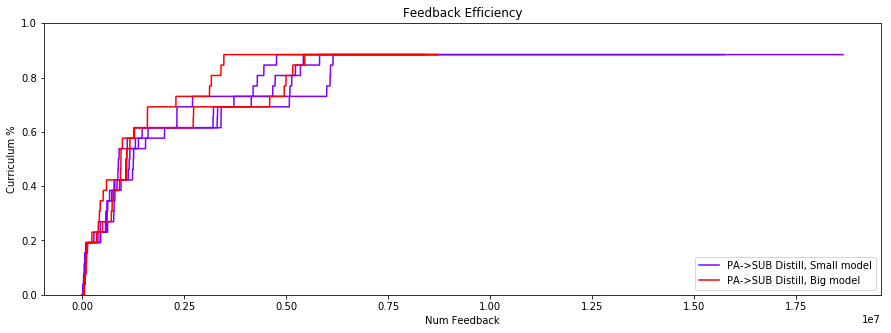

In [39]:
# data_names = [
#     (['0547', '0548'], 'SUB Nodistill, Small model'),
#     (['0722', '0723', '688'], 'SUB Nodistill, Big model'),
# ]
# plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small model'),
    (['714', '715', '664'], 'SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small model'),
    (['716', '717'], 'PA->SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does self-distillation help? </font>

Length 139
Length 97
Length 136
Length 89


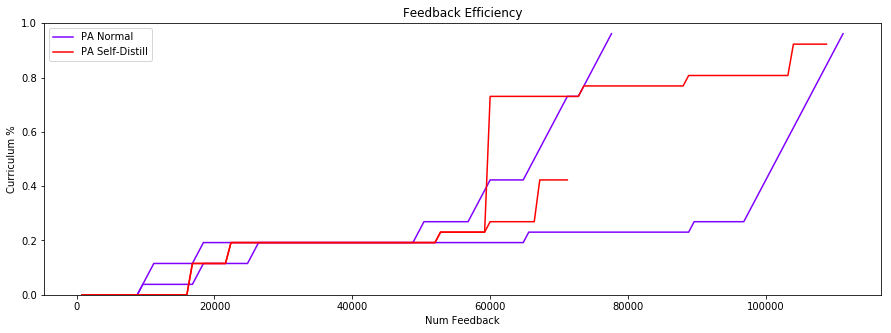

Length 2341
Length 1371
Length 3565
Length 1175


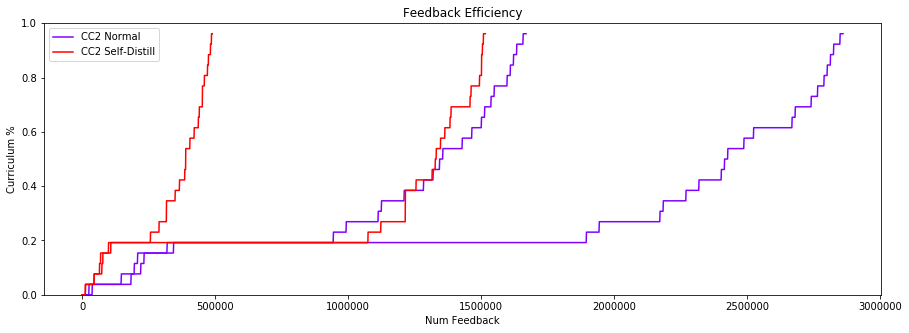

Length 4091
Length 3681
Length 2925
Length 7735


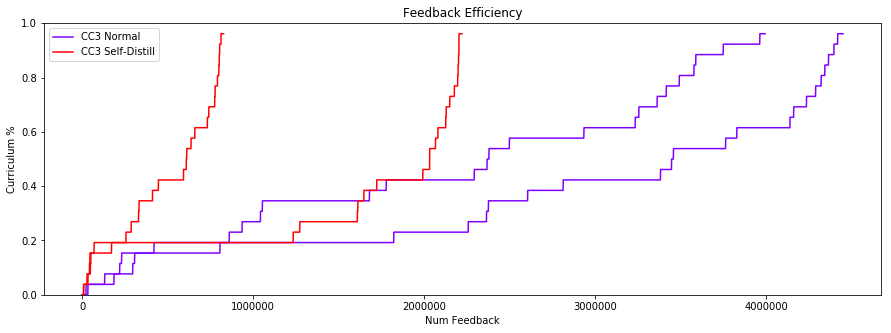

Length 5512
Length 4502
Length 5971
Length 3931
Length 8258
Length 8992


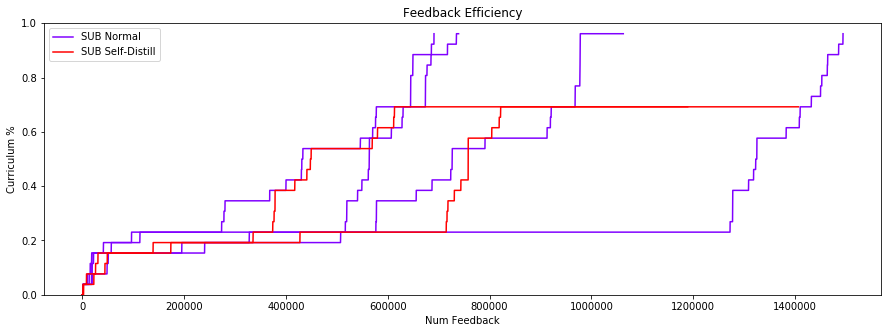

In [40]:
data_names = [
    (['692', '693'], 'PA Normal'),
    (['0706', '0707'], 'PA Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0543', '0544'], 'CC2 Normal'),
    (['0704', '0705'], 'CC2 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0545', '0546'], 'CC3 Normal'),
    (['682', '683'], 'CC3 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0722', '0723', '688'], 'SUB Normal'),
    (['684', '685'], 'SUB Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does buffer size help?  </font>

## <font color='purple'> Does raising the RL accuracy threshold size help?  </font>

Length 1809
Length 5030
Length 447
Length 3171


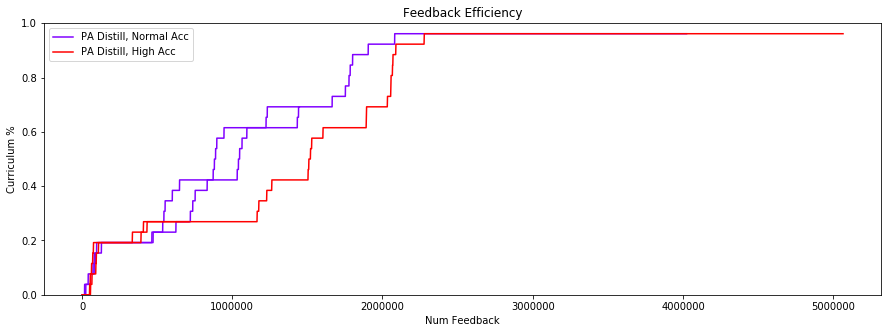

Length 7736
Length 3675
Length 5061
Length 1021


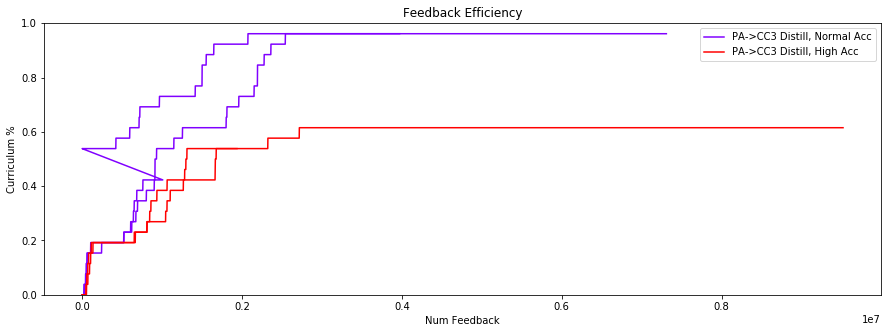

Length 8820
Length 8576
Length 18507
Length 15932
Length 376
Length 4362


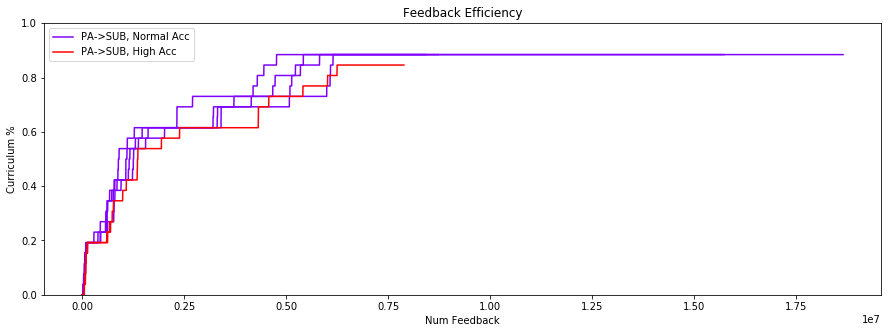

In [41]:
data_names = [
    (['0627', '0628'], 'PA Distill, Normal Acc'),
    (['0737', '0738'], 'PA Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0666', '0667'], 'PA->CC3 Distill, Normal Acc'),
    (['0739', '0740'], 'PA->CC3 Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Acc'),
    (['0741', '0742'], 'PA->SUB, High Acc'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does lowering the discount help?  </font>

Length 8820
Length 8576
Length 18507
Length 15932
Length 3284
Length 2578


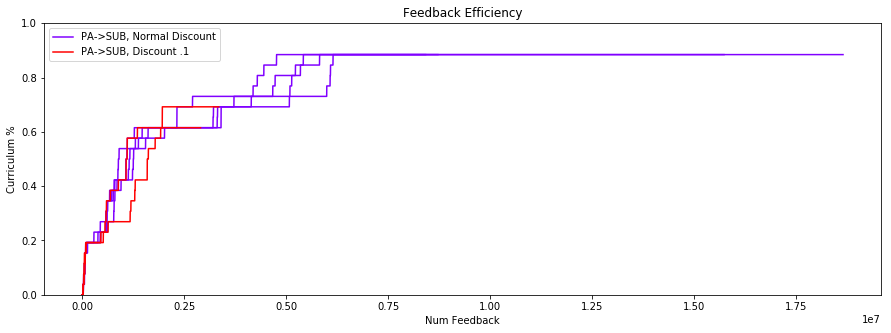

In [42]:
data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Discount'),
    (['743', '744'], 'PA->SUB, Discount .1'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does the way we collect labels matter?  </font>

Length 6026
Length 6802
Length 1479
Length 1755
Length 1587
Length 1296
Length 1825
Length 2218


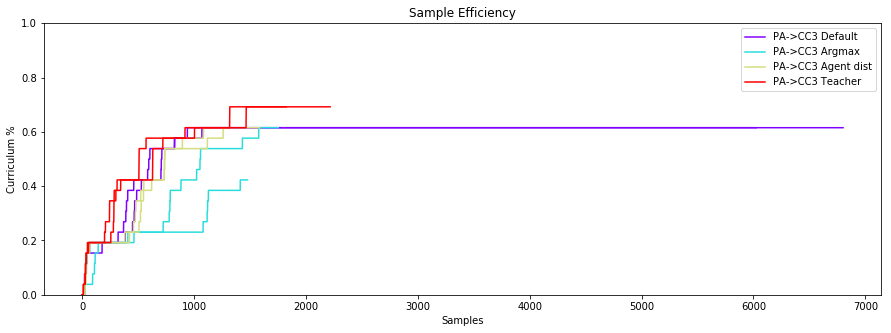

In [43]:
data_names = [
    (['0821', '0822'], 'PA->CC3 Default'),
#     (['0825', '0826'], 'PA->CC3 Big Batch'),
    (['833', '834'], 'PA->CC3 Argmax'),
    (['835', '836'], 'PA->CC3 Agent dist'),
    (['837', '838'], 'PA->CC3 Teacher'),
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does DAgger help?  </font>

Length 1236
Length 955
Length 3524
Length 2588


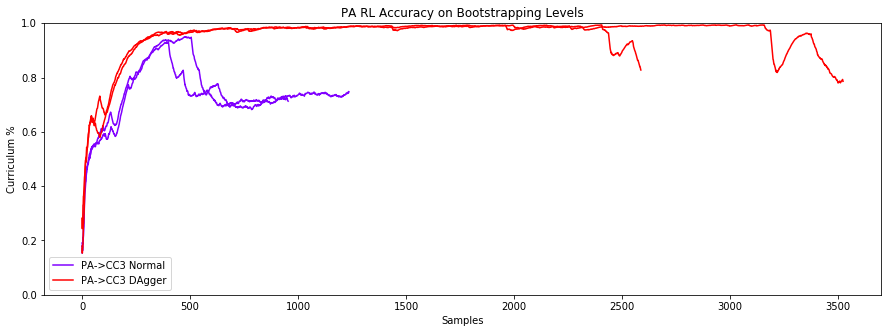

Length 1236
Length 955
Length 3524
Length 2588


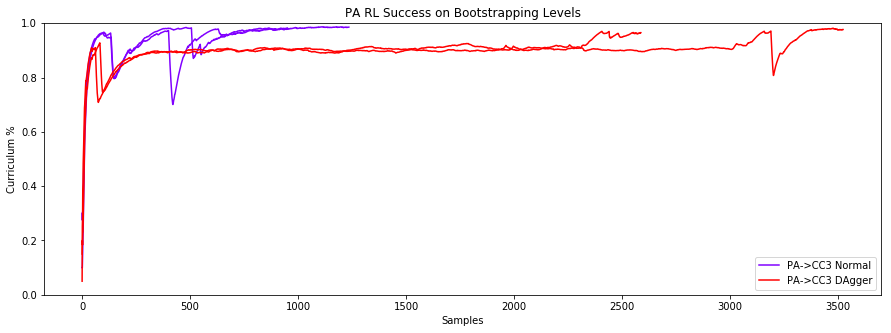

Length 3835
Length 3576
Length 5141
Length 5776


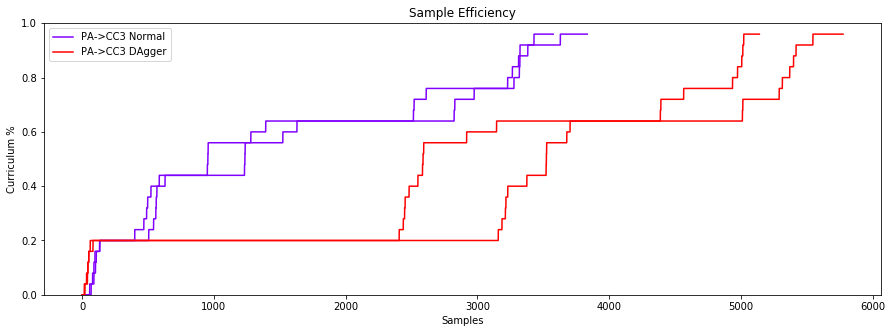

Length 1236
Length 955
Length 3524
Length 2588


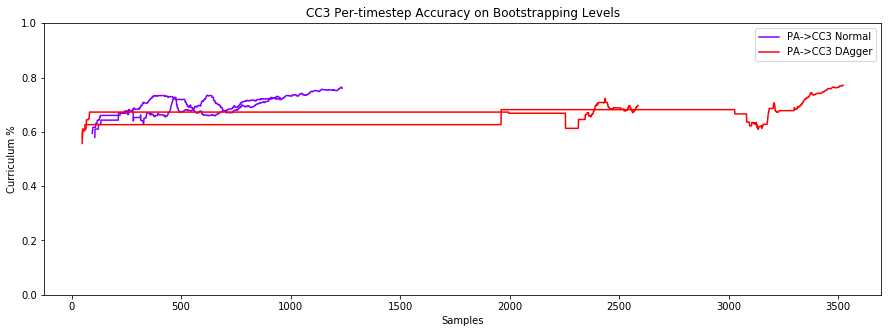

'Rollout/CartesianCorrectionsAvgAccuracy'
couldn't plot PA->CC3 Normal
Length 3524
Length 2588


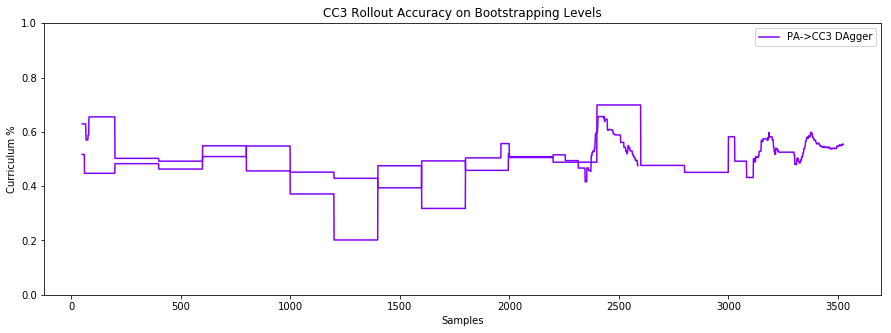

'Rollout/CartesianCorrectionsAverageSuccess'
couldn't plot PA->CC3 Normal
Length 3524
Length 2588


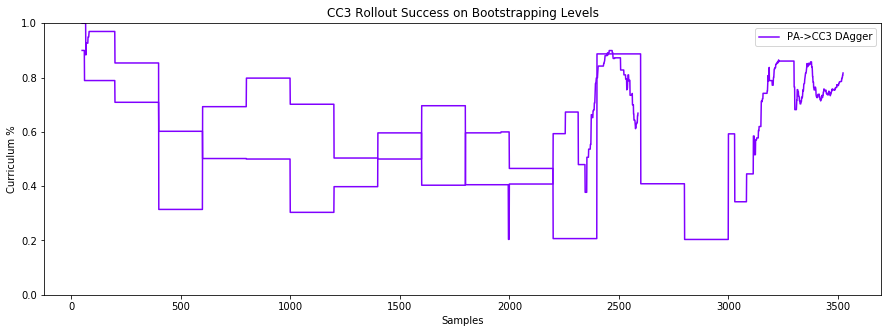

'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA->CC3 Normal
Length 3524
Length 2588


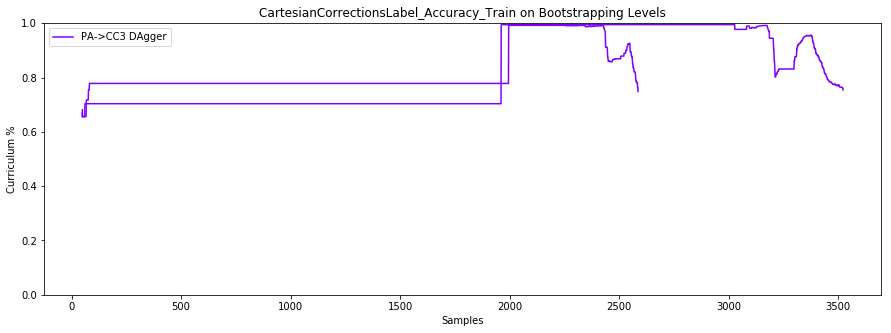

'Distill/CartesianCorrectionsLabel_Accuracy_Val'
couldn't plot PA->CC3 Normal
Length 3524
Length 2588


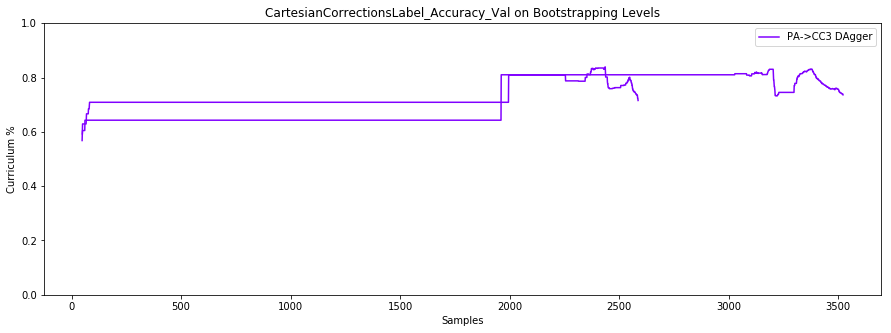

In [44]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0943', '0944'], 'PA->CC3 Normal'),
    (['0993', '0994'], 'PA->CC3 DAgger'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Success', smooth=100, 
                level_start=0, level_end=12, title="PA RL Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

## <font color='purple'> Does using a separate model help?  </font>

Length 6138
Length 5396
Length 3476
Length 3833


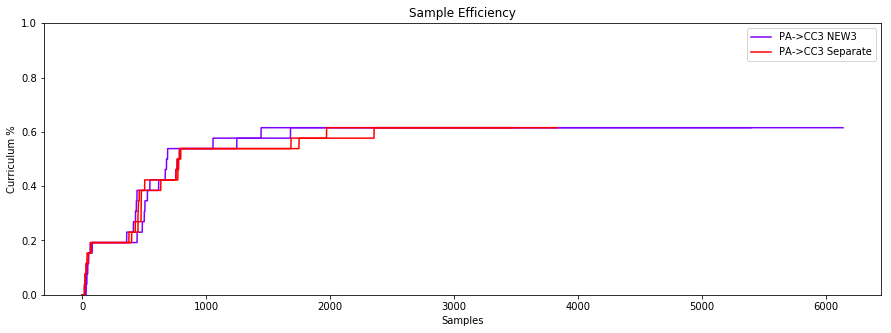

In [45]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['839', '840'], 'PA->CC3 Separate'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Does re-weighting help?  </font>

Length 6138
Length 5396
Found multiple files with name 180: ['T1180_PA_to_CC3_teacherPreActionAdviceCartesianCorrections_SD_threshS1_threshAR0.6_threshAD0.95_lr0.0001_ent0.0001_1', "T0180_DISTILLONLY_AGENT_teacher['PreActionAdvice']_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1"]
couldn't plot PA->CC3 Re-Weight
Length 1798
Length 1934


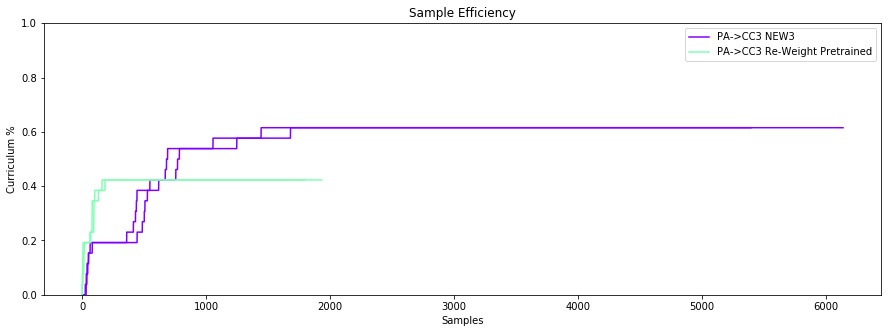

Length 5306
Length 6153
Length 1826
Length 1725
Length 2452
Length 2893


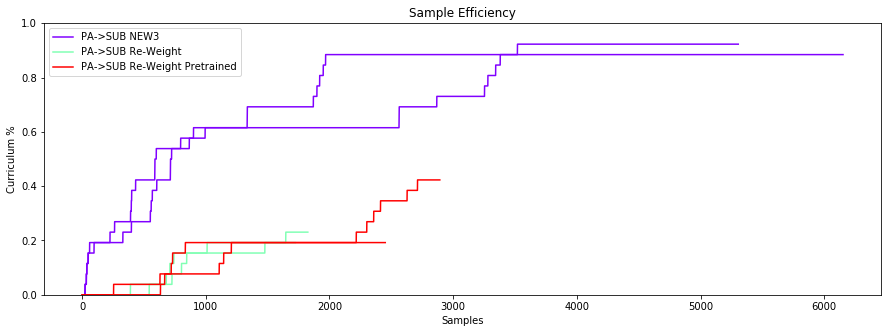

In [46]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['817', '180'], 'PA->CC3 Re-Weight'),
    (['813', '814'], 'PA->CC3 Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['819', '820'], 'PA->SUB Re-Weight'),
    (['815', '816'], 'PA->SUB Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Hyperparameter tuning (included dropout and pretrained)  </font>

Length 1809
Length 5030
Length 4305
Length 2894
Length 1792
Length 1878
Length 3716
Length 3679


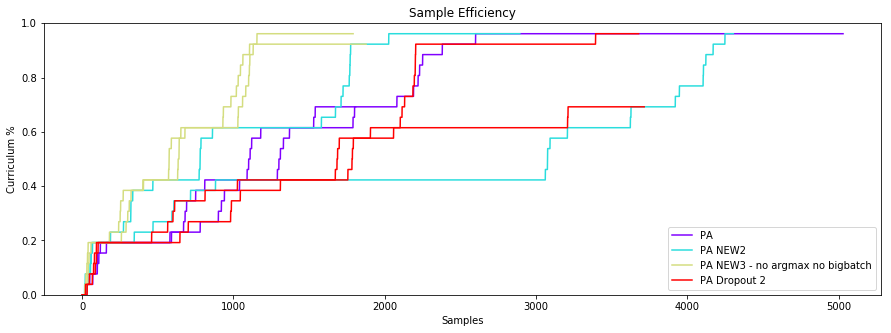

Length 7763
Length 3701
Length 4791
Length 9694
Length 6138
Length 5396
Length 6026
Length 6802
Length 4746
Length 14050
Length 2988
Length 1850


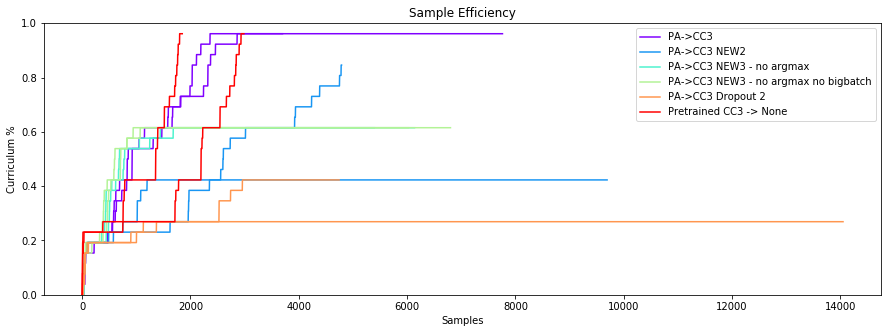

Length 18531
Length 15956
Length 9290
Length 9603
Length 5306
Length 6153
Length 6127
Length 6398
Length 3486
Length 4351


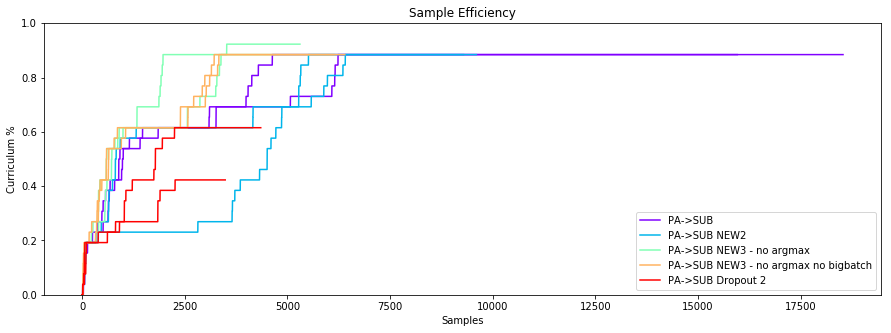

Length 11942
Length 3419
Length 3425
Length 32049
Length 27924


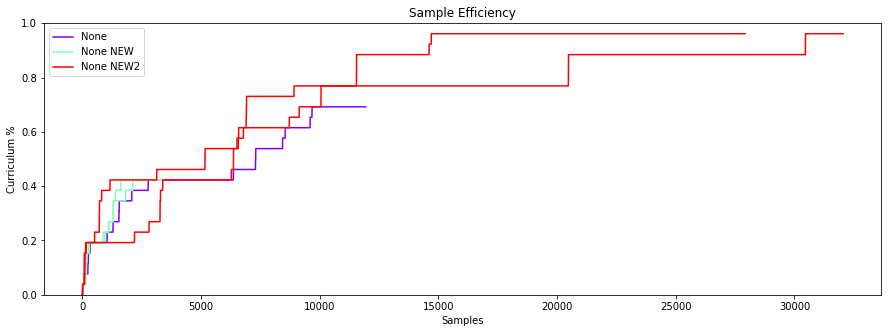

In [47]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0627', '0628'], 'PA'),
#     (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['867', '868'], 'PA NEW3 - no argmax no bigbatch'),
    (['801', '802'], 'PA Dropout 2'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0666', '0667'], 'PA->CC3'),
#     (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0825', '0826'], 'PA->CC3 NEW3 - no argmax'),
    (['0821', '0822'], 'PA->CC3 NEW3 - no argmax no bigbatch'),
    (['803', '804'], 'PA->CC3 Dropout 2'),
    (['859', '860'], 'Pretrained CC3 -> None'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0668', '0669'], 'PA->SUB'),
#     (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['827', '828'], 'PA->SUB NEW3 - no argmax'),
    (['0823', '0824'], 'PA->SUB NEW3 - no argmax no bigbatch'),
    (['805', '806'], 'PA->SUB Dropout 2'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')




Length 74
Length 86
Length 1809
Length 5030
Length 2450
Length 2282
Length 4305
Length 2894
Length 2722
Length 2551
Length 2681
Length 2618
Length 3716
Length 3679


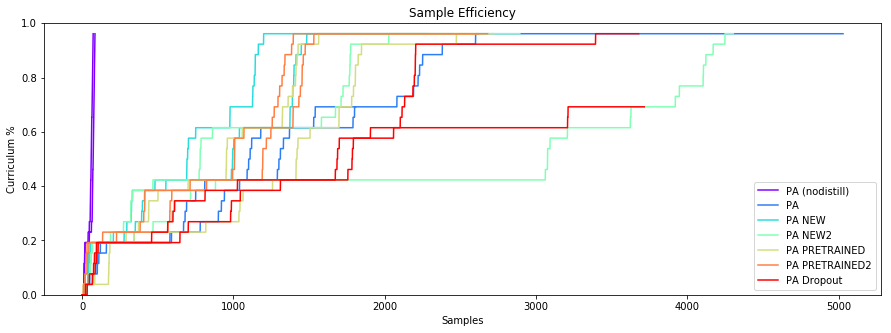

Length 74
Length 86
Length 1809
Length 5030
Length 2450
Length 2282
Length 4305
Length 2894
Length 2722
Length 2551
Length 2681
Length 2618
Length 3716
Length 3679


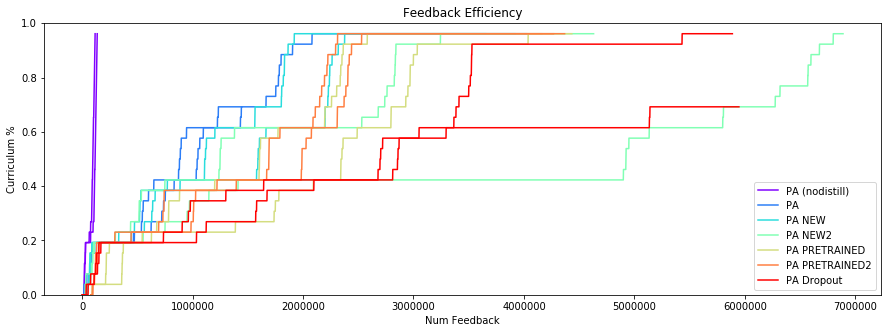

Length 1559
Length 1634
Length 7763
Length 3701
Length 5536
Length 6069
Length 4791
Length 9694
Length 4983
Length 5806
Length 4833
Length 3971
Length 4746
Length 14050


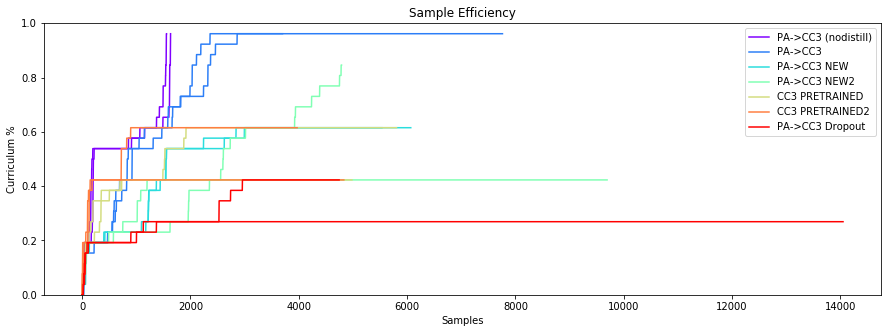

Length 1559
Length 1634
Length 7736
Length 3675
Length 5536
Length 6069
Length 4791
Length 9694
Length 4983
Length 5806
Length 4833
Length 3971
Length 4746
Length 14050


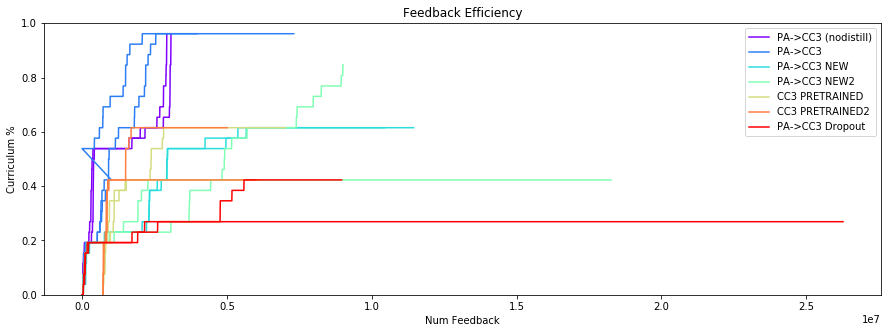

Length 11710
Length 5971
Length 18531
Length 15956
Length 5309
Length 11979
Length 9290
Length 9603
Length 9800
Length 7632
Length 7180
Length 6442
Length 3486
Length 4351


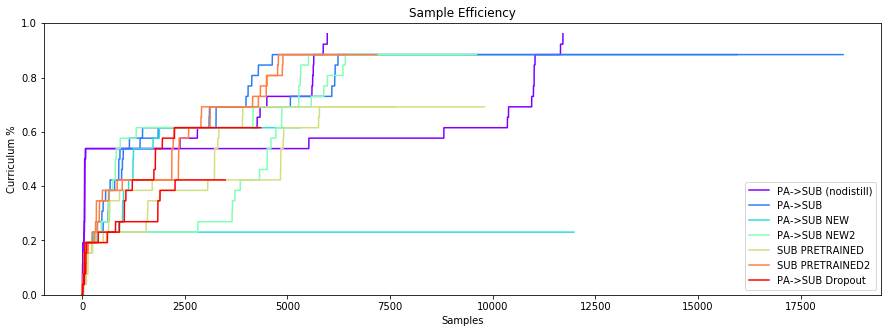

Length 11710
Length 5971
Length 18507
Length 15932
Length 5309
Length 11979
Length 9290
Length 9603
Length 9800
Length 7632
Length 7180
Length 6442
Length 3486
Length 4351


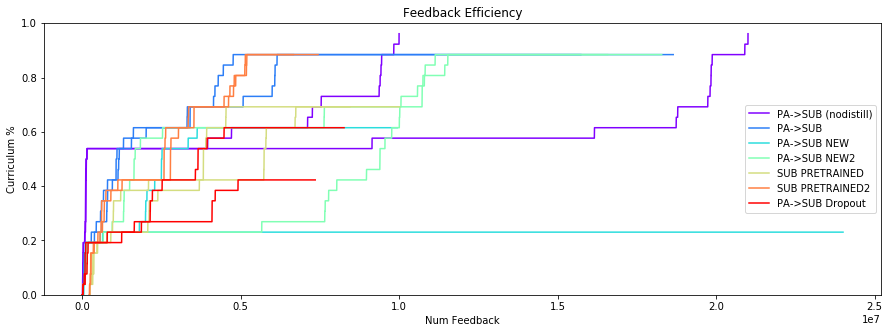

Length 946
Length 1162
Length 11942
Length 3419
Length 3425
Length 32049
Length 27924


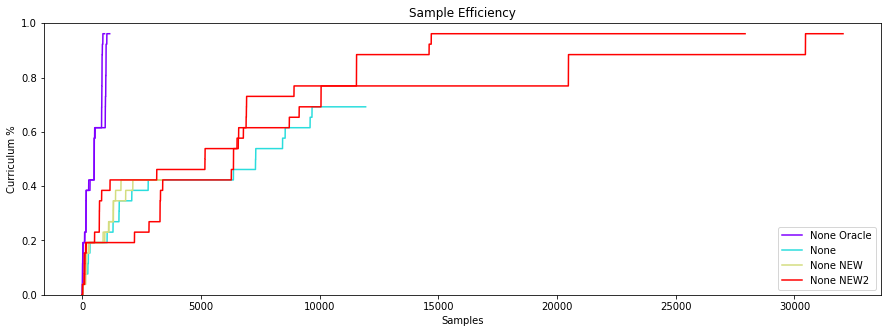

Length 946
Length 1162
Length 11942
Length 3419
Length 3425
Length 32049
Length 27924


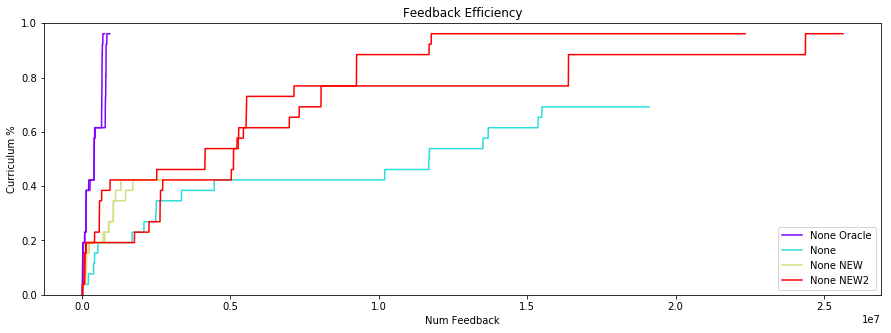

In [48]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [  # TODO: re-run these 
    (['0779', '0780'], 'PA (nodistill)'),
    (['0627', '0628'], 'PA'),
    (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['0759', '0760'], 'PA PRETRAINED'),
    (['0793', '0794'], 'PA PRETRAINED2'),
    (['801', '802'], 'PA Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0781', '0782'], 'PA->CC3 (nodistill)'),
    (['0666', '0667'], 'PA->CC3'),
    (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0761', '0762'], 'CC3 PRETRAINED'),
    (['0795', '0796'], 'CC3 PRETRAINED2'),
    (['803', '804'], 'PA->CC3 Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0783', '0784'], 'PA->SUB (nodistill)'),
    (['0668', '0669'], 'PA->SUB'),
    (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['0763_SUB_teacherSub', '0764_SUB_teacherSub'], 'SUB PRETRAINED'),
    (['0797', '0798'], 'SUB PRETRAINED2'),
    (['805', '806'], 'PA->SUB Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [
    (['799', '800'], 'None Oracle'),
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')




## <font color='purple'> Trying to get high accuracy  </font>

Distill to no teacher from BCS model

Length 1896
Length 1624
Length 6809
Length 8422
Length 19648
Length 4043


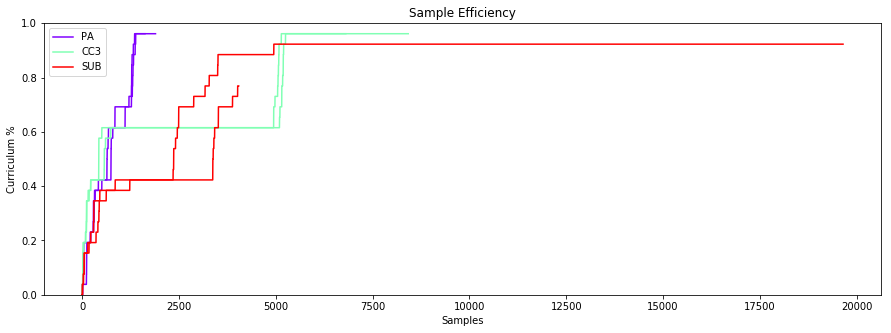

Length 6809
Length 8422
Length 2988
Length 1850
Length 6026
Length 6802


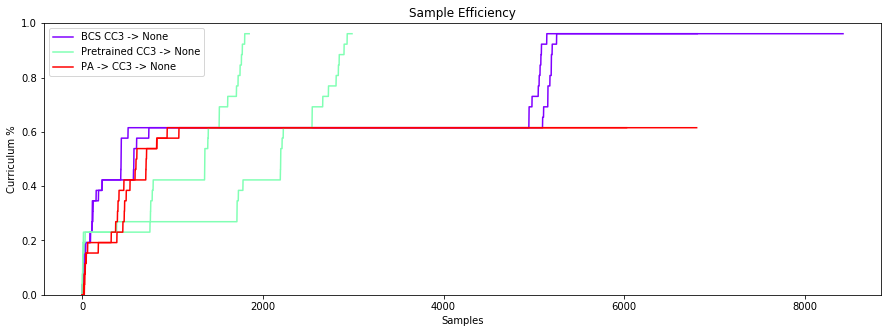

Length 19648
Length 4043
Length 3036
Length 3560
Length 6127
Length 6398


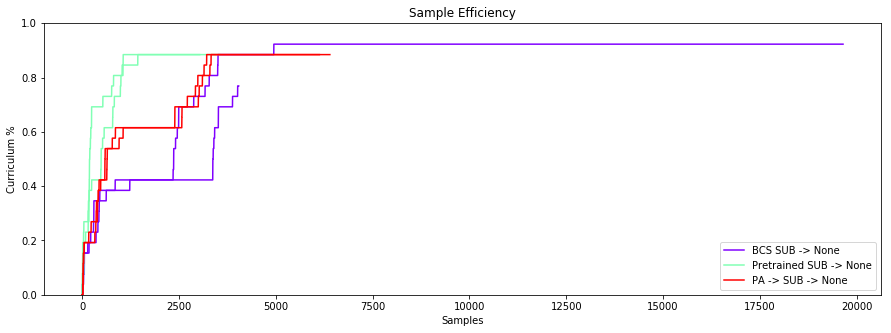

In [49]:
data_names = [ 
    (['845', '846'], 'PA'),
    (['847', '848'], 'CC3'),
    (['849', '850'], 'SUB'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['847', '848'], 'BCS CC3 -> None'),
    (['859', '860'], 'Pretrained CC3 -> None'),
    (['821', '822'], 'PA -> CC3 -> None'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['849', '850'], 'BCS SUB -> None'),
    (['861', '862'], 'Pretrained SUB -> None'),
    (['823', '824'], 'PA -> SUB -> None'),
]
plot_curriculum(data_names, 'samples')

BCS (oracle -> teacher) vs Pseudo-BCS (Pretrained PA --> Teacher) vs Bootstrap (PA --> Teacher)

Takeaway: bootstrapping from PA is almost as good as bootstrapping from the oracle~

Length 656
Length 906
Length 6526
Length 1435


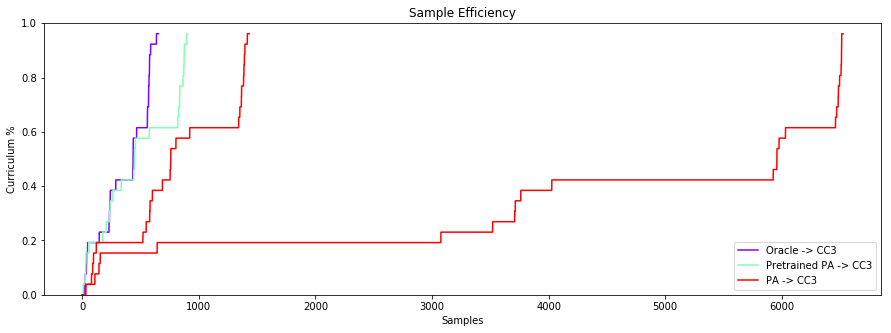

Length 199
Length 235
Length 349
Length 456
Length 361


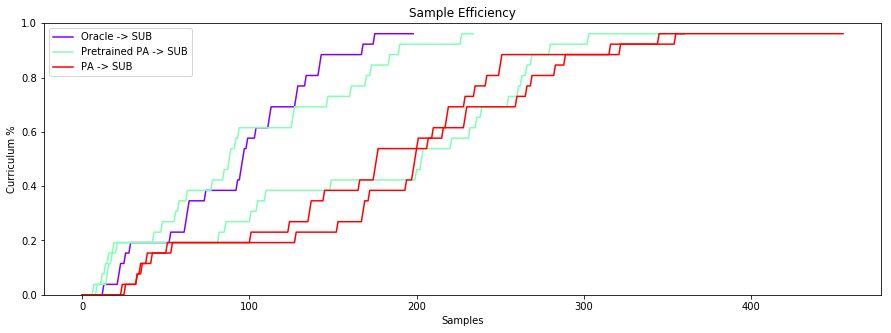

In [50]:
data_names = [ 
    (['659'], 'Oracle -> CC3'),
    (['851'], 'Pretrained PA -> CC3'),
    (['855', '856'], 'PA -> CC3'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['661'], 'Oracle -> SUB'),
    (['853', '854'], 'Pretrained PA -> SUB'),
    (['857', '858'], 'PA -> SUB'),
]
plot_curriculum(data_names, 'samples')


Distill with distribution less biased toward current level

Length 2803
Length 2915
Length 6026
Length 6802


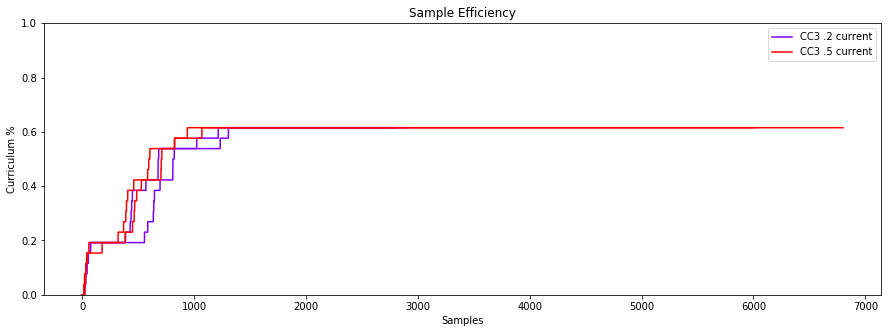

Length 4084
Length 3367
Length 6127
Length 6398


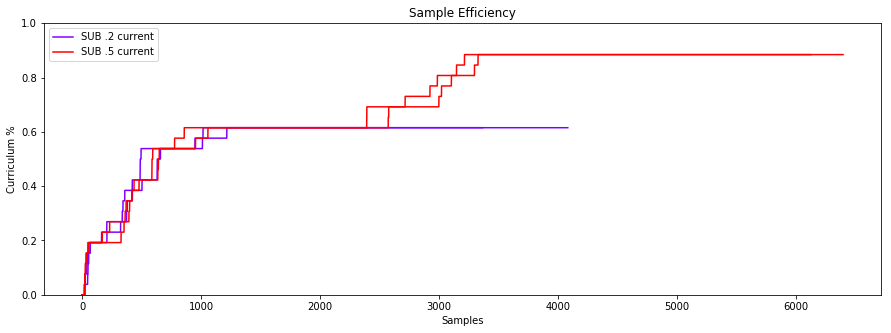

In [51]:

data_names = [ 
    (['863', '864'], 'CC3 .2 current'),
    (['821', '822'], 'CC3 .5 current'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['865', '866'], 'SUB .2 current'),
    (['823', '824'], 'SUB .5 current'),
]
plot_curriculum(data_names, 'samples')

Way more distillation itrs

Length 6026
Length 6802
Length 3954
Length 4051
Length 5339
Length 7548


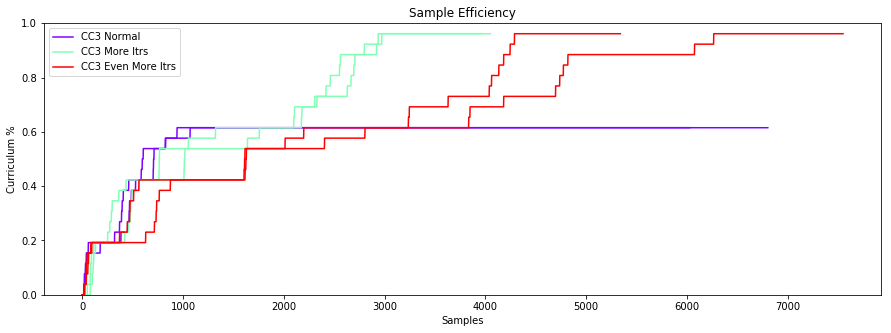

Length 6127
Length 6398
Length 8932
Length 8532
Length 20238
Length 29250


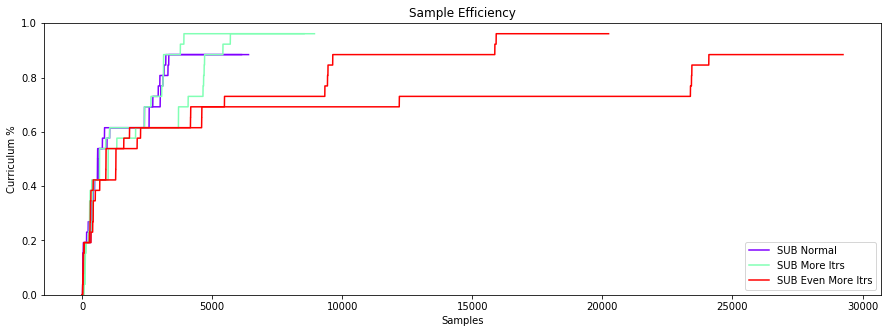

In [52]:

data_names = [ 
    (['821', '822'], 'CC3 Normal'),
    (['869', '870'], 'CC3 More Itrs'),
    (['899', '900'], 'CC3 Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'SUB Normal'),
    (['871', '872'], 'SUB More Itrs'),
    (['901', '902'], 'SUB Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

High accuracy + run forever (goal is to see if generalization improves)

Length 6026
Length 6802
Length 15446
Length 15351


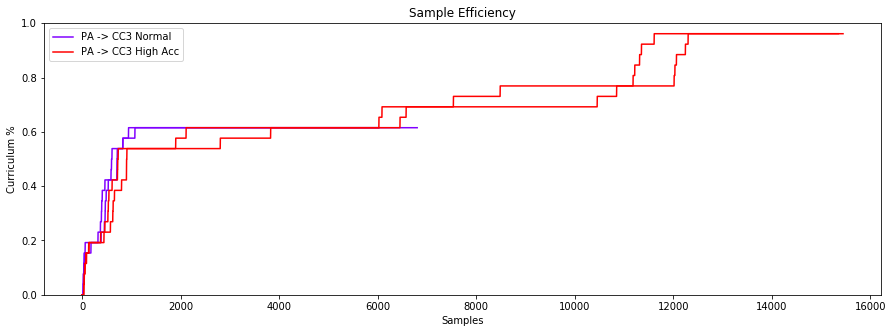

Length 6127
Length 6398
Length 1263
Length 22


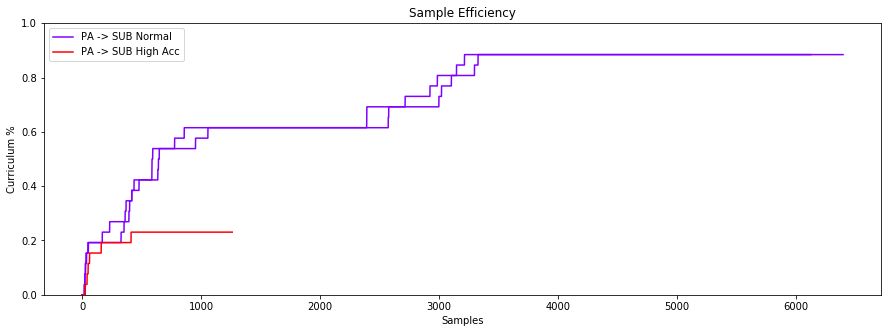

In [53]:
data_names = [ 
    (['0821', '0822'], 'PA -> CC3 Normal'),
    (['0873', '0874'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['875', '876'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing the acc threshold when we're using PA help?

Length 6026
Length 6802
Length 8911
Length 12832


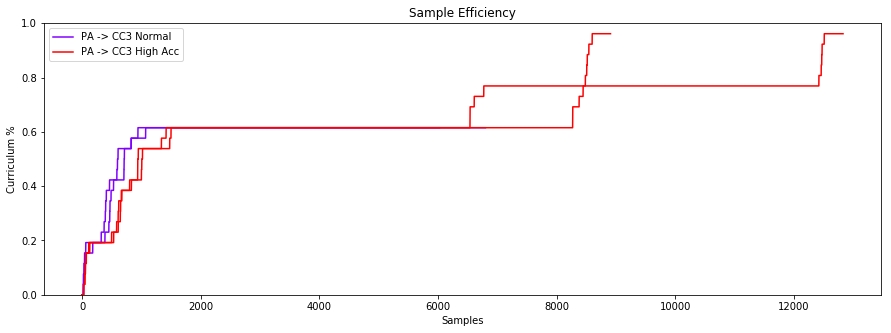

Length 6127
Length 6398
Length 11643
Length 11678


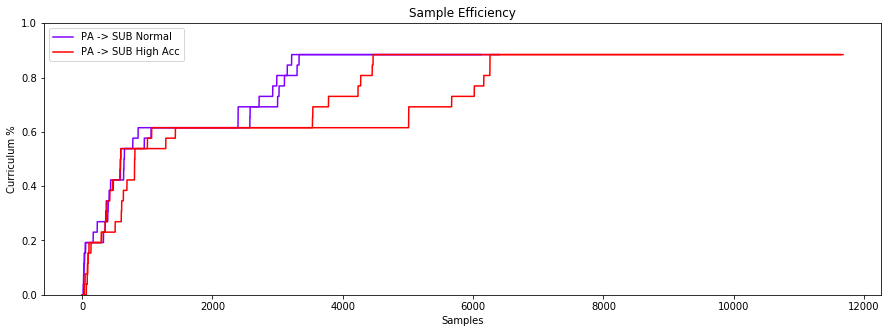

In [54]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0903', '0904'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0905', '0906'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing LR help?

Length 6026
Length 6802
Length 3508
Length 2997
Length 3445
Length 2935


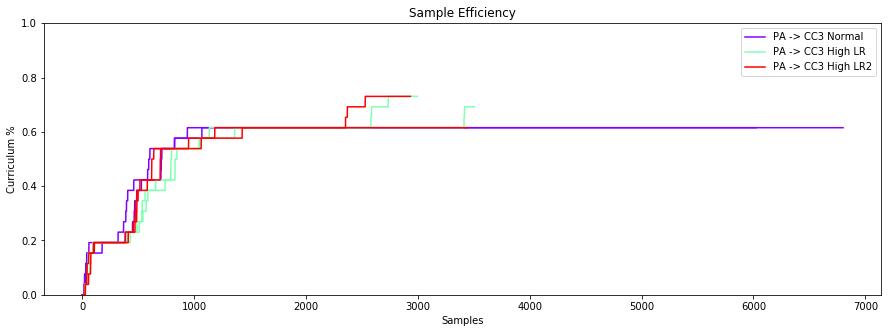

Length 6127
Length 6398
Length 6496
Length 6189
Length 7477
Length 7510


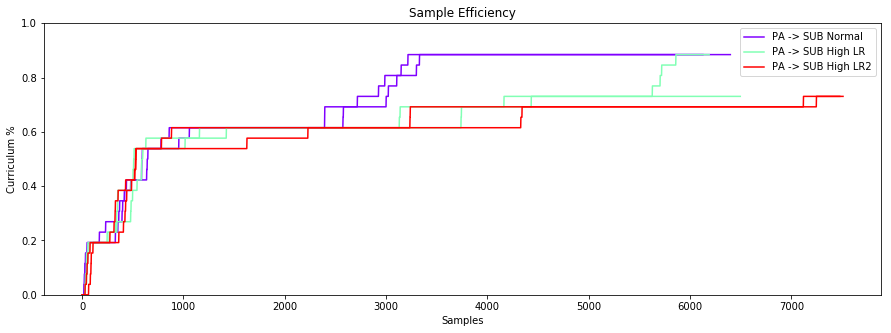

In [55]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0907', '0908'], 'PA -> CC3 High LR'),
    (['0911', '0912'], 'PA -> CC3 High LR2'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0909', '0910'], 'PA -> SUB High LR'),
    (['0913', '0914'], 'PA -> SUB High LR2'),
]
plot_curriculum(data_names, 'samples')

Does high acc + low entropy help?

Length 3835
Length 3576
Length 3335
Length 3422


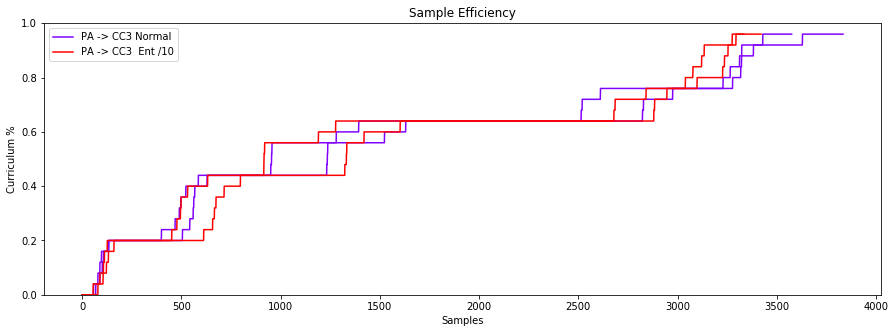

Length 1236
Length 955
Length 1332
Length 917


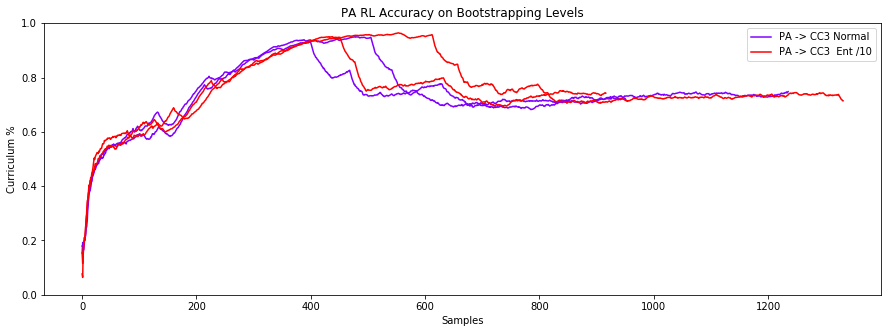

In [56]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0931', '0932'], 'PA -> CC3 Help'), # Third best; cheats by using PA a lot
#     (['0933', '0934'], 'PA -> CC3 Help + RL Acc .9'), # Second Best; cheats by using PA a lot
#     (['0935', '0936'], 'PA -> CC3 -> None'), # Not great; stoppable
#     (['0937', '0938'], 'PA -> CC3 -> None + RL Acc .9'), # Best; cheats by using PA a lot
#     (['0939', '0940'], 'PA -> CC3 -> None + High PA Acc'), # Not great; stoppable
    (['0955', '0956'], 'PA -> CC3  Ent /10'),
#     (['0963', '0964'], 'PA -> CC3 -> None + RL Acc .9 Ent /10'), # Bad; stoppable, but we should analyze
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

Length 1792
Length 1878
Length 816
Length 724
Length 657
Length 921


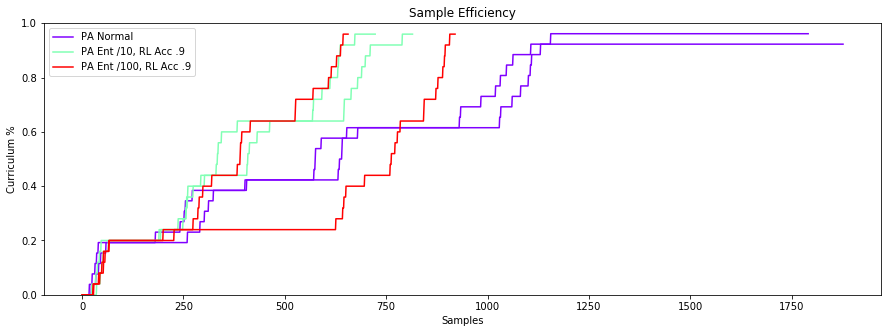

Length 575
Length 635
Length 334
Length 409
Length 390
Length 763


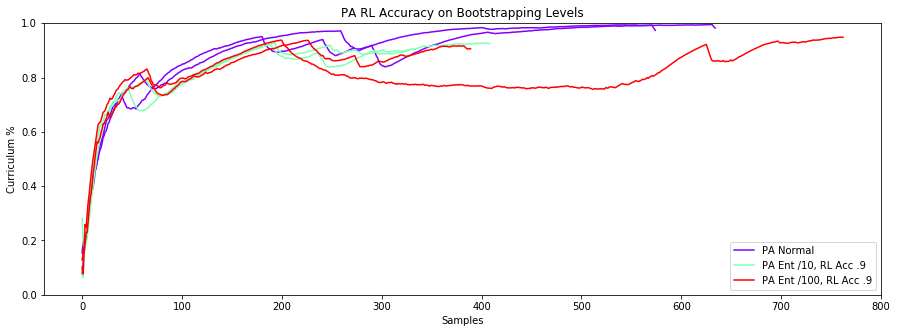

In [57]:
data_names = [ 
    (['867', '868'], 'PA Normal'),
    (['0953', '0954'], 'PA Ent /10, RL Acc .9'),
    (['0957', '0958'], 'PA Ent /100, RL Acc .9'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

Combining argmax, sample, logits

Length 8072
Length 6402
Length 3413
Length 4806
Length 4960
Length 3329
Length 3018
Length 3630
Length 2744
Length 2249


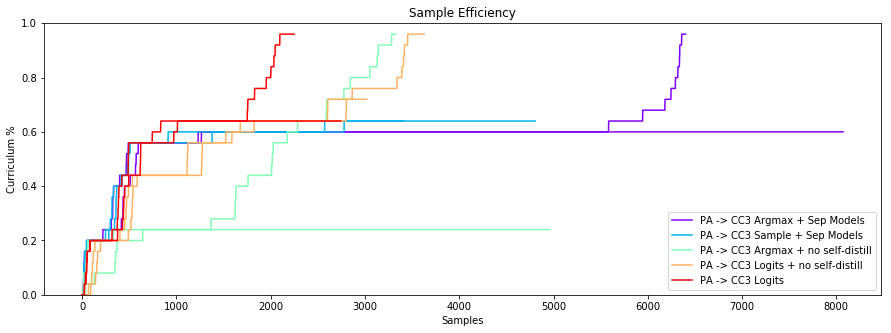

In [58]:
data_names = [ # TODO: GENERALIZATION!!!
#     (['0967', '0968'], 'PA -> CC3 Argmax'), # BAD; all others are basically the same
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0973', '0974'], 'PA -> CC3 Argmax + no self-distill'),
    (['0975', '976'], 'PA -> CC3 Logits + no self-distill'),
    (['977', '978'], 'PA -> CC3 Logits'),
]
plot_curriculum(data_names, 'samples')

Higher entropy first 10 itrs

Length 3835
Length 3576
Length 5084
Length 6335
Length 14794
Length 26502
Length 2802
Length 3880
Length 4223
Length 24702


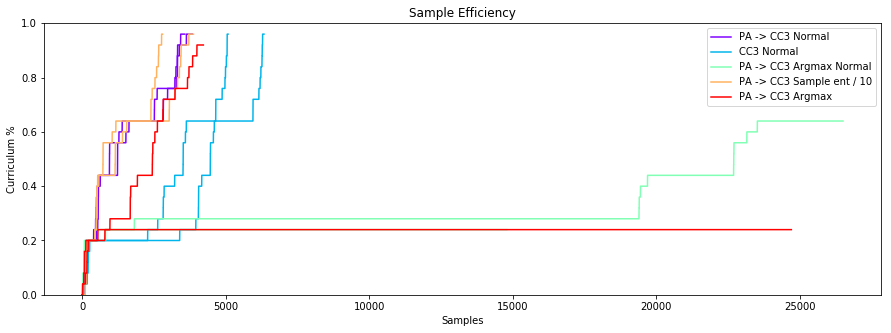

Length 1236
Length 955
Length 3519
Length 4466
Length 1155
Length 728


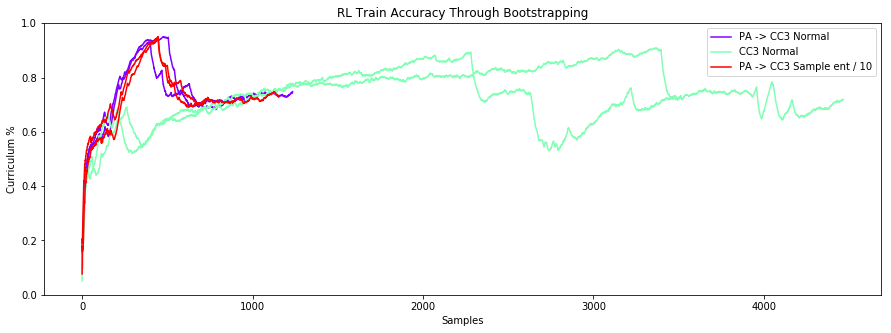

Length 1236
Length 955
Length 3519
Length 4466
Length 1155
Length 728


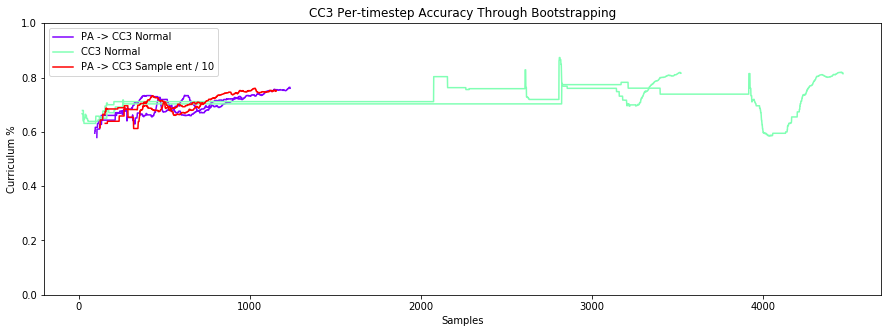

'Rollout/CartesianCorrectionsAvgAccuracy'
couldn't plot PA -> CC3 Normal
'Rollout/CartesianCorrectionsAvgAccuracy'
couldn't plot CC3 Normal
Length 1155
Length 728


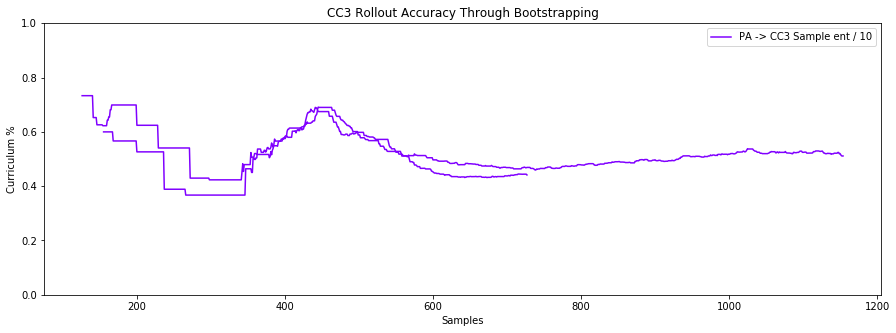

In [59]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
    (['0983', '0984'], 'PA -> CC3 Argmax'),
]
plot_curriculum(data_names, 'samples')
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
]

plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="RL Train Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

Length 3835
Length 3576
Length 5084
Length 6335
Length 14794
Length 26502
Length 2802
Length 3880
Length 4223
Length 24702


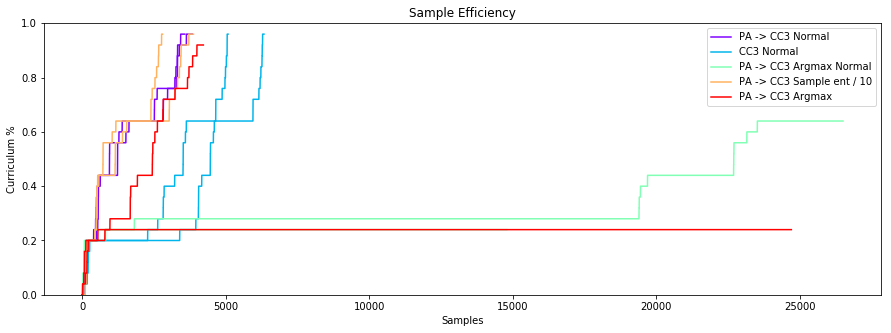

Length 1236
Length 955
Length 3519
Length 4466
Length 1155
Length 728


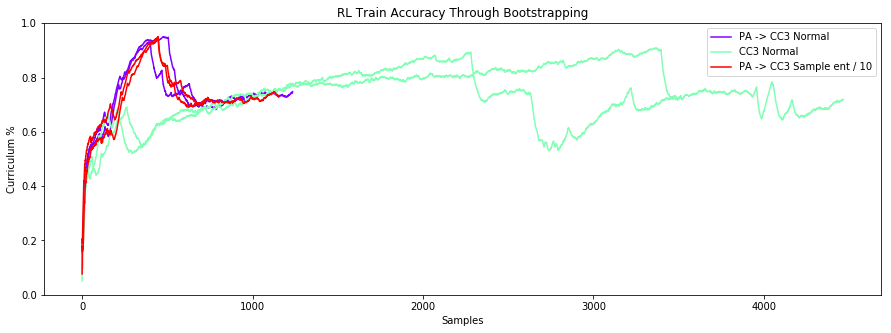

Length 1236
Length 955
Length 3519
Length 4466
Length 1155
Length 728


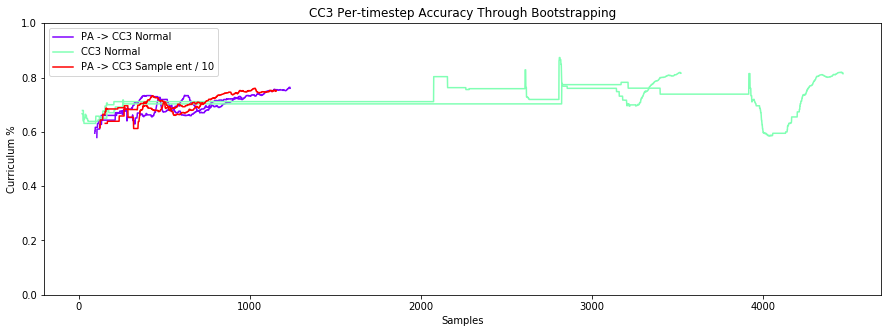

'Rollout/CartesianCorrectionsAvgAccuracy'
couldn't plot PA -> CC3 Normal
'Rollout/CartesianCorrectionsAvgAccuracy'
couldn't plot CC3 Normal
Length 1155
Length 728


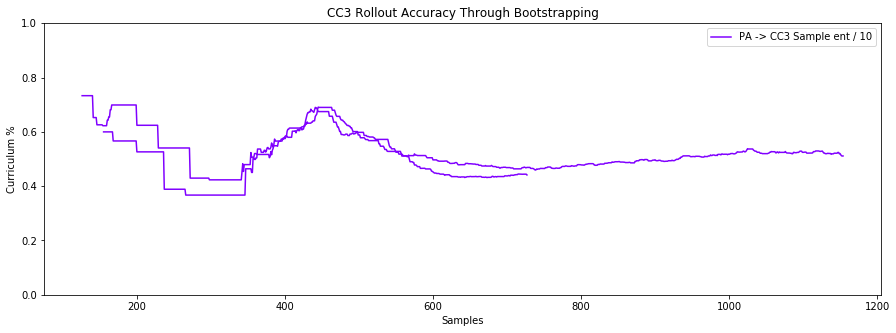

In [60]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
    (['0983', '0984'], 'PA -> CC3 Argmax'),
]
plot_curriculum(data_names, 'samples')
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
]

plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="RL Train Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

Fake CC3 labels

Length 3835
Length 3576
Length 2981
Length 2986
Length 2986
Length 3276
Length 660
Length 1996


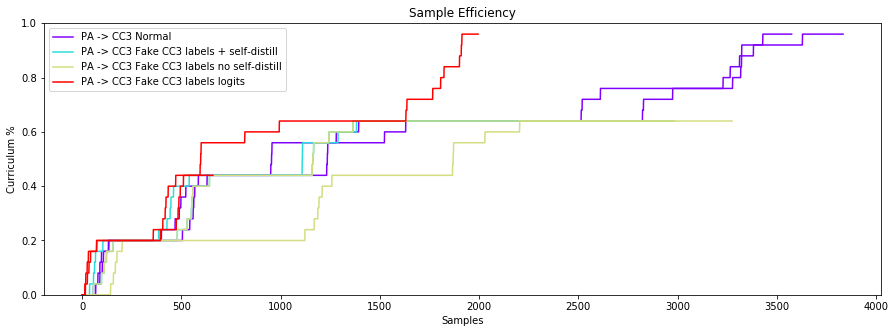

Length 1236
Length 955
Length 1110
Length 1163
Length 1163
Length 1870
Length 660
Length 598


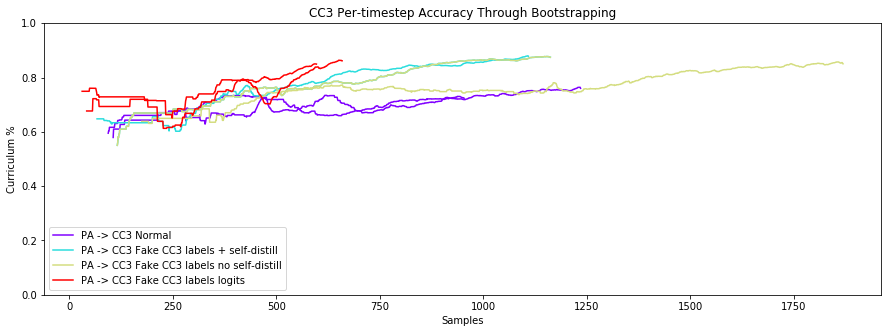

'Rollout/CartesianCorrectionsAvgAccuracy'
couldn't plot PA -> CC3 Normal
Length 1110
Length 1163
Length 1163
Length 1870
Length 660
Length 598


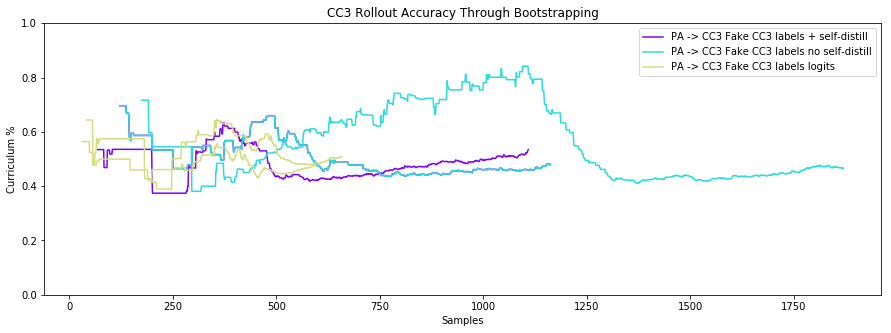

In [61]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0985', '0986'], 'PA -> CC3 Fake CC3 labels + self-distill'),
    (['0986', '0987'], 'PA -> CC3 Fake CC3 labels no self-distill'),
    (['0995', '0996'], 'PA -> CC3 Fake CC3 labels logits'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

Length 2756
Length 2596
Length 3018
Length 3630
Length 2702
Length 4961
Length 2981
Length 2986
Length 660
Length 1996
Length 212
Length 208
Length 139


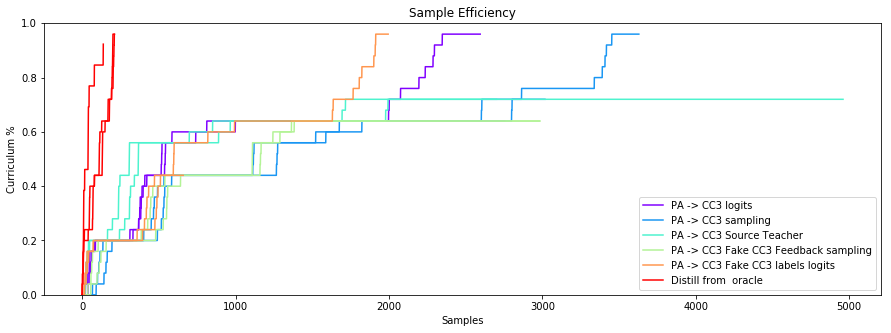

Length 519
Length 542
Length 1117
Length 1271
Length 367
Length 308
Length 1110
Length 1163
Length 660
Length 598
Length 112
Length 132
Length 139


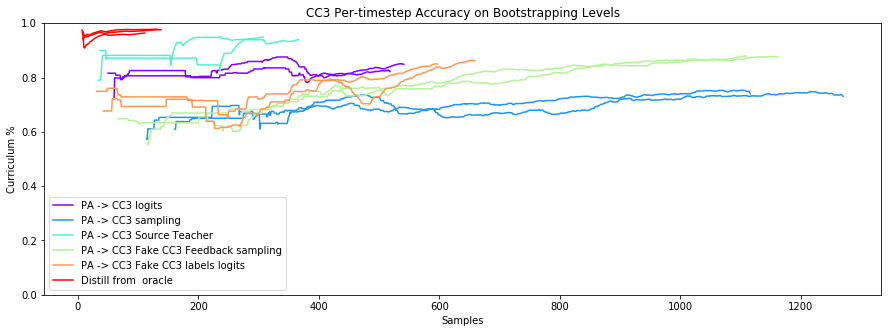

Length 519
Length 542
Length 1117
Length 1271
Length 367
Length 308
Length 1110
Length 1163
Length 660
Length 598
Length 112
Length 132
Length 139


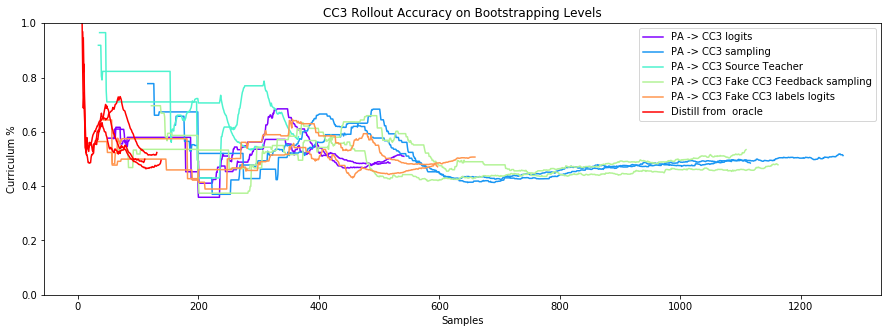

Length 519
Length 542
Length 1117
Length 1271
Length 367
Length 308
Length 1110
Length 1163
Length 660
Length 598
Length 112
Length 132
Length 139


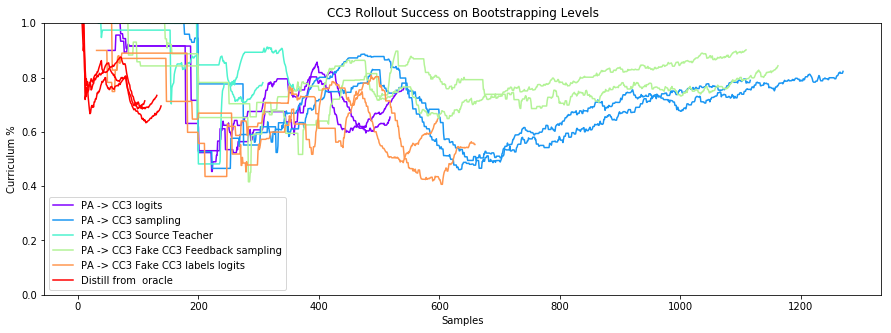

Length 519
Length 542
Length 1117
Length 1271
Length 367
Length 308
Length 1110
Length 1163
Length 660
Length 598
'Train/Accuracy'
couldn't plot Distill from  oracle


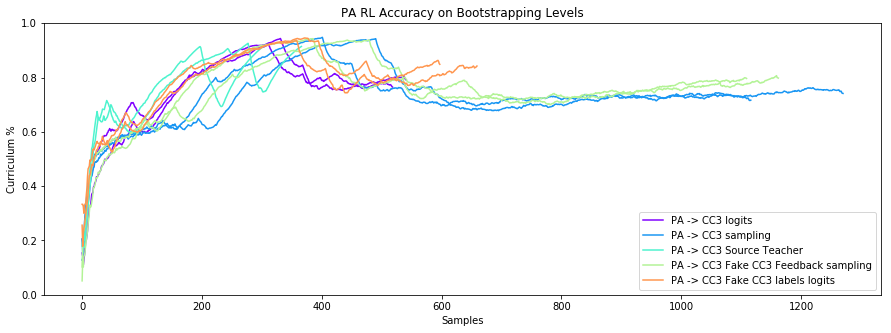

Length 519
Length 542
Length 1117
Length 1271
Length 367
Length 308
Length 1110
Length 1163
Length 660
Length 598
Length 112
Length 132
Length 139


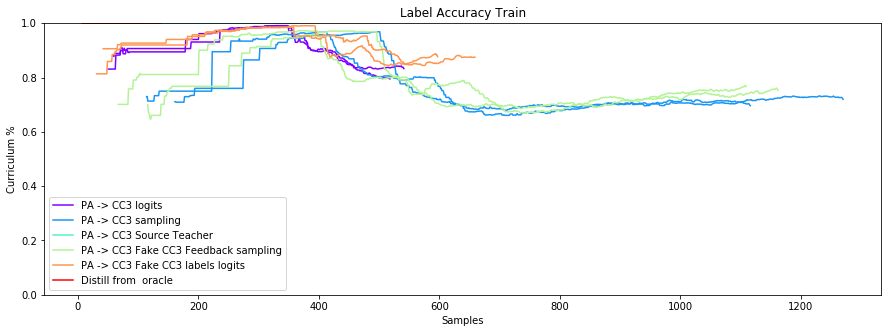

Length 519
Length 542
Length 1117
Length 1271
Length 367
Length 308
Length 1110
Length 1163
Length 660
Length 598
Length 112
Length 132
Length 139


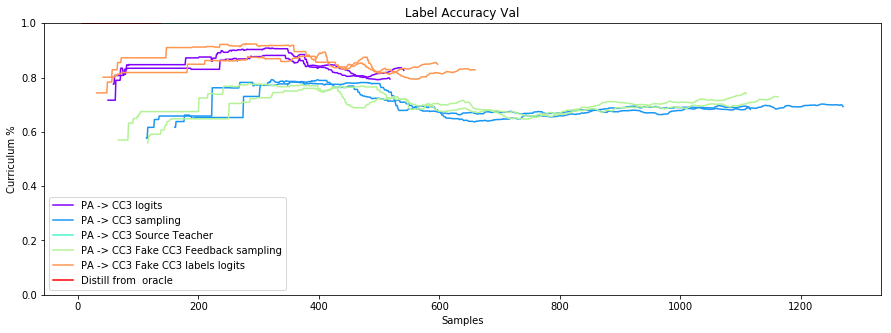

In [62]:
data_names = [ 
    (['979', '980'], 'PA -> CC3 logits'),
#     (['967', '968'], 'PA -> CC3 Argmax'),
#     (['977', '978'], 'PA -> CC3 Normal (logits, no self-distill)'),
    (['0975', '0976'], 'PA -> CC3 sampling'),
    (['0991', '0992'], 'PA -> CC3 Source Teacher'),
    (['0985', '0986'], 'PA -> CC3 Fake CC3 Feedback sampling'),
    (['0995', '0996'], 'PA -> CC3 Fake CC3 labels logits'),
#     (['867', '868'], 'PA'),
    (['0997', '0998', '1033'], 'Distill from  oracle'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

Length 1


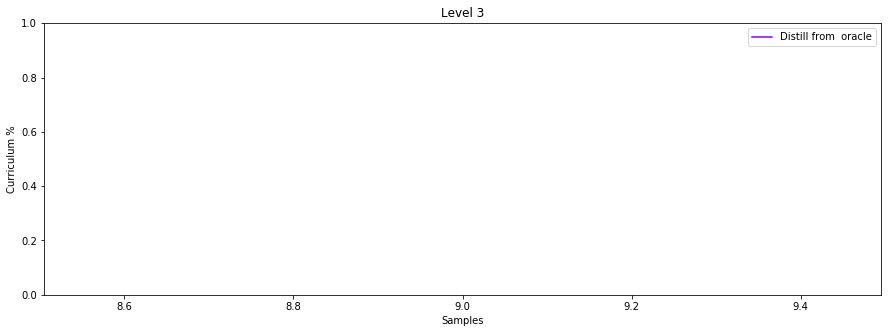

Length 1


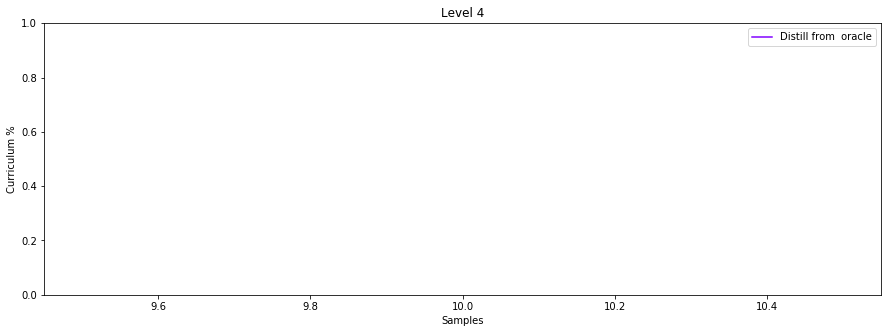

Length 6


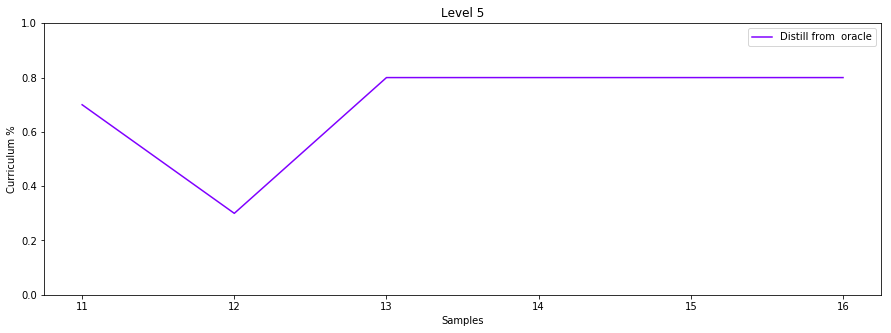

Length 22


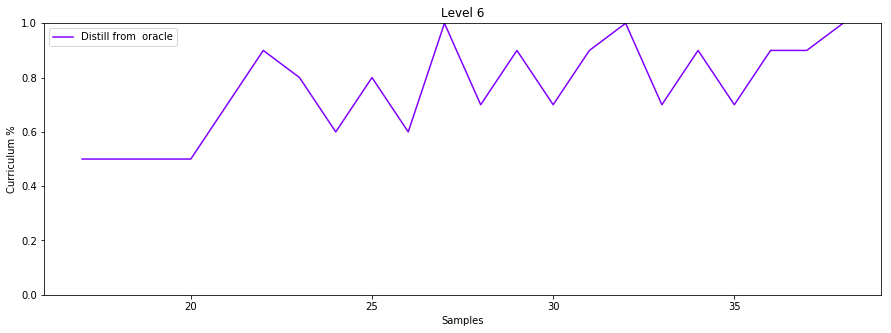

Length 1


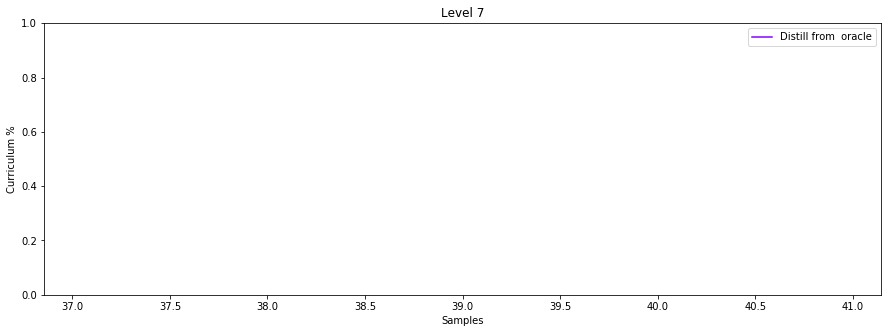

Length 1


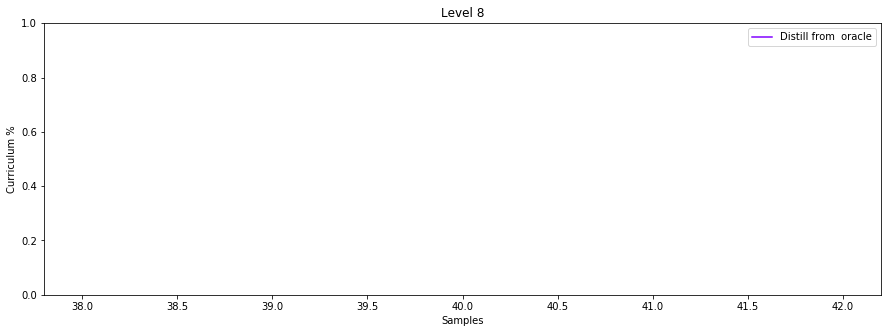

Length 5


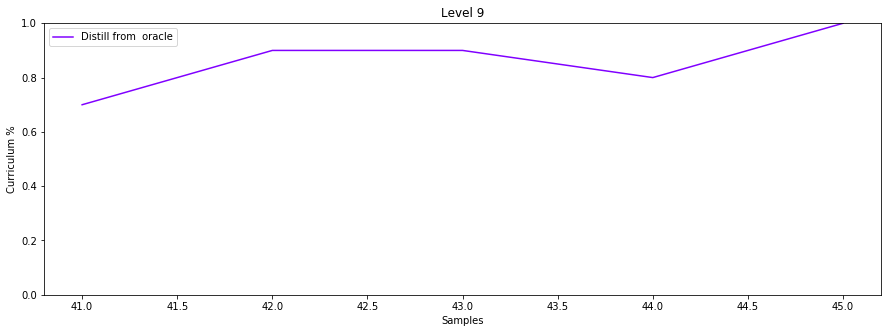

Length 34


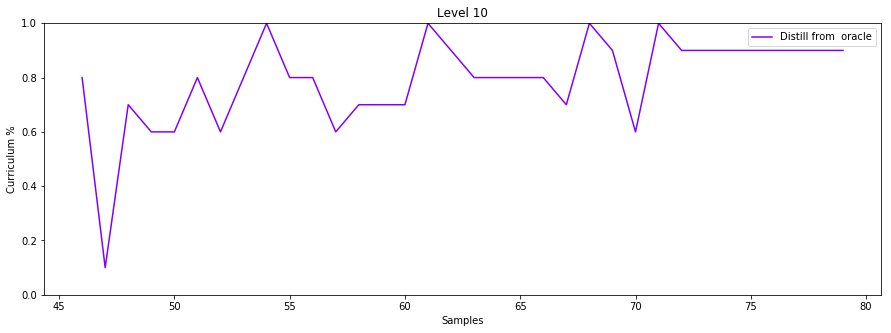

Length 58


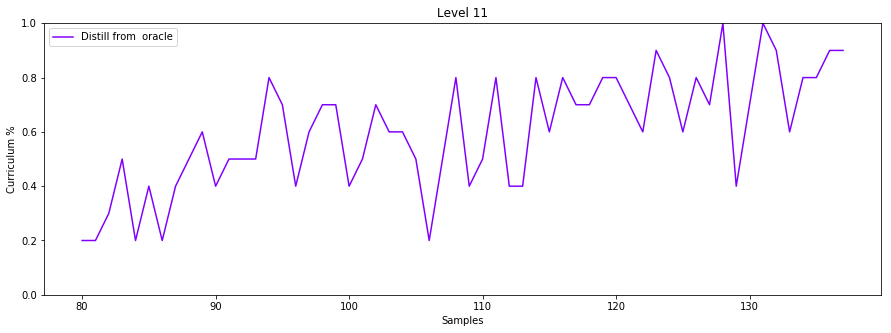

In [63]:
data_names = [ 
    (['1033'], 'Distill from  oracle'),
] # kangaroo

for i in range(3, 12):
    plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=1, 
                level_start=i, level_end=i, title=f"Level {i}")

Length 1253
Length 714
Length 750
Length 212
Length 208
Length 823
Length 133


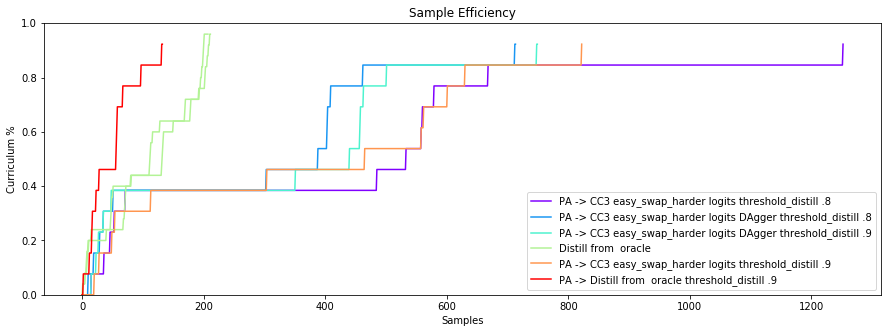

Length 1253
Length 714
Length 750
Length 112
Length 132
Length 823
Length 133


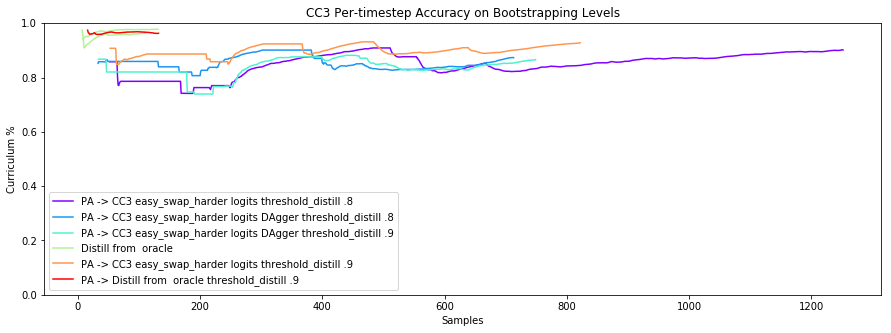

Length 1253
Length 714
Length 750
Length 112
Length 132
Length 823
Length 133


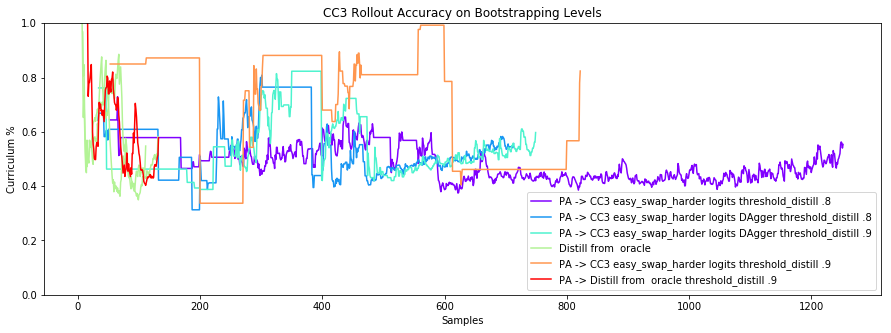

Length 1253
Length 714
Length 750
Length 112
Length 132
Length 823
Length 133


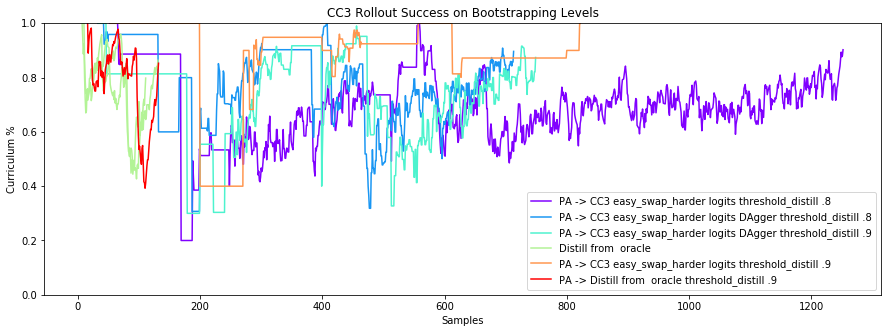

Length 1253
Length 714
Length 750
Length 112
Length 132
Length 823
Length 133


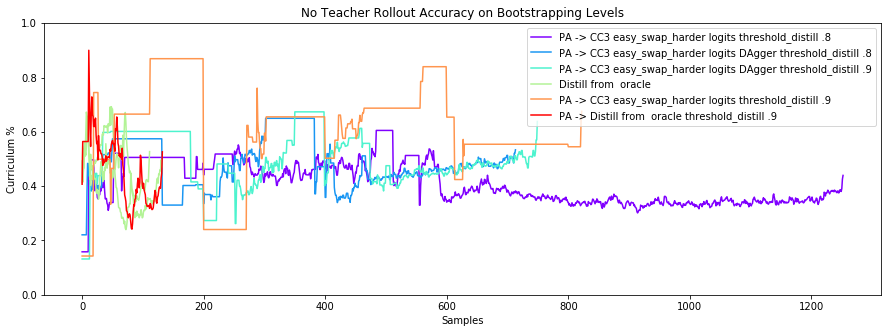

Length 1253
Length 714
Length 750
Length 112
Length 132
Length 823
Length 133


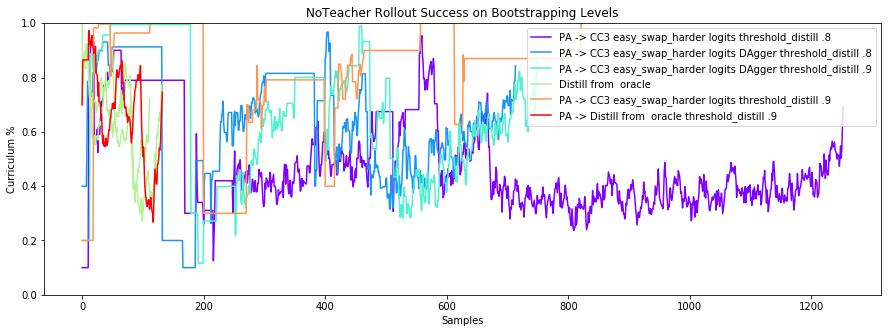

Length 1253
Length 714
Length 750
'Train/Accuracy'
couldn't plot Distill from  oracle
Length 823
Length 133


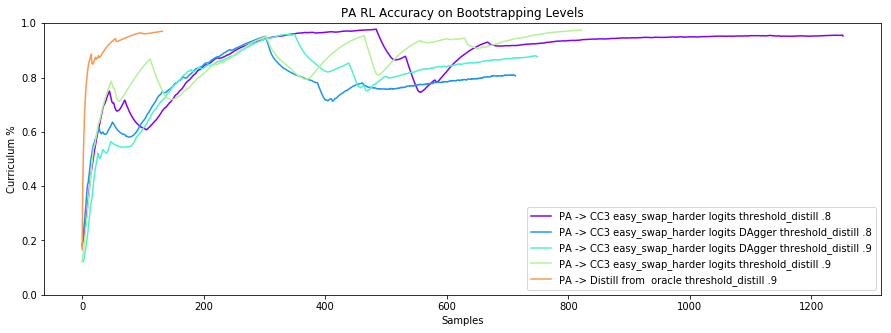

Length 1253
Length 714
Length 750
Length 112
Length 132
Length 823
Length 133


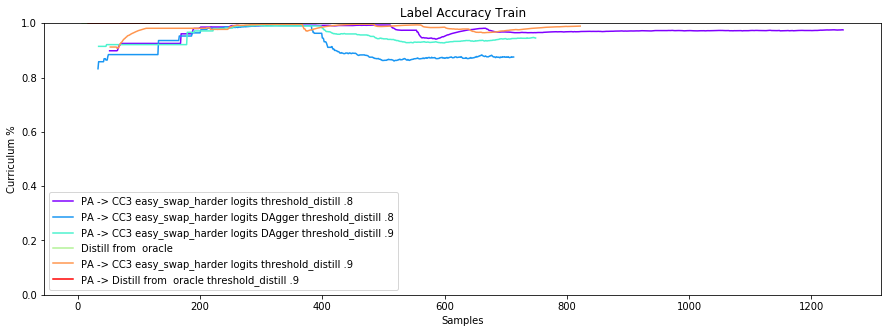

Length 1253
Length 714
Length 750
Length 112
Length 132
Length 823
Length 133


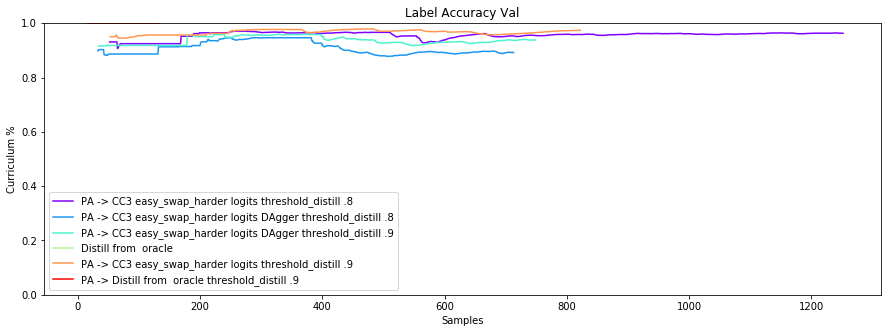

In [64]:
data_names = [ 
#     (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
    (['1072'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8'),
    (['1073'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9'),
    (['0997', '0998'], 'Distill from  oracle'),
    (['1145'], 'PA -> CC3 easy_swap_harder logits threshold_distill .9'),
    (['1146'], 'PA -> Distill from  oracle threshold_distill .9'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DRollout/AvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="No Teacher Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DRollout/AverageSuccess', smooth=10, 
                level_start=0, level_end=12, title="NoTeacher Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

Length 1253
Length 714
Length 750
Length 212
Length 208


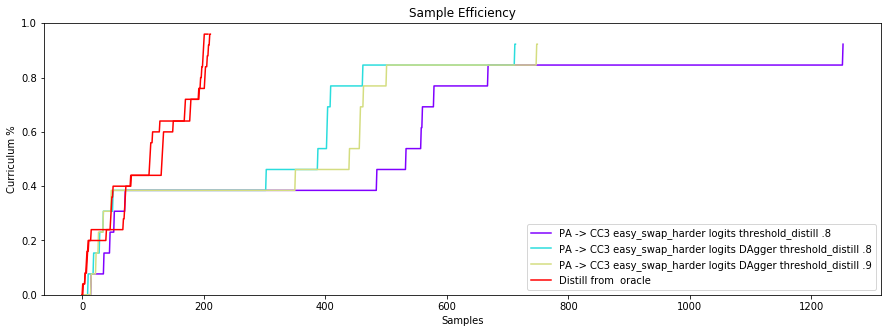

Length 1253
Length 714
Length 750
Length 112
Length 132


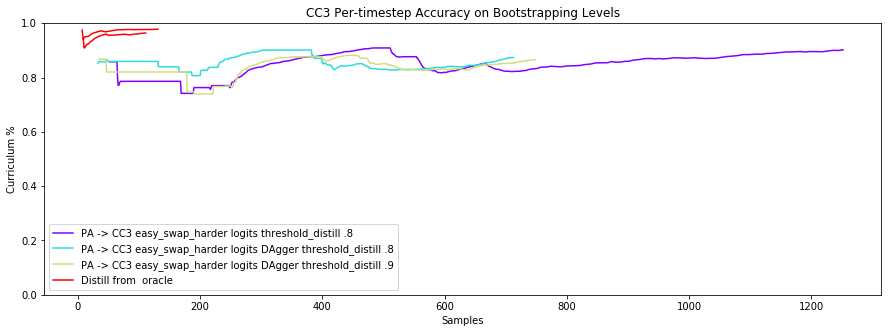

Length 1253
Length 714
Length 750
Length 112
Length 132


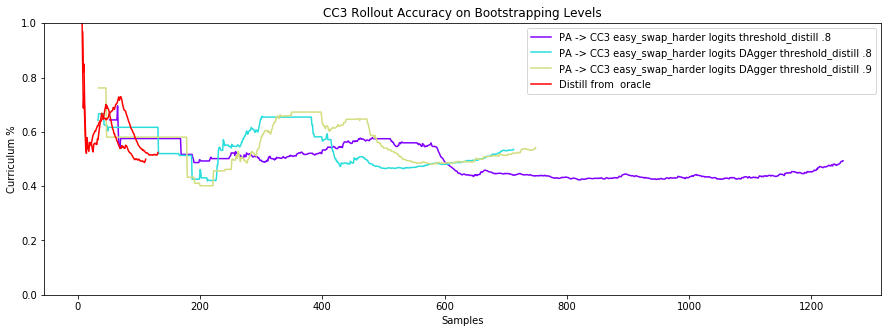

Length 1253
Length 714
Length 750
Length 112
Length 132


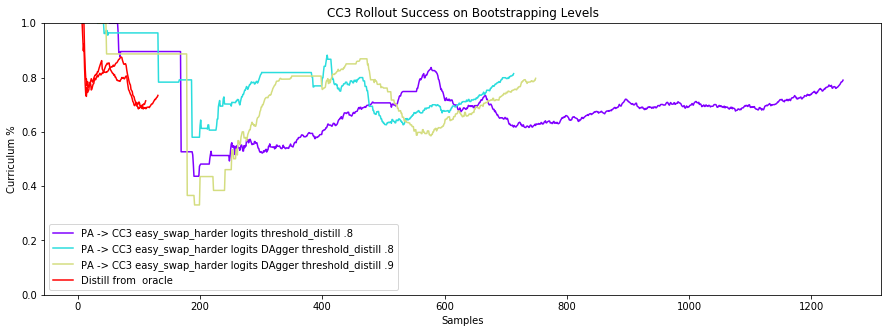

Length 1253
Length 714
Length 750
'Train/Accuracy'
couldn't plot Distill from  oracle


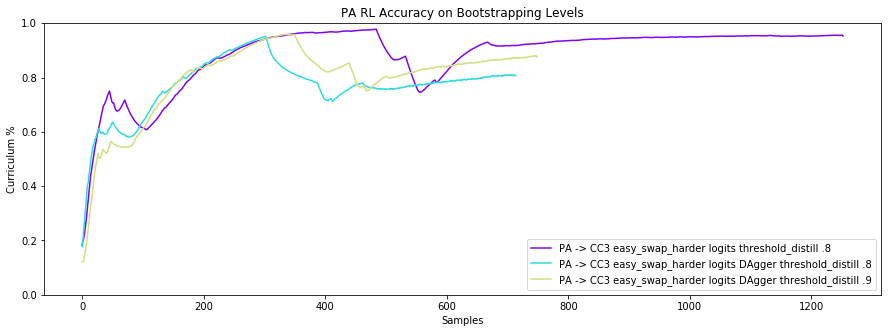

Length 1253
Length 714
Length 750
Length 112
Length 132


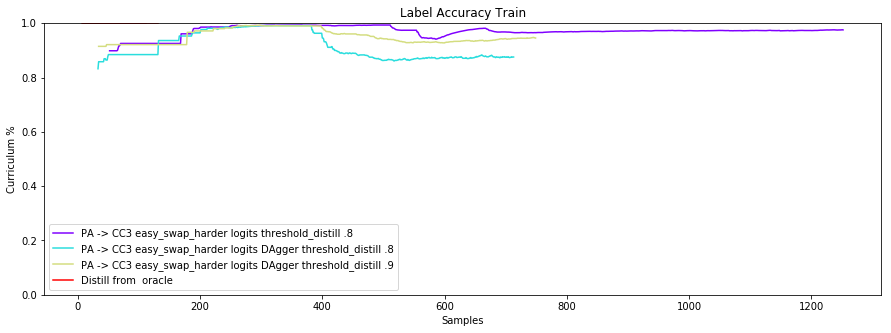

Length 1253
Length 714
Length 750
Length 112
Length 132


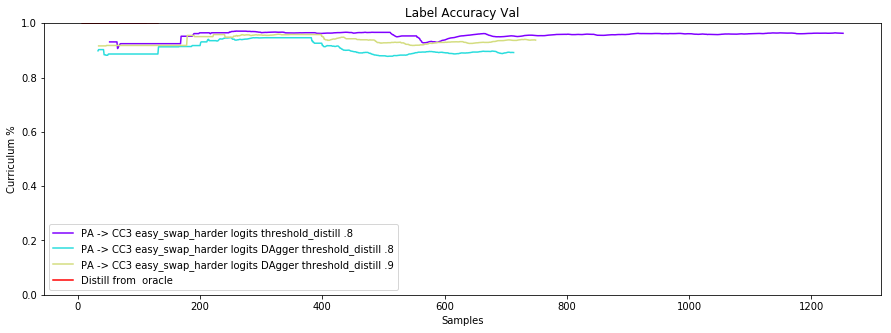

In [65]:
data_names = [ 
#     (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
    (['1072'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8'),
    (['1073'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9'),
    (['0997', '0998'], 'Distill from  oracle'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

## How can we get good PA accuracy?

Length 334
Length 409
Length 1106
Length 1148
Length 519
Length 542
Length 575
Length 635
Length 489
Length 494
Length 471
Length 573
Length 66
Length 56


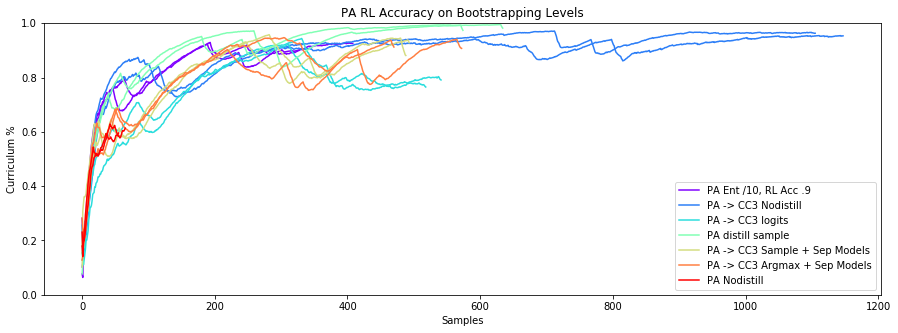

Length 816
Length 724
Length 1529
Length 2494
Length 2756
Length 2596
Length 1792
Length 1878
Length 3413
Length 4806
Length 8072
Length 6402
Length 79
Length 69


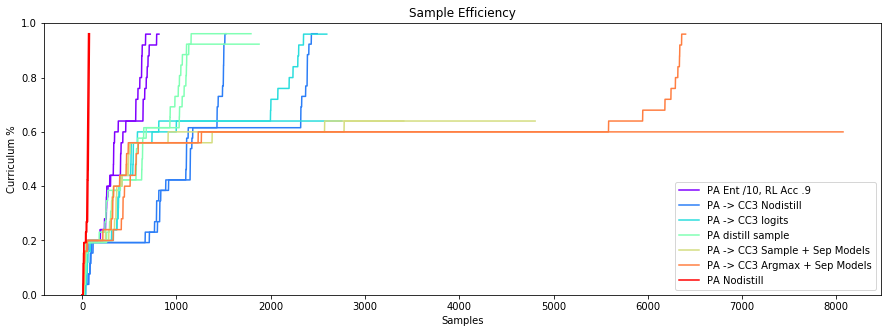

'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA Ent /10, RL Acc .9
'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA -> CC3 Nodistill
Length 519
Length 542
'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA distill sample
Length 489
Length 494
Length 471
Length 573
'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA Nodistill


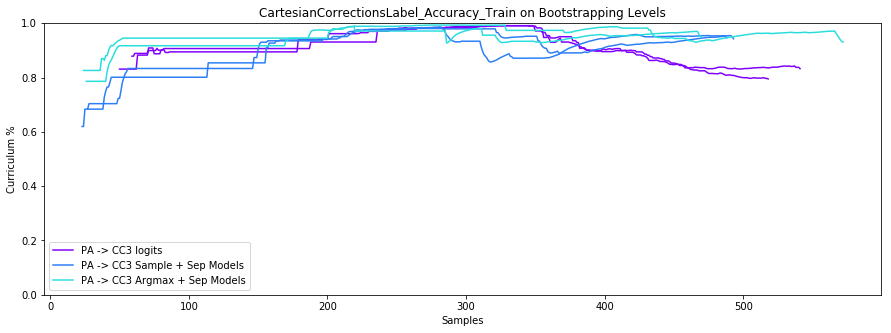

In [66]:
data_names = [ 
#     (['867', '868'], 'PA Normal'),
    (['0953', '0954'], 'PA Ent /10, RL Acc .9'),
#     (['0957', '0958'], 'PA Ent /100, RL Acc .9'),
#     (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0931', '0932'], 'PA -> CC3 Help'), # Third best; cheats by using PA a lot
#     (['0933', '0934'], 'PA -> CC3 Help + RL Acc .9'), # Second Best; cheats by using PA a lot
#     (['0935', '0936'], 'PA -> CC3 -> None'), # Not great; stoppable
#     (['0937', '0938'], 'PA -> CC3 -> None + RL Acc .9'), # Best; cheats by using PA a lot
#     (['0939', '0940'], 'PA -> CC3 -> None + High PA Acc'), # Not great; stoppable
#     (['0955', '0956'], 'PA -> CC3  Ent /10'),
#     (['0963', '0964'], 'PA -> CC3 -> None + RL Acc .9 Ent /10'), # Bad; stoppable, but we should analyze
    (['0895', '0896'], 'PA -> CC3 Nodistill'), # Bad; stoppable, but we should analyze
#     (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0951', '0952'], 'CC3 Normal'),
#     (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
#     (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
#     (['0983', '0984'], 'PA -> CC3 Argmax'),
    (['979', '980'], 'PA -> CC3 logits'),
#     (['967', '968'], 'PA -> CC3 Argmax'),
#     (['977', '978'], 'PA -> CC3 Normal (logits, no self-distill)'),
#     (['0975', '0976'], 'PA -> CC3 sampling'),
#     (['0991', '0992'], 'PA -> CC3 Source Teacher'),
#     (['0985', '0986'], 'PA -> CC3 Fake CC3 Feedback sampling'),
    (['867', '868'], 'PA distill sample'),
    
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['0877', '0878'], 'PA Nodistill'),
#     (['0919', '0920'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")

 Can we get good PA Acc?

Length 101
Length 317
Length 528
Length 462
Length 535
Length 704
Length 646
Length 505
Length 1607
Length 1253


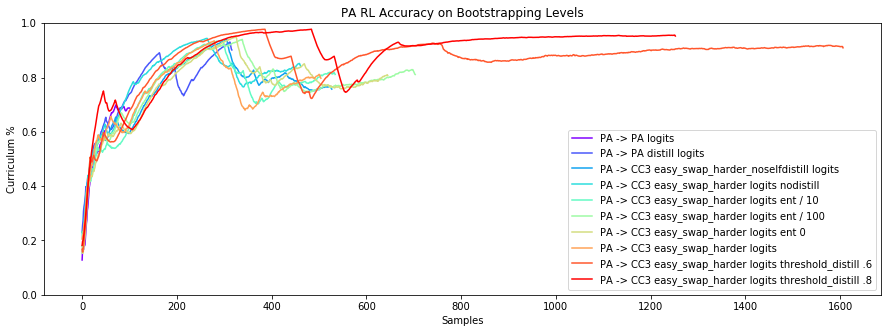

Length 101
Length 317
Length 528
Length 462
Length 535
Length 704
Length 646
Length 505
Length 1607
Length 1253


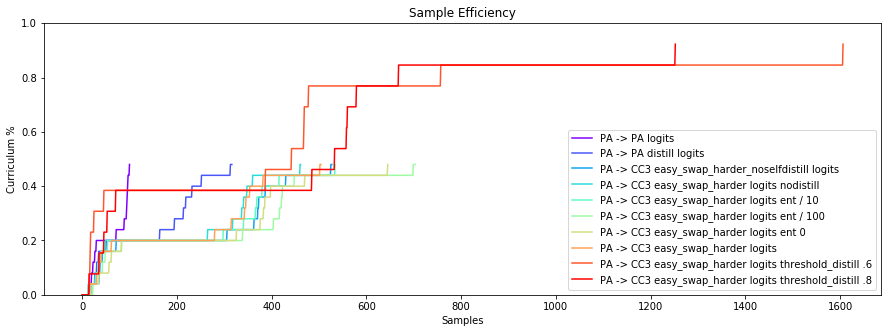

Length 101
Length 317
Length 528
'Distill/PreActionAdviceLabel_Accuracy_Train'
couldn't plot PA -> CC3 easy_swap_harder logits nodistill
Length 535
Length 704
Length 646
Length 505
Length 1607
Length 1253


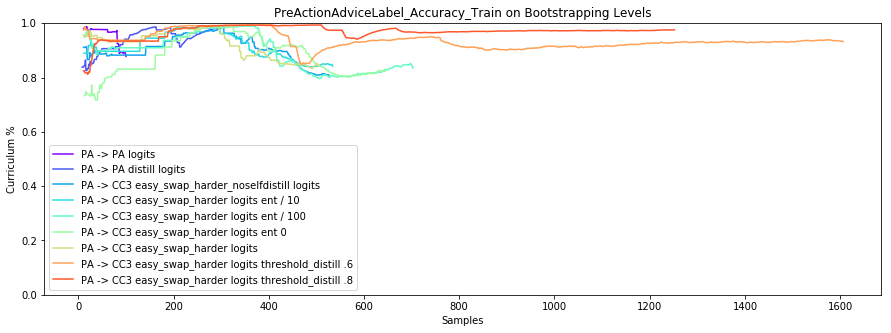

'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA -> PA logits
'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA -> PA distill logits
Length 528
Length 462
Length 535
Length 704
Length 646
Length 505
Length 1607
Length 1253


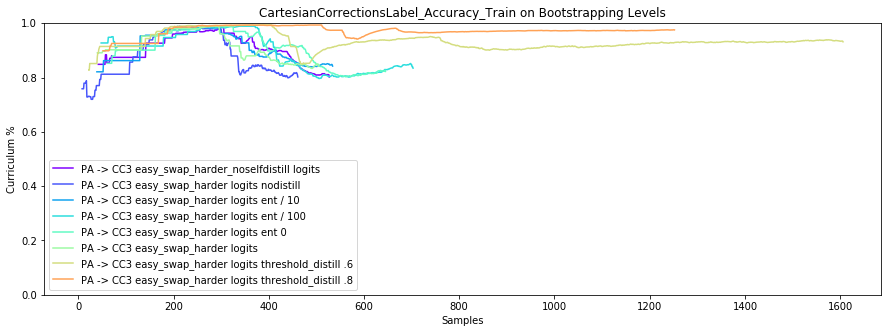

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Length 547
Length 451
Length 425
Length 396
Length 489
Length 494
Length 471
Length 573
Length 1607
Length 1253


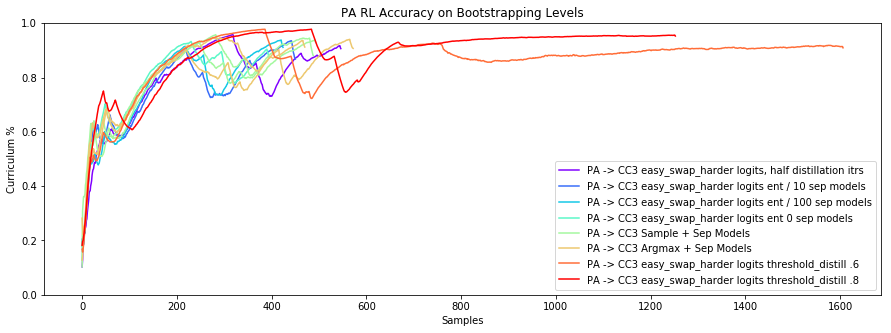

Length 547
Length 451
Length 425
Length 396
Length 489
Length 494
Length 471
Length 573
Length 1607
Length 1253


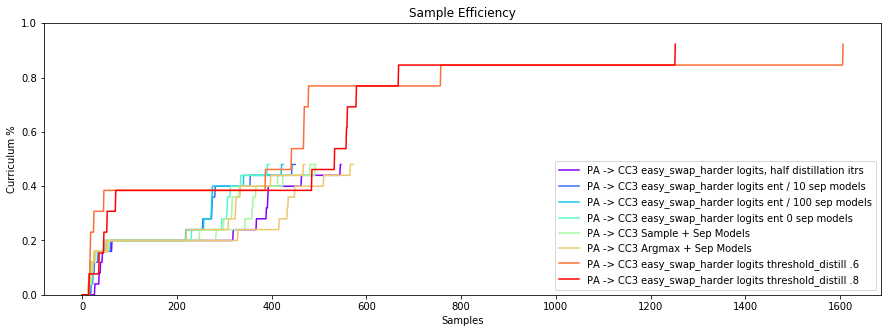

Length 547
Length 451
Length 425
Length 396
Length 489
Length 494
Length 471
Length 573
Length 1607
Length 1253


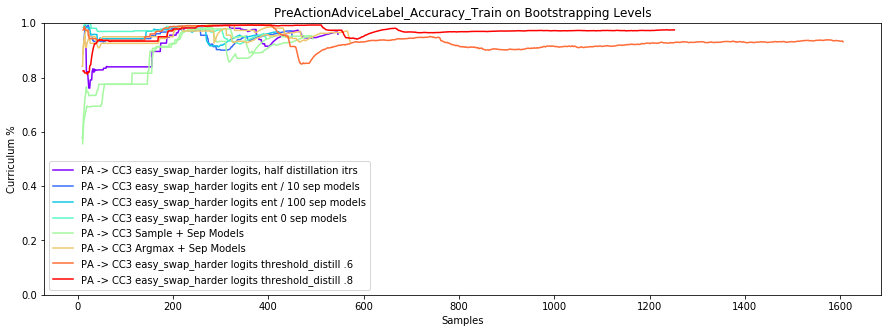

Length 547
Length 451
Length 425
Length 396
Length 489
Length 494
Length 471
Length 573
Length 1607
Length 1253


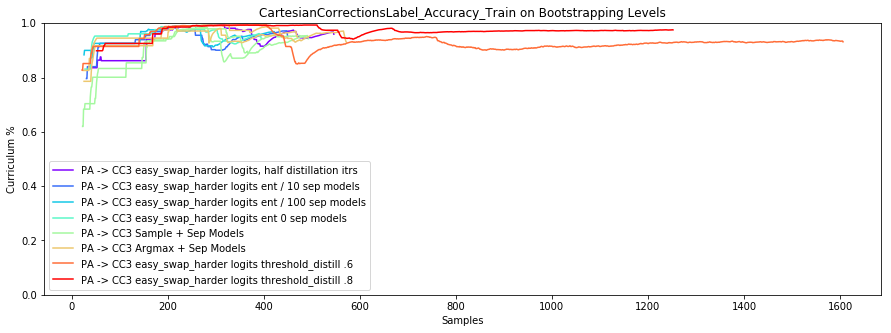

In [67]:
data_names = [ 
    (['0999'], 'PA -> PA logits'),
    (['1000'], 'PA -> PA distill logits'),
    (['1003'], 'PA -> CC3 easy_swap_harder_noselfdistill logits'),
    (['1006'], 'PA -> CC3 easy_swap_harder logits nodistill'),
    (['1007'], 'PA -> CC3 easy_swap_harder logits ent / 10'),
    (['1008'], 'PA -> CC3 easy_swap_harder logits ent / 100'),
    (['1009'], 'PA -> CC3 easy_swap_harder logits ent 0'),
    (['1001'], 'PA -> CC3 easy_swap_harder logits'),
    (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', level_start=0, level_end=12)
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
# plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
#                 level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

print("/" * 200)

data_names = [ 
    (['1004'], 'PA -> CC3 easy_swap_harder logits, half distillation itrs'),
    (['1010'], 'PA -> CC3 easy_swap_harder logits ent / 10 sep models'),
    (['1011'], 'PA -> CC3 easy_swap_harder logits ent / 100 sep models'),
    (['1012'], 'PA -> CC3 easy_swap_harder logits ent 0 sep models'),
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
#     (['0877', '0878'], 'PA Nodistill'),
#     (['867', '868'], 'PA distill sample'),
#     (['0895', '0896'], 'PA -> CC3 Nodistill sample'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', level_start=0, level_end=12)
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
# plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
#                 level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

How many distillation steps should we use?

Length 505
Length 547
Length 471
Length 573
Length 396
'Train/Accuracy'
couldn't plot Distill from  oracle


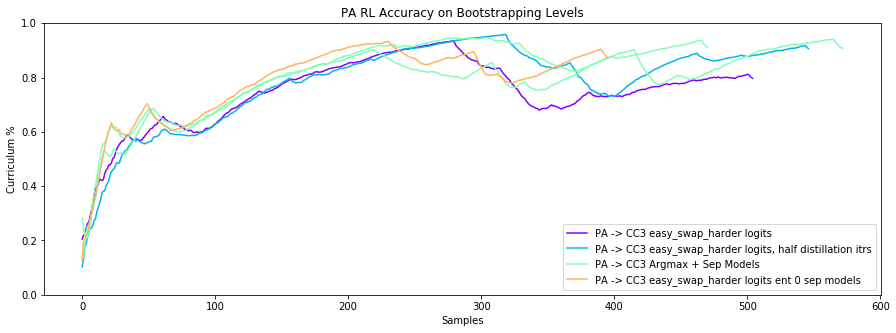

Length 2505
Length 1673
Length 8072
Length 6402
Length 4468
Length 212
Length 208


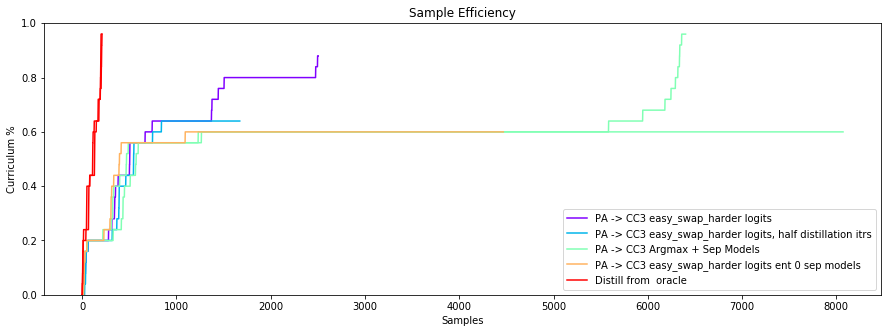

Length 505
Length 547
Length 471
Length 573
Length 396
Length 112
Length 132


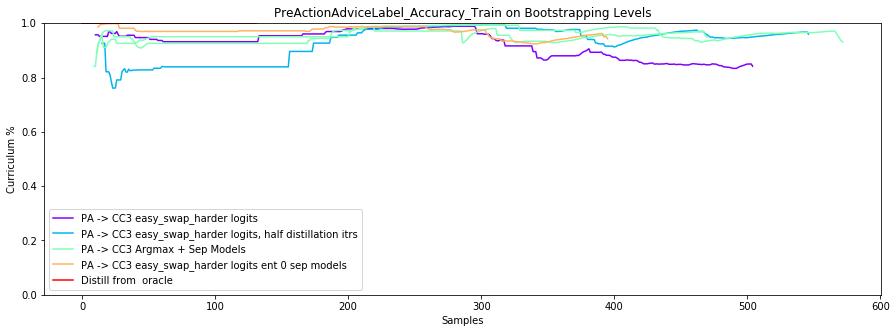

Length 505
Length 547
Length 471
Length 573
Length 396
Length 112
Length 132


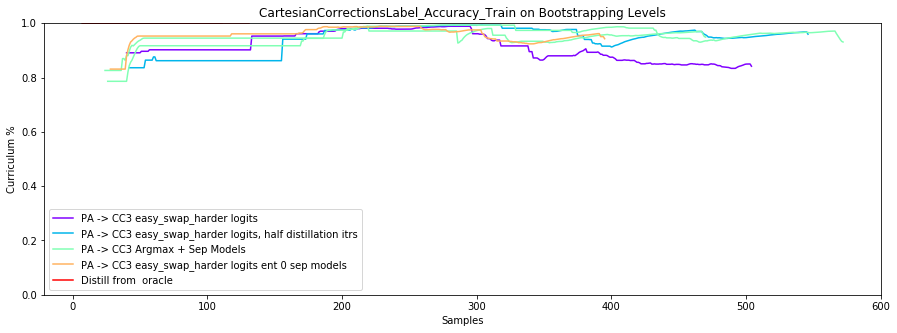

Length 505
Length 547
Length 471
Length 573
Length 396
Length 112
Length 132


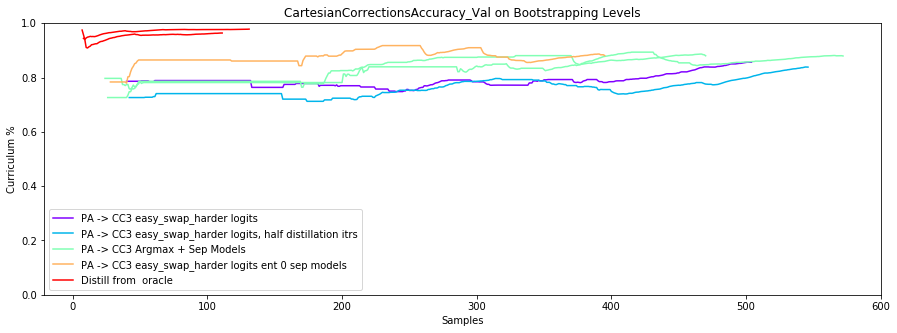

In [68]:
data_names = [ 
    (['1001'], 'PA -> CC3 easy_swap_harder logits'),
    (['1004'], 'PA -> CC3 easy_swap_harder logits, half distillation itrs'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['1012'], 'PA -> CC3 easy_swap_harder logits ent 0 sep models'),
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


Best entropy rate?

Length 547
Length 535
Length 512
Length 750
Length 534
Length 514
Length 535
'Train/Accuracy'
couldn't plot Distill from  oracle


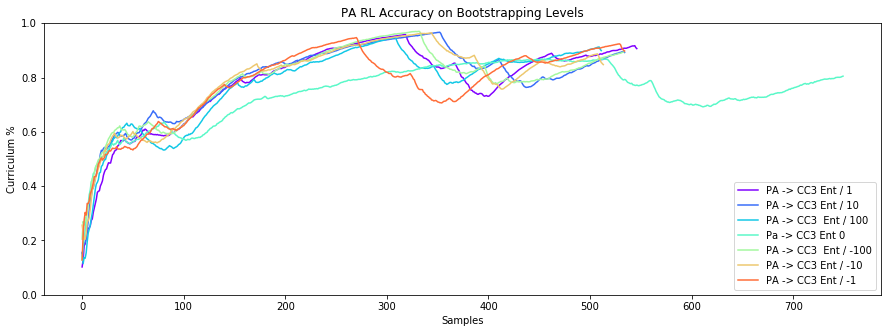

Length 1673
Length 535
Length 512
Length 750
Length 534
Length 514
Length 535
Length 212
Length 208


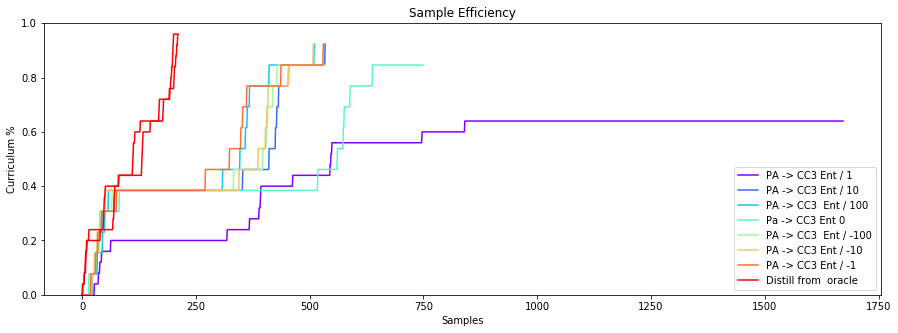

Length 547
Length 535
Length 512
Length 750
Length 534
Length 514
Length 535
Length 112
Length 132


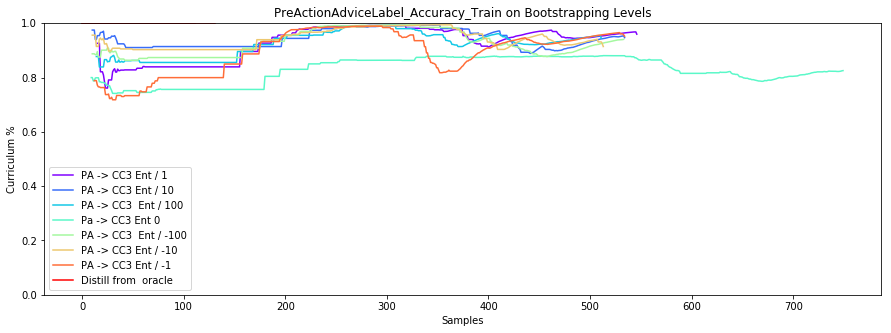

Length 547
Length 535
Length 512
Length 750
Length 534
Length 514
Length 535
Length 112
Length 132


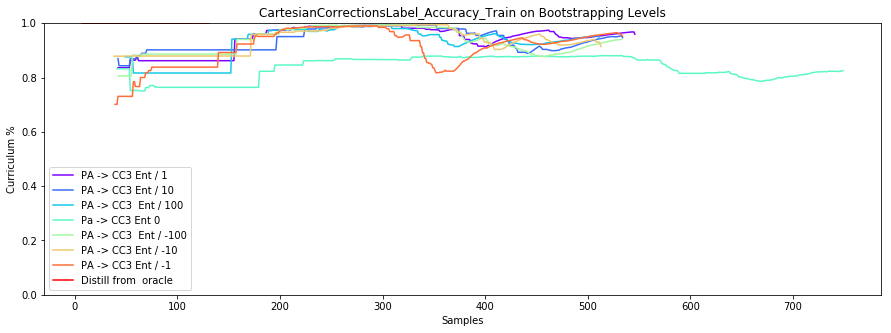

Length 547
Length 535
Length 512
Length 750
Length 534
Length 514
Length 535
Length 112
Length 132


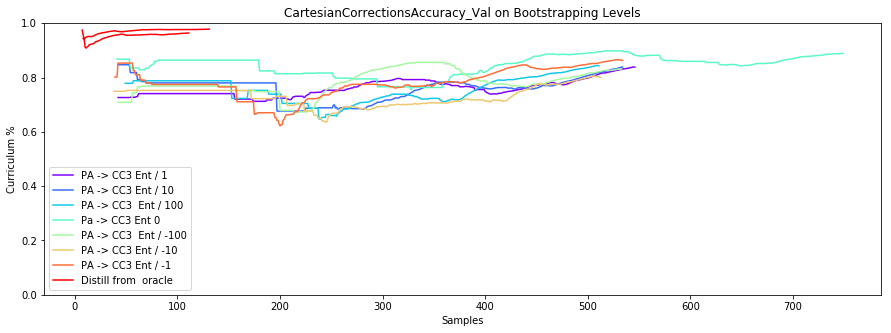

In [69]:
data_names = [ 
    (['T1004'], 'PA -> CC3 Ent / 1'),
    (['T1022'], 'PA -> CC3 Ent / 10'),
    (['T1023'], 'PA -> CC3  Ent / 100'),
    (['T1024'], 'Pa -> CC3 Ent 0'),
    (['T1025'], 'PA -> CC3  Ent / -100'),
    (['T1026'], 'PA -> CC3 Ent / -10'),
    (['T1027'], 'PA -> CC3 Ent / -1'),
    
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


Best distillation steps?

Length 2813
Length 626
Length 586
Length 547
Length 845
Length 722
Length 773
Length 642
'Train/Accuracy'
couldn't plot Distill from  oracle


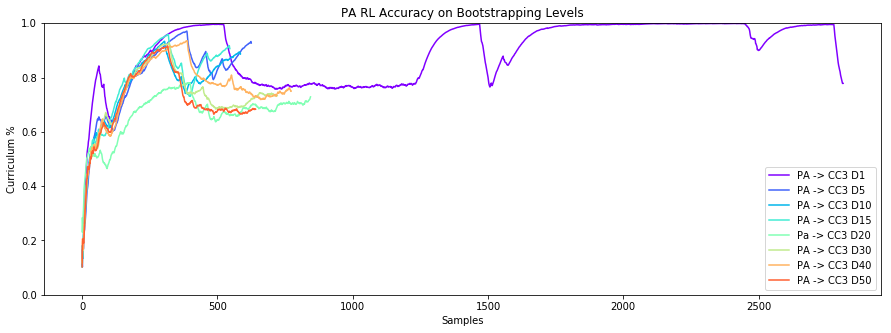

Length 2813
Length 626
Length 586
Length 1673
Length 845
Length 722
Length 773
Length 642
Length 212
Length 208


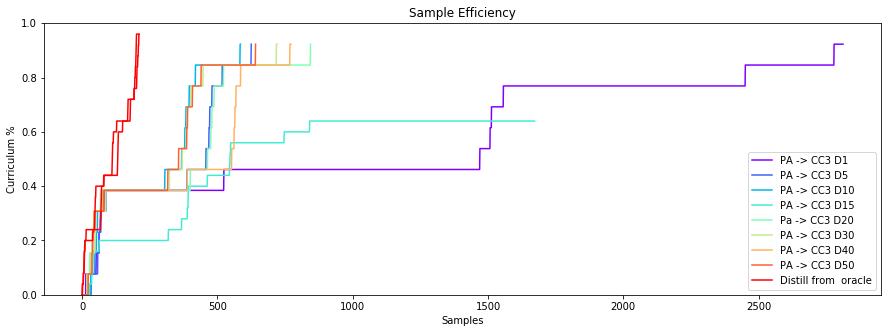

Length 2813
Length 626
Length 586
Length 547
Length 845
Length 722
Length 773
Length 642
Length 112
Length 132


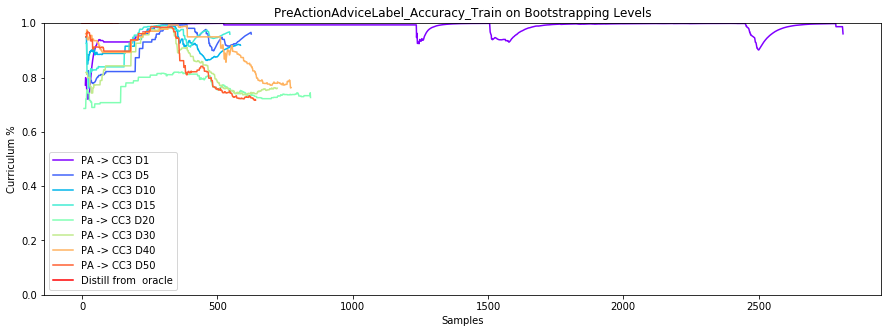

Length 2813
Length 626
Length 586
Length 547
Length 845
Length 722
Length 773
Length 642
Length 112
Length 132


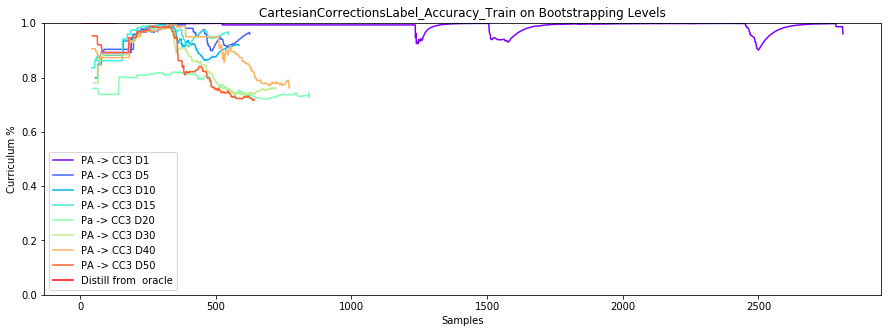

Length 2813
Length 626
Length 586
Length 547
Length 845
Length 722
Length 773
Length 642
Length 112
Length 132


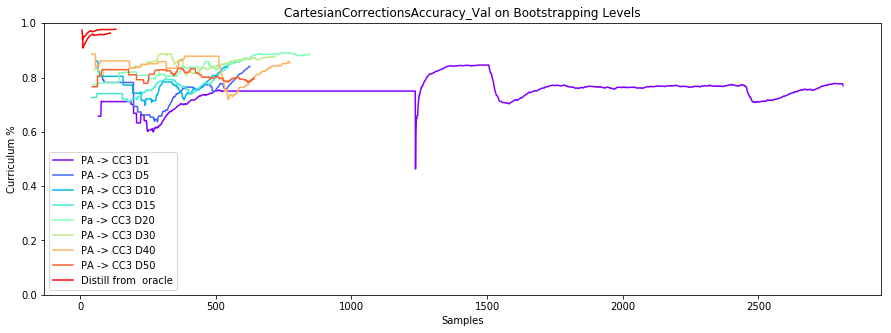

In [70]:
data_names = [ 
    (['T1015'], 'PA -> CC3 D1'),
    (['T1016'], 'PA -> CC3 D5'),
    (['T1017'], 'PA -> CC3 D10'),
    (['T1004'], 'PA -> CC3 D15'),
    (['T1018'], 'Pa -> CC3 D20'),
    (['T1019'], 'PA -> CC3 D30'),
    (['T1020'], 'PA -> CC3 D40'),
    (['T1021'], 'PA -> CC3 D50'),
    
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


# End

Length 282
Length 1485


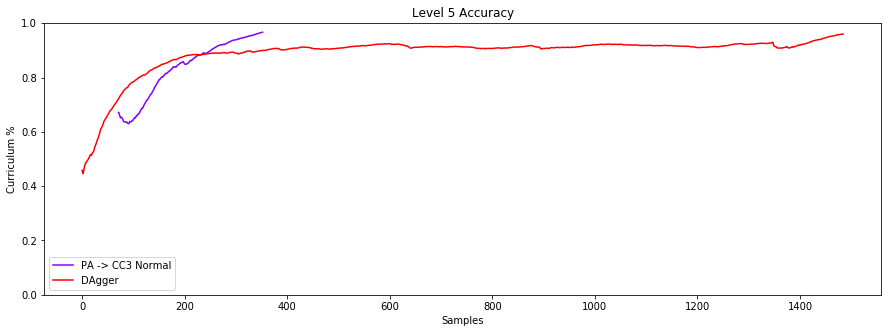

Length 282
Length 1485


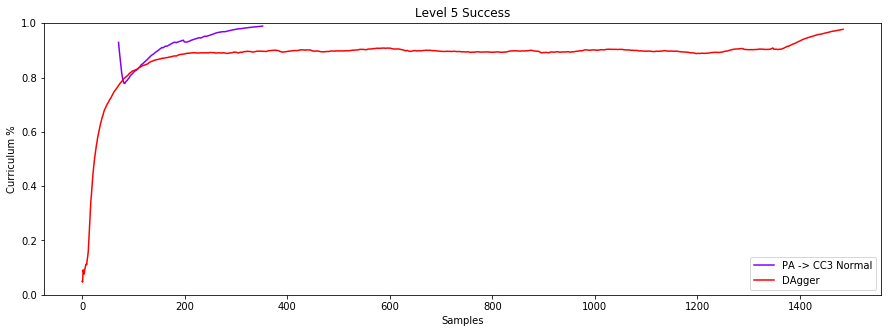

Length 282
Length 1485


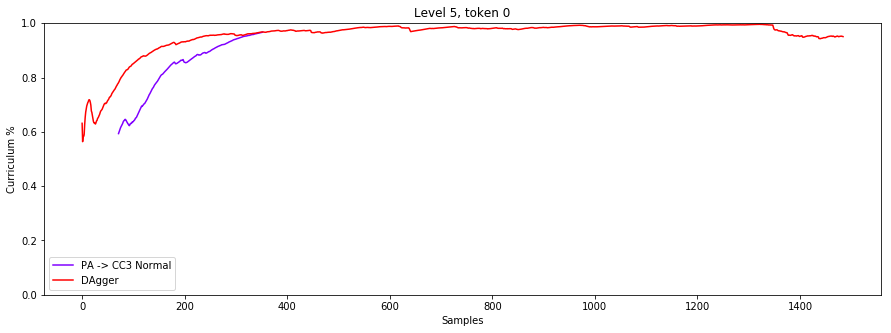

Length 282
Length 1485


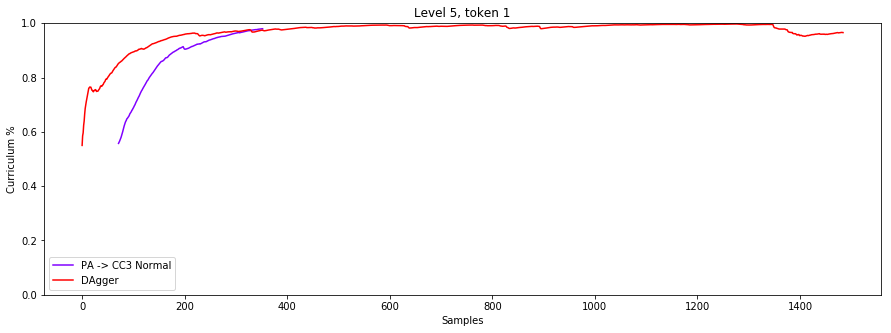

Length 282
Length 1485


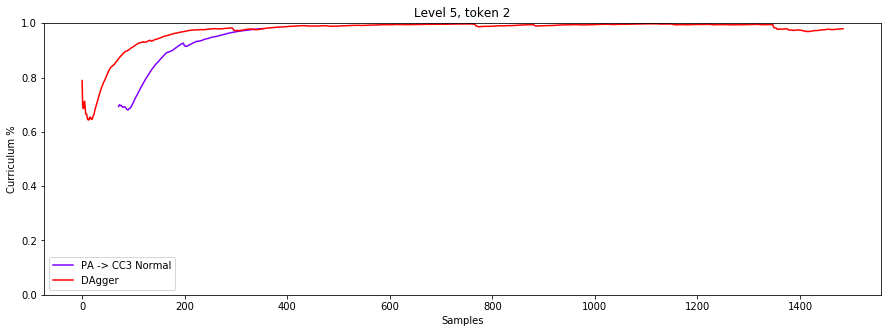

Length 282
Length 1485


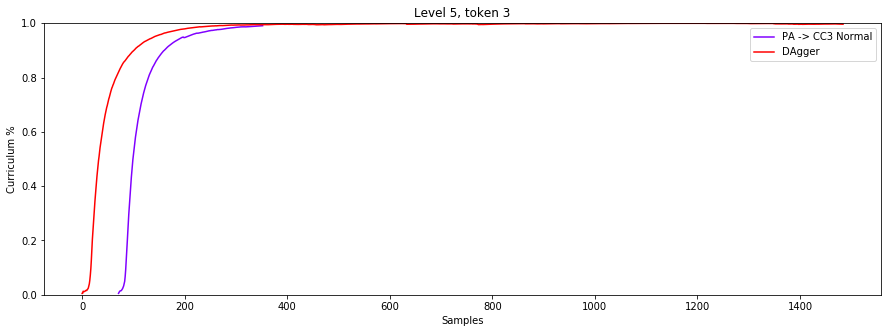

Length 282
Length 1485


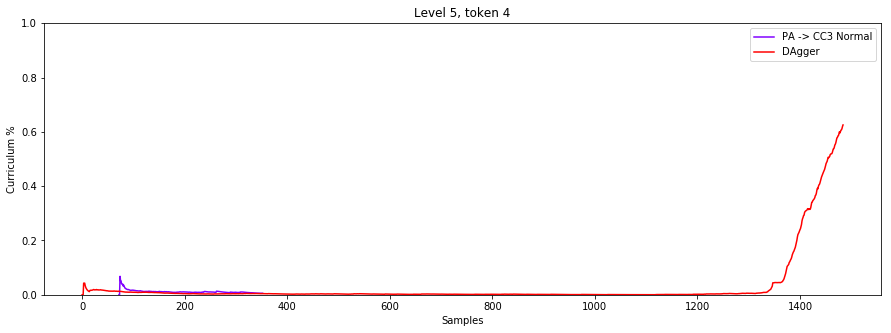

In [71]:
data_names = [ 
    (['1022'], 'PA -> CC3 Normal'),
    (['1032'], 'DAgger'),
] # kangaroo

plot_curriculum(data_names, 'samples', y=f'Train/Accuracy', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5 Accuracy")
plot_curriculum(data_names, 'samples', y=f'Train/Success', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5 Success")


for i in range(5):
    plot_curriculum(data_names, 'samples', y=f'Train/Accuracy{i}', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5, token {i}")

Length 133


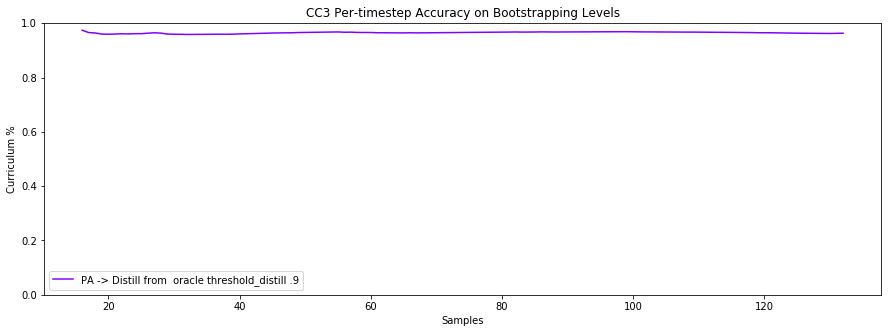

Length 133


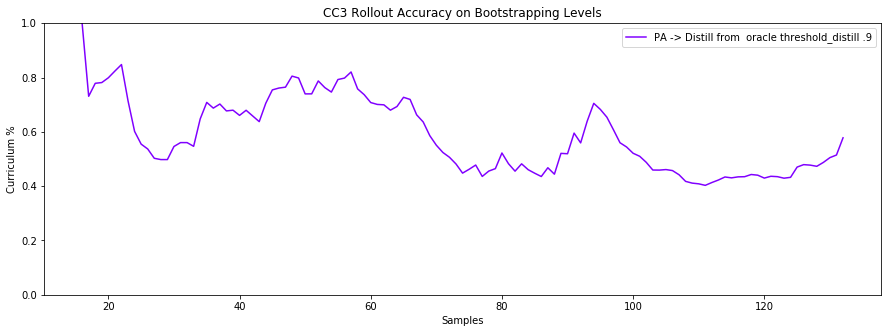

Length 133


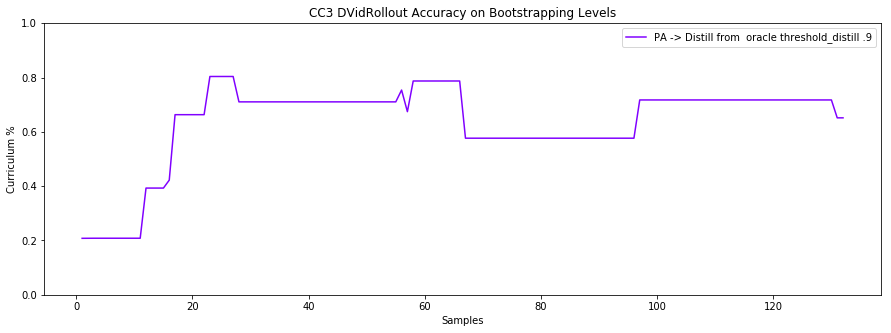

Length 133


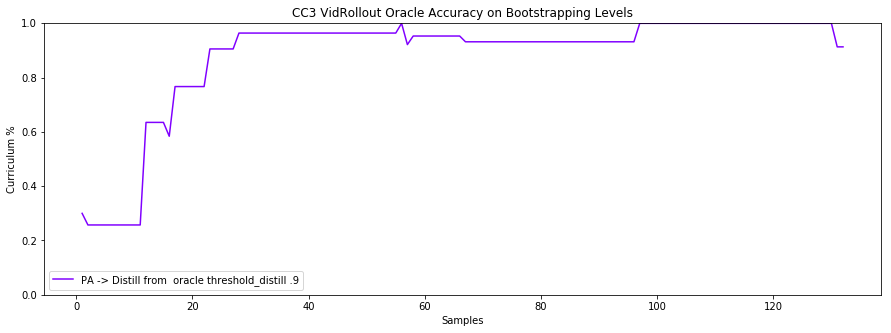

In [72]:
data_names = [ 
    (['1146'], 'PA -> Distill from  oracle threshold_distill .9'),
]

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DVidRollout/StochAcc', smooth=10, 
                level_start=0, level_end=12, title="CC3 DVidRollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='VidRollout/OracleCCAcc', smooth=10, 
                level_start=0, level_end=12, title="CC3 VidRollout Oracle Accuracy on Bootstrapping Levels")